In [34]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/mf-new-indi/data of mutual fund/0P0000YG82 (Icici Prudential Balanced Advantage Fund Direct Plan Monthly Payout Of Inc Dist Cum Cap Wdrl ).csv
/kaggle/input/mf-new-indi/data of mutual fund/0P00005V09 (Hdfc Liquid Fund Growth).csv
/kaggle/input/mf-new-indi/data of mutual fund/0P00005URV (Sbi Liquid Fund Institutional ).csv
/kaggle/input/mf-new-indi/data of mutual fund/0P0001EI10 (Hdfc Balanced Advantage Fund Direct Plan Payout Inc Dist Cum Cap Wdrl Opt).csv
/kaggle/input/mf-new-indi/data of mutual fund/0P0000YCJ0 (Aditya Birla Sun Life Liquid Direct Plan Payout Inc Dist Cum Cap Wdrl).csv
/kaggle/input/mf-new-indi/data of mutual fund/0P0000XXYH (Kotak Flexicap Fund Direct Payout Of Income Dist. Cum Cap Wdrl).csv
/kaggle/input/mf-new-indi/data of mutual fund/0P0000XV6O (Kotak Flexicap Fund Direct Growth).csv
/kaggle/input/mf-new-indi/data of mutual fund/0P0000NRF7 (Sbi Life - Equity Fund).csv
/kaggle/input/mf-new-indi/data of mutual fund/0P00009J3B (HDFC Mid-Cap Opportunitie

In [35]:
import os
data_path = '/kaggle/input/mf-new-indi/data of mutual fund'
print(os.listdir(data_path))


['0P0000YG82 (Icici Prudential Balanced Advantage Fund Direct Plan Monthly Payout Of Inc Dist Cum Cap Wdrl ).csv', '0P00005V09 (Hdfc Liquid Fund Growth).csv', '0P00005URV (Sbi Liquid Fund Institutional ).csv', '0P0001EI10 (Hdfc Balanced Advantage Fund Direct Plan Payout Inc Dist Cum Cap Wdrl Opt).csv', '0P0000YCJ0 (Aditya Birla Sun Life Liquid Direct Plan Payout Inc Dist Cum Cap Wdrl).csv', '0P0000XXYH (Kotak Flexicap Fund Direct Payout Of Income Dist. Cum Cap Wdrl).csv', '0P0000XV6O (Kotak Flexicap Fund Direct Growth).csv', '0P0000NRF7 (Sbi Life - Equity Fund).csv', '0P00009J3B (HDFC Mid-Cap Opportunities Fund Dividend Payout ).csv', '0P0000XW8A (Hdfc Liquid Fund).csv', '0P00005WEY (Sbi Equity Hybrid Fund Regular Growth).csv', '0P00017EXB (Aditya Birla Sun Life Cash Plus Regular Dividend P ).csv', '0P0000XXYH (Kotak Flexicap Fund Direct Payout Of Income Distribution Cum Cap Wdrl).csv', '0P00017EXB (Aditya Birla Sun Life Liquid Regular Payout Inc Dist Cum Cap Wdrl).csv', '0P0000XVJW (S

In [36]:
import os
import pandas as pd

data_path = '/kaggle/input/mf-new-indi/data of mutual fund'

# Now correctly fetch CSV files
all_files = [f for f in os.listdir(data_path) if f.endswith('.csv')]

print(f"Total {len(all_files)} files found!")

# Pick first file
file_name = all_files[0]
print(f"📄 Working on file: {file_name}")

# Read the CSV
df = pd.read_csv(os.path.join(data_path, file_name))

# Show first few rows
print(df.head())


Total 25 files found!
📄 Working on file: 0P0000YG82 (Icici Prudential Balanced Advantage Fund Direct Plan Monthly Payout Of Inc Dist Cum Cap Wdrl ).csv
       Date  Price   Open   High    Low Change %
0  8-Apr-25  24.69  24.69  24.69  24.55    0.57%
1  7-Apr-25  24.55  24.55  24.88  24.55   -1.33%
2  4-Apr-25  24.88  24.88  25.09  24.88   -0.84%
3  3-Apr-25  25.09  25.09  25.12  25.09   -0.12%
4  2-Apr-25  25.12  25.12  25.12  24.96    0.64%


In [37]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense

# Read the first file again
file_path = '/kaggle/input/mf-new-indi/data of mutual fund/0P0000YG82 (Icici Prudential Balanced Advantage Fund Direct Plan Monthly Payout Of Inc Dist Cum Cap Wdrl ).csv'
df = pd.read_csv(file_path)

# 1. Data Cleaning
# Convert 'Date' column to datetime format
df['Date'] = pd.to_datetime(df['Date'], format='%d-%b-%y')

# Sort by Date (important for time series)
df = df.sort_values('Date')

# Clean 'Change %' column: remove % and convert to float
df['Change %'] = df['Change %'].str.replace('%', '').astype(float)

# Set Date as index
df.set_index('Date', inplace=True)

# Focus only on 'Price' for now
prices = df[['Price']].copy()

# Check the cleaned data
print(prices.head())


            Price
Date             
2021-05-14  18.35
2021-05-17  18.48
2021-05-18  18.59
2021-05-19  18.59
2021-05-20  18.55


In [38]:
# 2. Scaling the Prices
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_prices = scaler.fit_transform(prices)

# 3. Creating Sequences
# We'll use the past 60 days' data to predict the next day's price
sequence_length = 60

X = []
y = []

for i in range(sequence_length, len(scaled_prices)):
    X.append(scaled_prices[i-sequence_length:i, 0])
    y.append(scaled_prices[i, 0])

X = np.array(X)
y = np.array(y)

# Reshape X for LSTM [samples, time steps, features]
X = np.reshape(X, (X.shape[0], X.shape[1], 1))

print(f"X shape: {X.shape}")
print(f"y shape: {y.shape}")


X shape: (958, 60, 1)
y shape: (958,)


In [39]:
# 4. Train-Test Split
split_ratio = 0.8
split = int(len(X) * split_ratio)

X_train, X_test = X[:split], X[split:]
y_train, y_test = y[:split], y[split:]

print(f"X_train shape: {X_train.shape}, X_test shape: {X_test.shape}")
print(f"y_train shape: {y_train.shape}, y_test shape: {y_test.shape}")

# 5. LSTM Model
model = Sequential()
model.add(LSTM(units=50, return_sequences=True, input_shape=(X_train.shape[1], 1)))
model.add(LSTM(units=50))
model.add(Dense(1))

model.compile(optimizer='adam', loss='mean_squared_error')

# 6. Train the Model
history = model.fit(X_train, y_train, epochs=20, batch_size=32, validation_data=(X_test, y_test), verbose=1)


X_train shape: (766, 60, 1), X_test shape: (192, 60, 1)
y_train shape: (766,), y_test shape: (192,)
Epoch 1/20


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


24/24 ━━━━━━━━━━━━━━━━━━━━ 6s 66ms/step - loss: 0.0600 - val_loss: 0.0156
Epoch 2/20
24/24 ━━━━━━━━━━━━━━━━━━━━ 1s 45ms/step - loss: 0.0020 - val_loss: 0.0046
Epoch 3/20
24/24 ━━━━━━━━━━━━━━━━━━━━ 1s 46ms/step - loss: 4.5150e-04 - val_loss: 0.0016
Epoch 4/20
24/24 ━━━━━━━━━━━━━━━━━━━━ 1s 45ms/step - loss: 4.3606e-04 - val_loss: 0.0022
Epoch 5/20
24/24 ━━━━━━━━━━━━━━━━━━━━ 1s 45ms/step - loss: 4.3941e-04 - val_loss: 0.0030
Epoch 6/20
24/24 ━━━━━━━━━━━━━━━━━━━━ 1s 45ms/step - loss: 4.5416e-04 - val_loss: 0.0013
Epoch 7/20
24/24 ━━━━━━━━━━━━━━━━━━━━ 1s 45ms/step - loss: 3.9177e-04 - val_loss: 0.0012
Epoch 8/20
24/24 ━━━━━━━━━━━━━━━━━━━━ 1s 45ms/step - loss: 3.8618e-04 - val_loss: 0.0019
Epoch 9/20
24/24 ━━━━━━━━━━━━━━━━━━━━ 1s 45ms/step - loss: 3.7557e-04 - val_loss: 0.0013
Epoch 10/20
24/24 ━━━━━━━━━━━━━━━━━━━━ 1s 44ms/step - loss: 3.8229e-04 - val_loss: 0.0026
Epoch 11/20
24/24 ━━━━━━━━━━━━━━━━━━━━ 1s 45ms/step - loss: 4.0269e-04 - val_loss: 0.0013
Epoch 12/20
24/24 ━━━━━━━━━━━━━━━━━━━━

6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
📈 Evaluation Metrics:
RMSE: 0.031073604792852892
MAE: 0.025336328707790807
R² Score: 0.6991171762420457


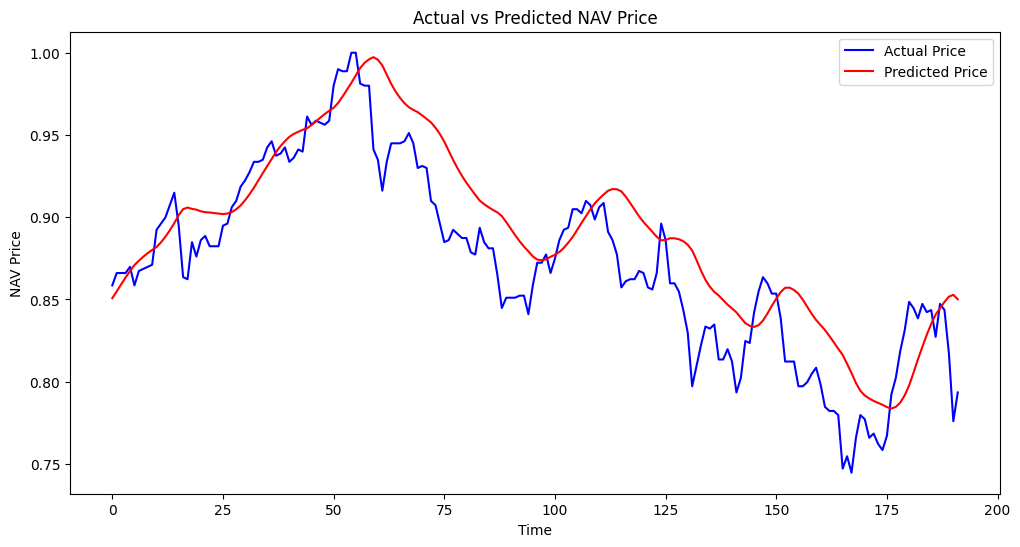

In [40]:
# 7. Make Predictions
y_pred = model.predict(X_test)

# 8. Inverse Scaling (optional)
# (If you had used scaling earlier, you would inverse it here. But we haven't scaled prices yet.)

# 9. Evaluation Metrics
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import numpy as np

rmse = np.sqrt(mean_squared_error(y_test, y_pred))
mae = mean_absolute_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print(f"📈 Evaluation Metrics:")
print(f"RMSE: {rmse}")
print(f"MAE: {mae}")
print(f"R² Score: {r2}")

# 10. Plotting Actual vs Predicted
import matplotlib.pyplot as plt

plt.figure(figsize=(12,6))
plt.plot(y_test, label='Actual Price', color='blue')
plt.plot(y_pred, label='Predicted Price', color='red')
plt.title('Actual vs Predicted NAV Price')
plt.xlabel('Time')
plt.ylabel('NAV Price')
plt.legend()
plt.show()



In [41]:
# import os
# import pandas as pd
# import numpy as np
# import matplotlib.pyplot as plt
# from sklearn.preprocessing import MinMaxScaler
# from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
# from keras.models import Sequential
# from keras.layers import LSTM, Dense

# # Path to your data
# data_path = '/kaggle/input/mf-new-indi/data of mutual fund'

# # Fetch all CSV files
# all_files = [f for f in os.listdir(data_path) if f.endswith('.csv')]

# print(f"Total {len(all_files)} files found!")

# # Loop over all files
# for file_name in all_files:
#     print(f"\n📄 Working on file: {file_name}")

#     try:
#         # 1. Read the CSV
#         df = pd.read_csv(os.path.join(data_path, file_name))

#         # 2. Data Cleaning
#         df.columns = df.columns.str.strip()  # Strip any extra spaces
#         if 'Price' not in df.columns:
#             print(f"⚠️ Skipped: 'Price' column missing.")
#             continue
        
#         # Ensure 'Price' column is treated as string before replacing commas
#         df['Price'] = df['Price'].astype(str).str.replace(',', '', regex=True).astype(float)

#         df['Date'] = pd.to_datetime(df['Date'], format='%d-%b-%y', errors='coerce')
#         df = df.dropna(subset=['Date'])  # Drop rows where Date parsing failed
#         df = df.sort_values('Date')
        
#         if 'Change %' in df.columns:
#             df['Change %'] = df['Change %'].str.replace('%', '', regex=True).astype(float)

#         df.set_index('Date', inplace=True)
#         prices = df[['Price']].copy()

#         print(prices.head())

#         # 3. Scaling the Prices
#         scaler = MinMaxScaler(feature_range=(0, 1))
#         scaled_prices = scaler.fit_transform(prices)

#         # 4. Creating Sequences
#         sequence_length = 60

#         X = []
#         y = []

#         for i in range(sequence_length, len(scaled_prices)):
#             X.append(scaled_prices[i-sequence_length:i, 0])
#             y.append(scaled_prices[i, 0])

#         X = np.array(X)
#         y = np.array(y)

#         X = np.reshape(X, (X.shape[0], X.shape[1], 1))

#         print(f"X shape: {X.shape}")
#         print(f"y shape: {y.shape}")

#         # 5. Train-Test Split
#         split_ratio = 0.8
#         split = int(len(X) * split_ratio)

#         X_train, X_test = X[:split], X[split:]
#         y_train, y_test = y[:split], y[split:]

#         print(f"X_train shape: {X_train.shape}, X_test shape: {X_test.shape}")
#         print(f"y_train shape: {y_train.shape}, y_test shape: {y_test.shape}")

#         # 6. LSTM Model
#         model = Sequential()
#         model.add(LSTM(units=50, return_sequences=True, input_shape=(X_train.shape[1], 1)))
#         model.add(LSTM(units=50))
#         model.add(Dense(1))

#         model.compile(optimizer='adam', loss='mean_squared_error')

#         # 7. Train the Model
#         history = model.fit(X_train, y_train, epochs=20, batch_size=32, validation_data=(X_test, y_test), verbose=1)

#         # 8. Make Predictions
#         y_pred = model.predict(X_test)

#         # 9. Evaluation Metrics
#         rmse = np.sqrt(mean_squared_error(y_test, y_pred))
#         mae = mean_absolute_error(y_test, y_pred)
#         r2 = r2_score(y_test, y_pred)

#         print(f"📈 Evaluation Metrics for {file_name}:")
#         print(f"RMSE: {rmse}")
#         print(f"MAE: {mae}")
#         print(f"R² Score: {r2}")

#         # 10. Plotting Actual vs Predicted
#         plt.figure(figsize=(12,6))
#         plt.plot(y_test, label='Actual Price', color='blue')
#         plt.plot(y_pred, label='Predicted Price', color='red')
#         plt.title(f'Actual vs Predicted NAV Price\n{file_name}')
#         plt.xlabel('Time')
#         plt.ylabel('NAV Price')
#         plt.legend()
#         plt.show()

#     except Exception as e:
#         print(f"❌ Error processing {file_name}: {e}")


Total 25 files found!

📄 Working on file: 0P0000YG82 (Icici Prudential Balanced Advantage Fund Direct Plan Monthly Payout Of Inc Dist Cum Cap Wdrl ).csv
            Price
Date             
2021-05-14  18.35
2021-05-17  18.48
2021-05-18  18.59
2021-05-19  18.59
2021-05-20  18.55
X shape: (958, 60, 1)
y shape: (958,)
X_train shape: (766, 60, 1), X_test shape: (192, 60, 1)
y_train shape: (766,), y_test shape: (192,)
Epoch 1/20


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


24/24 ━━━━━━━━━━━━━━━━━━━━ 6s 65ms/step - loss: 0.0772 - val_loss: 0.0521
Epoch 2/20
24/24 ━━━━━━━━━━━━━━━━━━━━ 1s 51ms/step - loss: 0.0048 - val_loss: 0.0020
Epoch 3/20
24/24 ━━━━━━━━━━━━━━━━━━━━ 1s 49ms/step - loss: 7.3559e-04 - val_loss: 0.0039
Epoch 4/20
24/24 ━━━━━━━━━━━━━━━━━━━━ 1s 44ms/step - loss: 4.8977e-04 - val_loss: 0.0022
Epoch 5/20
24/24 ━━━━━━━━━━━━━━━━━━━━ 1s 46ms/step - loss: 3.9388e-04 - val_loss: 0.0015
Epoch 6/20
24/24 ━━━━━━━━━━━━━━━━━━━━ 1s 47ms/step - loss: 3.9403e-04 - val_loss: 0.0020
Epoch 7/20
24/24 ━━━━━━━━━━━━━━━━━━━━ 1s 45ms/step - loss: 4.3518e-04 - val_loss: 0.0016
Epoch 8/20
24/24 ━━━━━━━━━━━━━━━━━━━━ 1s 45ms/step - loss: 4.3185e-04 - val_loss: 0.0013
Epoch 9/20
24/24 ━━━━━━━━━━━━━━━━━━━━ 1s 45ms/step - loss: 4.3091e-04 - val_loss: 0.0015
Epoch 10/20
24/24 ━━━━━━━━━━━━━━━━━━━━ 1s 44ms/step - loss: 3.8947e-04 - val_loss: 9.8701e-04
Epoch 11/20
24/24 ━━━━━━━━━━━━━━━━━━━━ 1s 44ms/step - loss: 4.1887e-04 - val_loss: 0.0032
Epoch 12/20
24/24 ━━━━━━━━━━━━━━━━

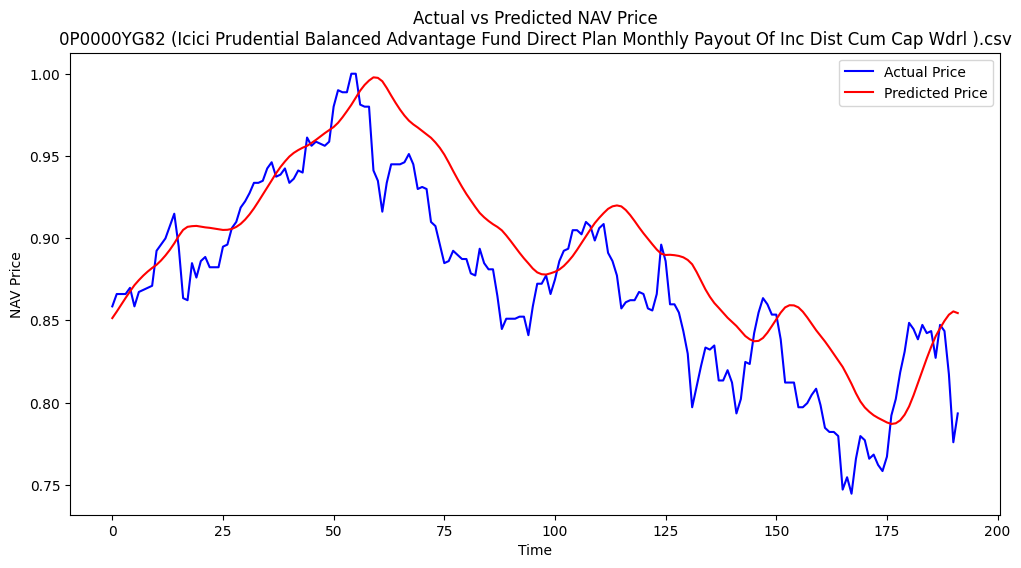


📄 Working on file: 0P00005V09 (Hdfc Liquid Fund Growth).csv
              Price
Date               
2021-05-14  4032.13
2021-05-15  4032.47
2021-05-16  4032.82
2021-05-17  4033.17
2021-05-18  4033.50
X shape: (1329, 60, 1)
y shape: (1329,)
X_train shape: (1063, 60, 1), X_test shape: (266, 60, 1)
y_train shape: (1063,), y_test shape: (266,)
Epoch 1/20


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


34/34 ━━━━━━━━━━━━━━━━━━━━ 9s 60ms/step - loss: 0.0354 - val_loss: 0.0030
Epoch 2/20
34/34 ━━━━━━━━━━━━━━━━━━━━ 2s 46ms/step - loss: 2.1348e-04 - val_loss: 2.2540e-04
Epoch 3/20
34/34 ━━━━━━━━━━━━━━━━━━━━ 2s 52ms/step - loss: 9.0011e-06 - val_loss: 3.9379e-04
Epoch 4/20
34/34 ━━━━━━━━━━━━━━━━━━━━ 2s 44ms/step - loss: 4.3572e-06 - val_loss: 4.1387e-04
Epoch 5/20
34/34 ━━━━━━━━━━━━━━━━━━━━ 2s 45ms/step - loss: 3.9117e-06 - val_loss: 3.6941e-04
Epoch 6/20
34/34 ━━━━━━━━━━━━━━━━━━━━ 1s 43ms/step - loss: 3.7787e-06 - val_loss: 4.2930e-04
Epoch 7/20
34/34 ━━━━━━━━━━━━━━━━━━━━ 2s 44ms/step - loss: 3.6773e-06 - val_loss: 4.5521e-04
Epoch 8/20
34/34 ━━━━━━━━━━━━━━━━━━━━ 2s 44ms/step - loss: 3.6085e-06 - val_loss: 4.7297e-04
Epoch 9/20
34/34 ━━━━━━━━━━━━━━━━━━━━ 2s 44ms/step - loss: 3.6387e-06 - val_loss: 4.7780e-04
Epoch 10/20
34/34 ━━━━━━━━━━━━━━━━━━━━ 2s 45ms/step - loss: 3.3762e-06 - val_loss: 4.2738e-04
Epoch 11/20
34/34 ━━━━━━━━━━━━━━━━━━━━ 2s 44ms/step - loss: 3.2842e-06 - val_loss: 4.717

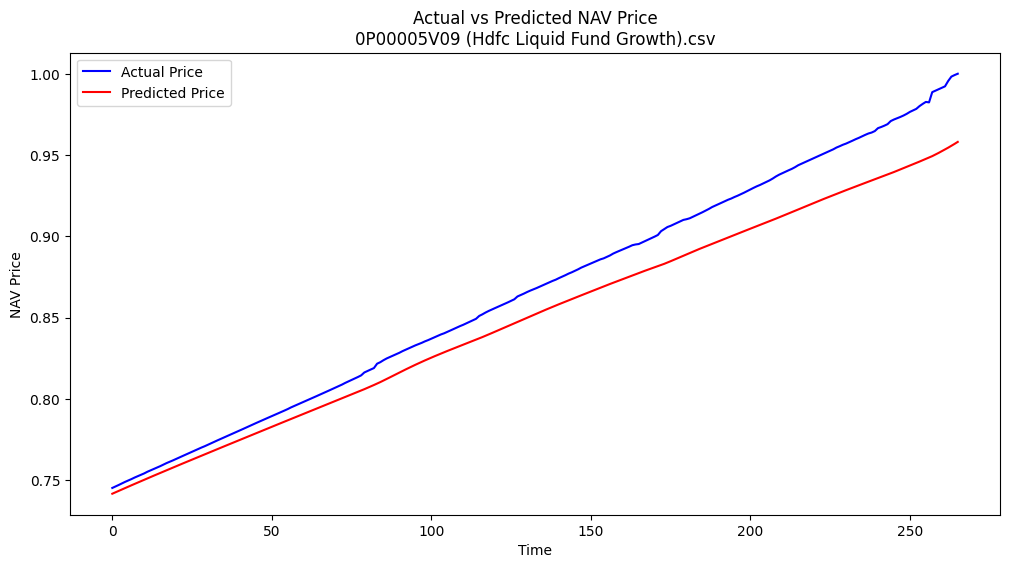


📄 Working on file: 0P00005URV (Sbi Liquid Fund Institutional ).csv
              Price
Date               
2021-05-14  1066.83
2021-05-15  1066.92
2021-05-16  1067.01
2021-05-17  1067.10
2021-05-18  1067.19
X shape: (900, 60, 1)
y shape: (900,)
X_train shape: (720, 60, 1), X_test shape: (180, 60, 1)
y_train shape: (720,), y_test shape: (180,)
Epoch 1/20


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


23/23 ━━━━━━━━━━━━━━━━━━━━ 6s 68ms/step - loss: 0.0601 - val_loss: 0.0242
Epoch 2/20
23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 44ms/step - loss: 0.0020 - val_loss: 4.2893e-05
Epoch 3/20
23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 44ms/step - loss: 1.8664e-04 - val_loss: 2.6762e-04
Epoch 4/20
23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 44ms/step - loss: 2.8579e-05 - val_loss: 1.6704e-04
Epoch 5/20
23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 44ms/step - loss: 9.7068e-06 - val_loss: 7.4073e-05
Epoch 6/20
23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 44ms/step - loss: 4.9987e-06 - val_loss: 1.3606e-04
Epoch 7/20
23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 45ms/step - loss: 4.0352e-06 - val_loss: 1.5000e-04
Epoch 8/20
23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 44ms/step - loss: 3.1507e-06 - val_loss: 2.0139e-04
Epoch 9/20
23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 44ms/step - loss: 2.6348e-06 - val_loss: 2.4213e-04
Epoch 10/20
23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 44ms/step - loss: 2.1980e-06 - val_loss: 2.4607e-04
Epoch 11/20
23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 44ms/step - loss: 1.9481e-06 - val_loss: 2.6592e-0

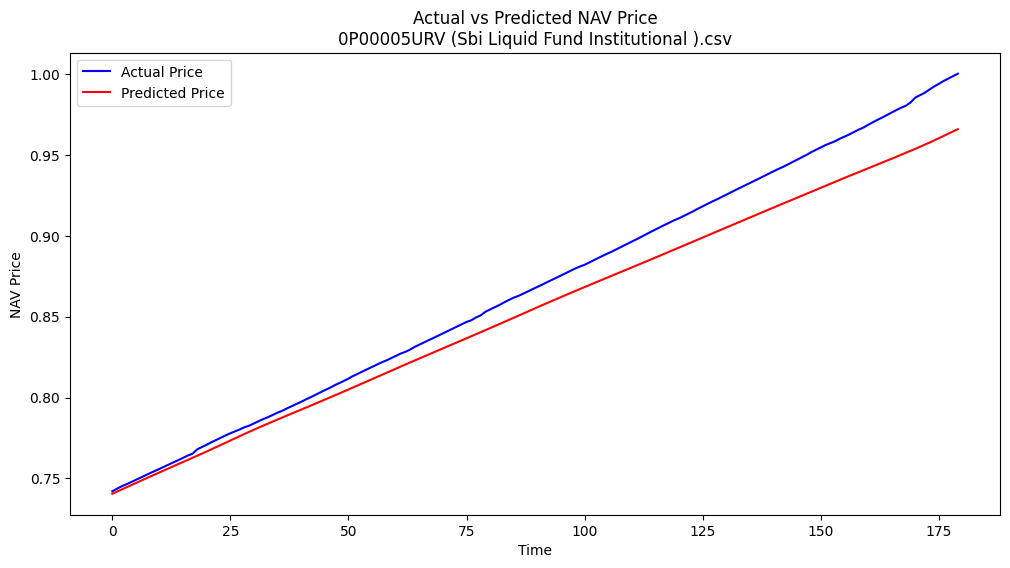


📄 Working on file: 0P0001EI10 (Hdfc Balanced Advantage Fund Direct Plan Payout Inc Dist Cum Cap Wdrl Opt).csv
             Price
Date              
2021-05-14  29.317
2021-05-17  29.671
2021-05-18  29.807
2021-05-19  29.881
2021-05-20  29.788
X shape: (958, 60, 1)
y shape: (958,)
X_train shape: (766, 60, 1), X_test shape: (192, 60, 1)
y_train shape: (766,), y_test shape: (192,)
Epoch 1/20


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


24/24 ━━━━━━━━━━━━━━━━━━━━ 6s 67ms/step - loss: 0.0385 - val_loss: 0.0016
Epoch 2/20
24/24 ━━━━━━━━━━━━━━━━━━━━ 1s 44ms/step - loss: 0.0020 - val_loss: 0.0036
Epoch 3/20
24/24 ━━━━━━━━━━━━━━━━━━━━ 1s 44ms/step - loss: 8.1746e-04 - val_loss: 0.0011
Epoch 4/20
24/24 ━━━━━━━━━━━━━━━━━━━━ 1s 51ms/step - loss: 7.9948e-04 - val_loss: 0.0011
Epoch 5/20
24/24 ━━━━━━━━━━━━━━━━━━━━ 1s 48ms/step - loss: 7.6664e-04 - val_loss: 0.0012
Epoch 6/20
24/24 ━━━━━━━━━━━━━━━━━━━━ 1s 44ms/step - loss: 7.7795e-04 - val_loss: 0.0012
Epoch 7/20
24/24 ━━━━━━━━━━━━━━━━━━━━ 1s 44ms/step - loss: 7.2382e-04 - val_loss: 0.0015
Epoch 8/20
24/24 ━━━━━━━━━━━━━━━━━━━━ 1s 45ms/step - loss: 7.8163e-04 - val_loss: 0.0012
Epoch 9/20
24/24 ━━━━━━━━━━━━━━━━━━━━ 1s 44ms/step - loss: 7.0851e-04 - val_loss: 0.0010
Epoch 10/20
24/24 ━━━━━━━━━━━━━━━━━━━━ 1s 45ms/step - loss: 7.4205e-04 - val_loss: 0.0013
Epoch 11/20
24/24 ━━━━━━━━━━━━━━━━━━━━ 1s 44ms/step - loss: 7.6354e-04 - val_loss: 0.0014
Epoch 12/20
24/24 ━━━━━━━━━━━━━━━━━━━━

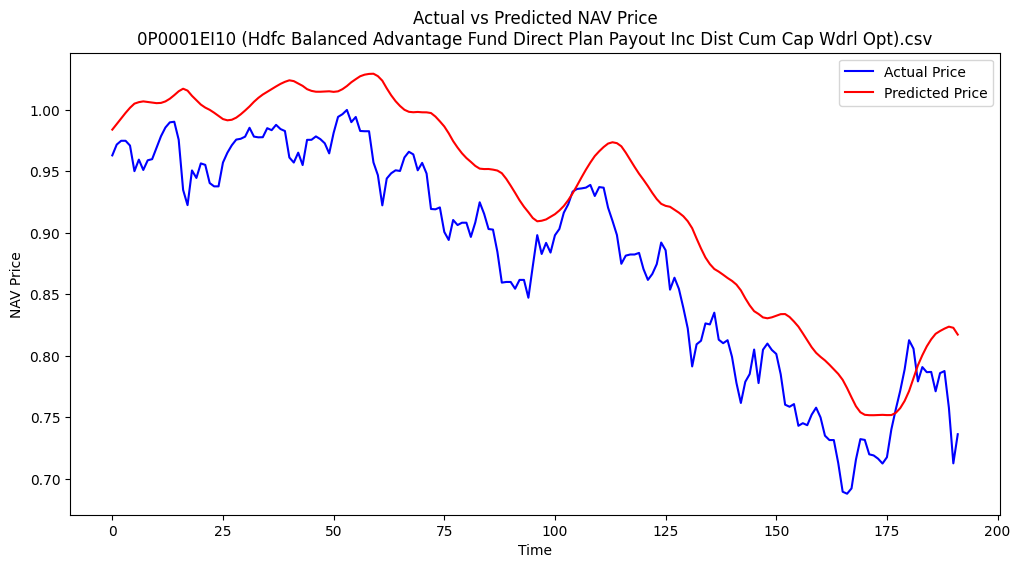


📄 Working on file: 0P0000YCJ0 (Aditya Birla Sun Life Liquid Direct Plan Payout Inc Dist Cum Cap Wdrl).csv
              Price
Date               
2021-05-14  180.687
2021-05-16  180.723
2021-05-17  180.741
2021-05-18  180.757
2021-05-19  180.773
X shape: (1330, 60, 1)
y shape: (1330,)
X_train shape: (1064, 60, 1), X_test shape: (266, 60, 1)
y_train shape: (1064,), y_test shape: (266,)
Epoch 1/20


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


34/34 ━━━━━━━━━━━━━━━━━━━━ 6s 60ms/step - loss: 0.1505 - val_loss: 0.0154
Epoch 2/20
34/34 ━━━━━━━━━━━━━━━━━━━━ 2s 44ms/step - loss: 0.0033 - val_loss: 0.0061
Epoch 3/20
34/34 ━━━━━━━━━━━━━━━━━━━━ 1s 43ms/step - loss: 4.7612e-04 - val_loss: 0.0052
Epoch 4/20
34/34 ━━━━━━━━━━━━━━━━━━━━ 2s 45ms/step - loss: 7.0739e-04 - val_loss: 0.0058
Epoch 5/20
34/34 ━━━━━━━━━━━━━━━━━━━━ 2s 44ms/step - loss: 5.2099e-04 - val_loss: 0.0049
Epoch 6/20
34/34 ━━━━━━━━━━━━━━━━━━━━ 2s 50ms/step - loss: 5.6656e-04 - val_loss: 0.0049
Epoch 7/20
34/34 ━━━━━━━━━━━━━━━━━━━━ 2s 47ms/step - loss: 4.1329e-04 - val_loss: 0.0052
Epoch 8/20
34/34 ━━━━━━━━━━━━━━━━━━━━ 2s 44ms/step - loss: 4.0905e-04 - val_loss: 0.0047
Epoch 9/20
34/34 ━━━━━━━━━━━━━━━━━━━━ 2s 44ms/step - loss: 6.4093e-04 - val_loss: 0.0051
Epoch 10/20
34/34 ━━━━━━━━━━━━━━━━━━━━ 2s 46ms/step - loss: 6.3888e-04 - val_loss: 0.0048
Epoch 11/20
34/34 ━━━━━━━━━━━━━━━━━━━━ 1s 44ms/step - loss: 6.8396e-04 - val_loss: 0.0046
Epoch 12/20
34/34 ━━━━━━━━━━━━━━━━━━━━

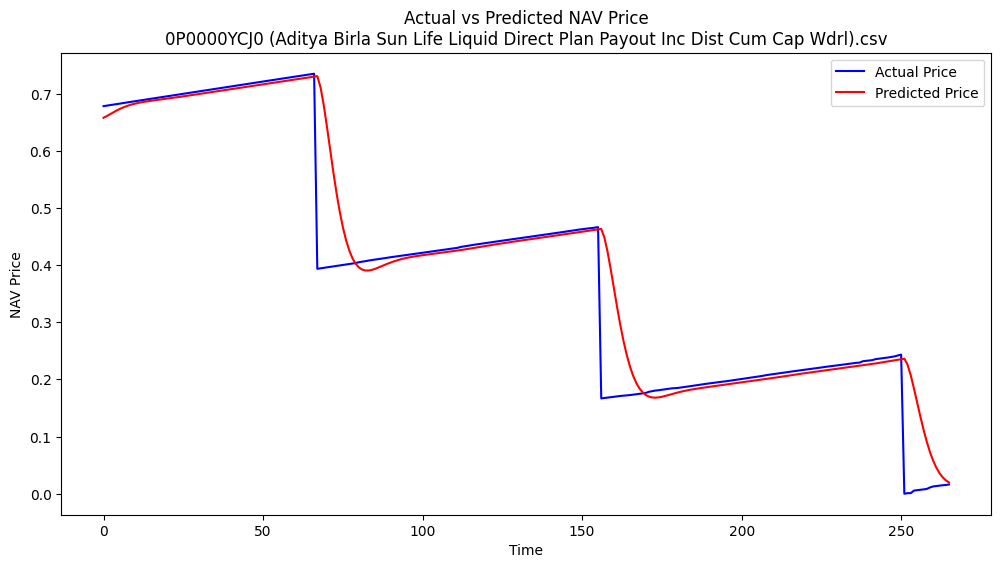


📄 Working on file: 0P0000XXYH (Kotak Flexicap Fund Direct Payout Of Income Dist. Cum Cap Wdrl).csv
             Price
Date              
2021-05-14  29.691
2021-05-17  30.217
2021-05-18  30.606
2021-05-19  30.556
2021-05-20  30.420
X shape: (901, 60, 1)
y shape: (901,)
X_train shape: (720, 60, 1), X_test shape: (181, 60, 1)
y_train shape: (720,), y_test shape: (181,)
Epoch 1/20


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


23/23 ━━━━━━━━━━━━━━━━━━━━ 6s 68ms/step - loss: 0.0586 - val_loss: 0.0260
Epoch 2/20
23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 44ms/step - loss: 0.0026 - val_loss: 0.0043
Epoch 3/20
23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 44ms/step - loss: 8.1086e-04 - val_loss: 0.0049
Epoch 4/20
23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 47ms/step - loss: 7.3272e-04 - val_loss: 0.0036
Epoch 5/20
23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 51ms/step - loss: 8.1653e-04 - val_loss: 0.0044
Epoch 6/20
23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 46ms/step - loss: 7.5850e-04 - val_loss: 0.0026
Epoch 7/20
23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 44ms/step - loss: 7.1250e-04 - val_loss: 0.0032
Epoch 8/20
23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 44ms/step - loss: 6.9564e-04 - val_loss: 0.0061
Epoch 9/20
23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 44ms/step - loss: 7.3452e-04 - val_loss: 0.0034
Epoch 10/20
23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 44ms/step - loss: 7.0837e-04 - val_loss: 0.0048
Epoch 11/20
23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 44ms/step - loss: 6.8840e-04 - val_loss: 0.0043
Epoch 12/20
23/23 ━━━━━━━━━━━━━━━━━━━━

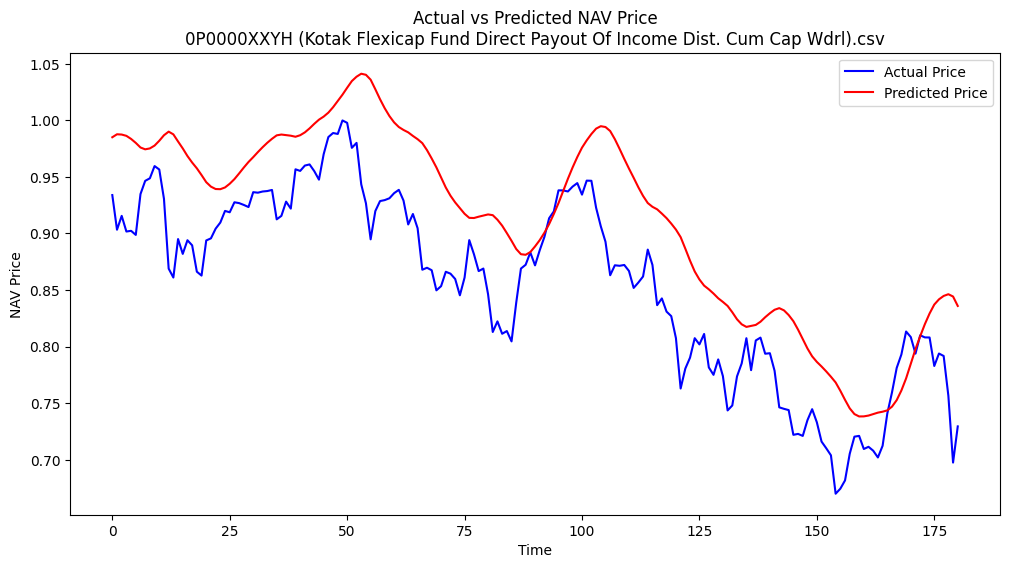


📄 Working on file: 0P0000XV6O (Kotak Flexicap Fund Direct Growth).csv
             Price
Date              
2021-05-14  48.617
2021-05-17  49.478
2021-05-18  50.115
2021-05-19  50.034
2021-05-20  49.811
X shape: (901, 60, 1)
y shape: (901,)
X_train shape: (720, 60, 1), X_test shape: (181, 60, 1)
y_train shape: (720,), y_test shape: (181,)
Epoch 1/20


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


23/23 ━━━━━━━━━━━━━━━━━━━━ 6s 67ms/step - loss: 0.0544 - val_loss: 0.0118
Epoch 2/20
23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 44ms/step - loss: 0.0025 - val_loss: 0.0145
Epoch 3/20
23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 44ms/step - loss: 9.9946e-04 - val_loss: 0.0035
Epoch 4/20
23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 44ms/step - loss: 8.1186e-04 - val_loss: 0.0044
Epoch 5/20
23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 44ms/step - loss: 7.4395e-04 - val_loss: 0.0037
Epoch 6/20
23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 44ms/step - loss: 7.9565e-04 - val_loss: 0.0043
Epoch 7/20
23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 44ms/step - loss: 7.6553e-04 - val_loss: 0.0042
Epoch 8/20
23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 44ms/step - loss: 7.2347e-04 - val_loss: 0.0033
Epoch 9/20
23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 48ms/step - loss: 7.5131e-04 - val_loss: 0.0054
Epoch 10/20
23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 51ms/step - loss: 7.4190e-04 - val_loss: 0.0048
Epoch 11/20
23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 46ms/step - loss: 7.1708e-04 - val_loss: 0.0033
Epoch 12/20
23/23 ━━━━━━━━━━━━━━━━━━━━

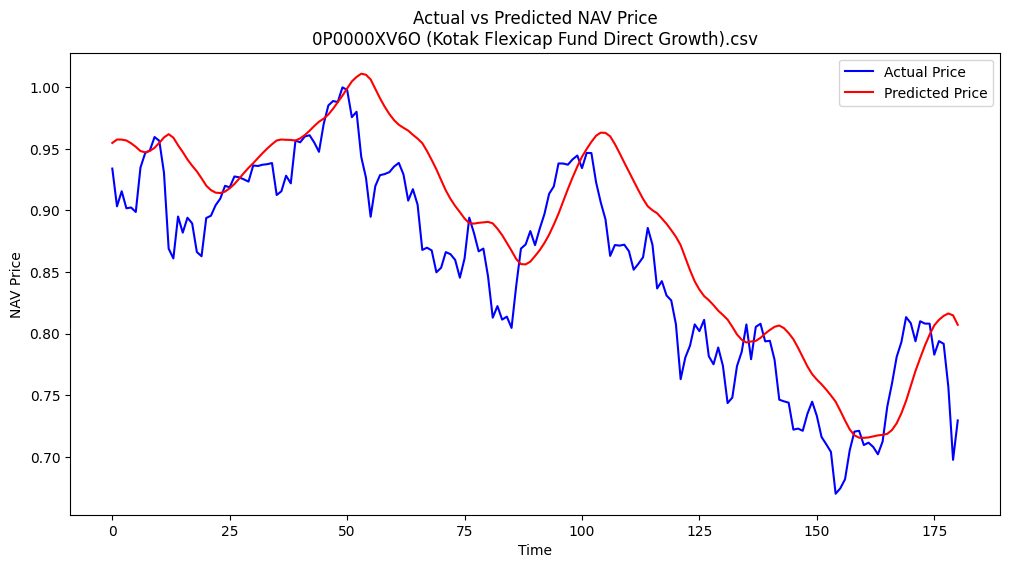


📄 Working on file: 0P0000NRF7 (Sbi Life - Equity Fund).csv
              Price
Date               
2021-05-14  116.910
2021-05-17  118.697
2021-05-18  120.195
2021-05-19  119.596
2021-05-20  118.636
X shape: (901, 60, 1)
y shape: (901,)
X_train shape: (720, 60, 1), X_test shape: (181, 60, 1)
y_train shape: (720,), y_test shape: (181,)
Epoch 1/20


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


23/23 ━━━━━━━━━━━━━━━━━━━━ 6s 68ms/step - loss: 0.0347 - val_loss: 0.0073
Epoch 2/20
23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 44ms/step - loss: 0.0021 - val_loss: 0.0028
Epoch 3/20
23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 44ms/step - loss: 8.6916e-04 - val_loss: 0.0039
Epoch 4/20
23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 44ms/step - loss: 8.7054e-04 - val_loss: 0.0022
Epoch 5/20
23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 45ms/step - loss: 8.1448e-04 - val_loss: 0.0024
Epoch 6/20
23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 45ms/step - loss: 7.8617e-04 - val_loss: 0.0036
Epoch 7/20
23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 44ms/step - loss: 7.8524e-04 - val_loss: 0.0024
Epoch 8/20
23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 44ms/step - loss: 7.2000e-04 - val_loss: 0.0037
Epoch 9/20
23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 45ms/step - loss: 7.5752e-04 - val_loss: 0.0028
Epoch 10/20
23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 45ms/step - loss: 7.6313e-04 - val_loss: 0.0020
Epoch 11/20
23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 49ms/step - loss: 7.2363e-04 - val_loss: 0.0041
Epoch 12/20
23/23 ━━━━━━━━━━━━━━━━━━━━

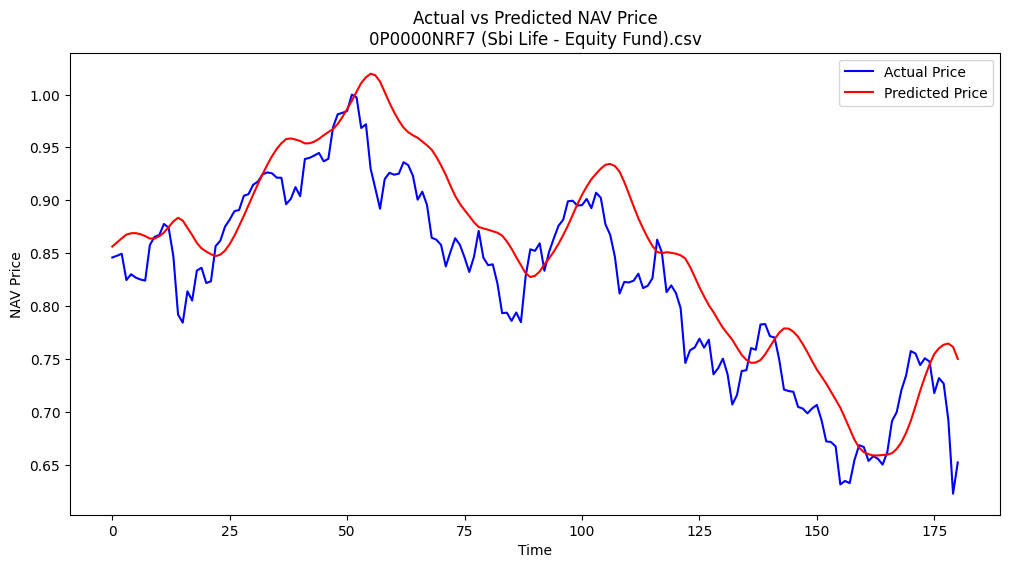


📄 Working on file: 0P00009J3B (HDFC Mid-Cap Opportunities Fund Dividend Payout ).csv
             Price
Date              
2021-05-14  31.082
2021-05-17  31.818
2021-05-18  32.193
2021-05-19  32.195
2021-05-20  32.316
X shape: (899, 60, 1)
y shape: (899,)
X_train shape: (719, 60, 1), X_test shape: (180, 60, 1)
y_train shape: (719,), y_test shape: (180,)
Epoch 1/20


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


23/23 ━━━━━━━━━━━━━━━━━━━━ 6s 69ms/step - loss: 0.0617 - val_loss: 0.0179
Epoch 2/20
23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 45ms/step - loss: 0.0036 - val_loss: 0.0109
Epoch 3/20
23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 44ms/step - loss: 0.0018 - val_loss: 0.0047
Epoch 4/20
23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 45ms/step - loss: 0.0017 - val_loss: 0.0058
Epoch 5/20
23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 44ms/step - loss: 0.0016 - val_loss: 0.0094
Epoch 6/20
23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 45ms/step - loss: 0.0019 - val_loss: 0.0038
Epoch 7/20
23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 44ms/step - loss: 0.0017 - val_loss: 0.0042
Epoch 8/20
23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 44ms/step - loss: 0.0013 - val_loss: 0.0028
Epoch 9/20
23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 44ms/step - loss: 0.0013 - val_loss: 0.0027
Epoch 10/20
23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 45ms/step - loss: 0.0013 - val_loss: 0.0031
Epoch 11/20
23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 45ms/step - loss: 0.0014 - val_loss: 0.0025
Epoch 12/20
23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 44ms/step - loss: 0.0015 - val_l

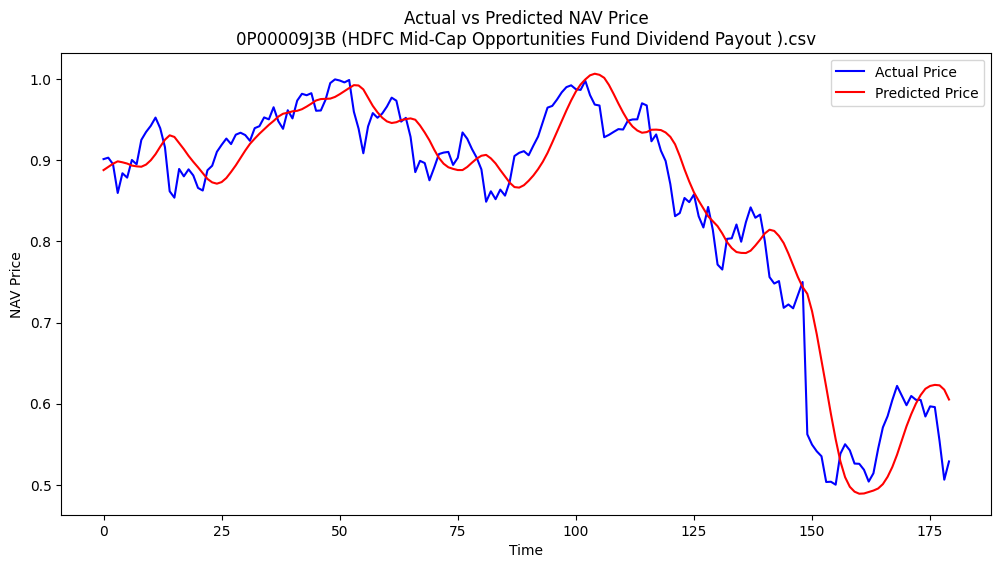


📄 Working on file: 0P0000XW8A (Hdfc Liquid Fund).csv
              Price
Date               
2021-05-14  1027.82
2021-05-16  1028.00
2021-05-17  1028.09
2021-05-18  1028.18
2021-05-19  1028.26
X shape: (1126, 60, 1)
y shape: (1126,)
X_train shape: (900, 60, 1), X_test shape: (226, 60, 1)
y_train shape: (900,), y_test shape: (226,)
Epoch 1/20


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


29/29 ━━━━━━━━━━━━━━━━━━━━ 6s 63ms/step - loss: 0.0627 - val_loss: 0.0511
Epoch 2/20
29/29 ━━━━━━━━━━━━━━━━━━━━ 1s 44ms/step - loss: 0.0280 - val_loss: 0.0441
Epoch 3/20
29/29 ━━━━━━━━━━━━━━━━━━━━ 1s 45ms/step - loss: 0.0275 - val_loss: 0.0344
Epoch 4/20
29/29 ━━━━━━━━━━━━━━━━━━━━ 1s 45ms/step - loss: 0.0231 - val_loss: 0.0255
Epoch 5/20
29/29 ━━━━━━━━━━━━━━━━━━━━ 1s 44ms/step - loss: 0.0192 - val_loss: 0.0292
Epoch 6/20
29/29 ━━━━━━━━━━━━━━━━━━━━ 1s 44ms/step - loss: 0.0176 - val_loss: 0.0241
Epoch 7/20
29/29 ━━━━━━━━━━━━━━━━━━━━ 1s 44ms/step - loss: 0.0175 - val_loss: 0.0235
Epoch 8/20
29/29 ━━━━━━━━━━━━━━━━━━━━ 1s 43ms/step - loss: 0.0151 - val_loss: 0.0223
Epoch 9/20
29/29 ━━━━━━━━━━━━━━━━━━━━ 1s 44ms/step - loss: 0.0157 - val_loss: 0.0217
Epoch 10/20
29/29 ━━━━━━━━━━━━━━━━━━━━ 1s 44ms/step - loss: 0.0135 - val_loss: 0.0190
Epoch 11/20
29/29 ━━━━━━━━━━━━━━━━━━━━ 1s 45ms/step - loss: 0.0126 - val_loss: 0.0182
Epoch 12/20
29/29 ━━━━━━━━━━━━━━━━━━━━ 1s 44ms/step - loss: 0.0127 - val_l

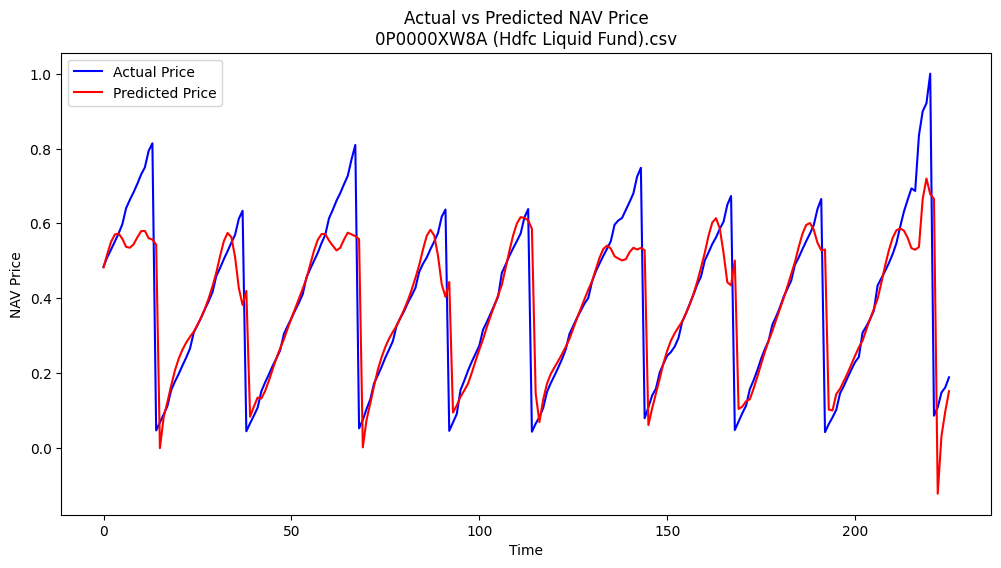


📄 Working on file: 0P00005WEY (Sbi Equity Hybrid Fund Regular Growth).csv
              Price
Date               
2021-05-14  174.422
2021-05-17  176.165
2021-05-18  178.265
2021-05-19  178.764
2021-05-20  177.703
X shape: (903, 60, 1)
y shape: (903,)
X_train shape: (722, 60, 1), X_test shape: (181, 60, 1)
y_train shape: (722,), y_test shape: (181,)
Epoch 1/20


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


23/23 ━━━━━━━━━━━━━━━━━━━━ 6s 68ms/step - loss: 0.0854 - val_loss: 0.0651
Epoch 2/20
23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 43ms/step - loss: 0.0053 - val_loss: 0.0027
Epoch 3/20
23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 44ms/step - loss: 0.0010 - val_loss: 0.0065
Epoch 4/20
23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 43ms/step - loss: 6.6987e-04 - val_loss: 0.0032
Epoch 5/20
23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 44ms/step - loss: 6.4385e-04 - val_loss: 0.0031
Epoch 6/20
23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 44ms/step - loss: 6.5497e-04 - val_loss: 0.0039
Epoch 7/20
23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 44ms/step - loss: 6.7771e-04 - val_loss: 0.0027
Epoch 8/20
23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 43ms/step - loss: 6.2409e-04 - val_loss: 0.0020
Epoch 9/20
23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 44ms/step - loss: 5.8386e-04 - val_loss: 0.0041
Epoch 10/20
23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 44ms/step - loss: 5.9152e-04 - val_loss: 0.0029
Epoch 11/20
23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 45ms/step - loss: 5.7460e-04 - val_loss: 0.0032
Epoch 12/20
23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 

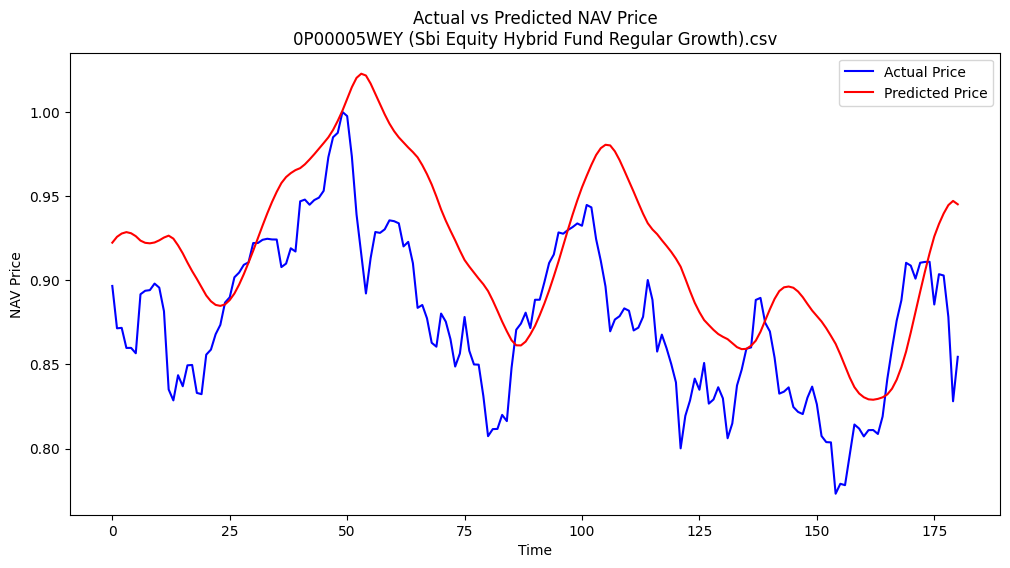


📄 Working on file: 0P00017EXB (Aditya Birla Sun Life Cash Plus Regular Dividend P ).csv
              Price
Date               
2025-03-18  138.096
2025-03-19  138.122
2025-03-20  138.151
2025-03-21  138.186
2025-03-22  138.213
❌ Error processing 0P00017EXB (Aditya Birla Sun Life Cash Plus Regular Dividend P ).csv: tuple index out of range

📄 Working on file: 0P0000XXYH (Kotak Flexicap Fund Direct Payout Of Income Distribution Cum Cap Wdrl).csv
             Price
Date              
2021-05-14  29.691
2021-05-17  30.217
2021-05-18  30.606
2021-05-19  30.556
2021-05-20  30.420
X shape: (901, 60, 1)
y shape: (901,)
X_train shape: (720, 60, 1), X_test shape: (181, 60, 1)
y_train shape: (720,), y_test shape: (181,)
Epoch 1/20


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


23/23 ━━━━━━━━━━━━━━━━━━━━ 6s 67ms/step - loss: 0.0587 - val_loss: 0.0035
Epoch 2/20
23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 44ms/step - loss: 0.0021 - val_loss: 0.0120
Epoch 3/20
23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 43ms/step - loss: 8.3949e-04 - val_loss: 0.0040
Epoch 4/20
23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 45ms/step - loss: 8.7887e-04 - val_loss: 0.0038
Epoch 5/20
23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 43ms/step - loss: 8.3138e-04 - val_loss: 0.0038
Epoch 6/20
23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 44ms/step - loss: 7.8116e-04 - val_loss: 0.0024
Epoch 7/20
23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 44ms/step - loss: 8.7644e-04 - val_loss: 0.0034
Epoch 8/20
23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 44ms/step - loss: 7.9282e-04 - val_loss: 0.0026
Epoch 9/20
23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 43ms/step - loss: 7.5932e-04 - val_loss: 0.0026
Epoch 10/20
23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 44ms/step - loss: 8.5243e-04 - val_loss: 0.0043
Epoch 11/20
23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 44ms/step - loss: 7.3576e-04 - val_loss: 0.0031
Epoch 12/20
23/23 ━━━━━━━━━━━━━━━━━━━━

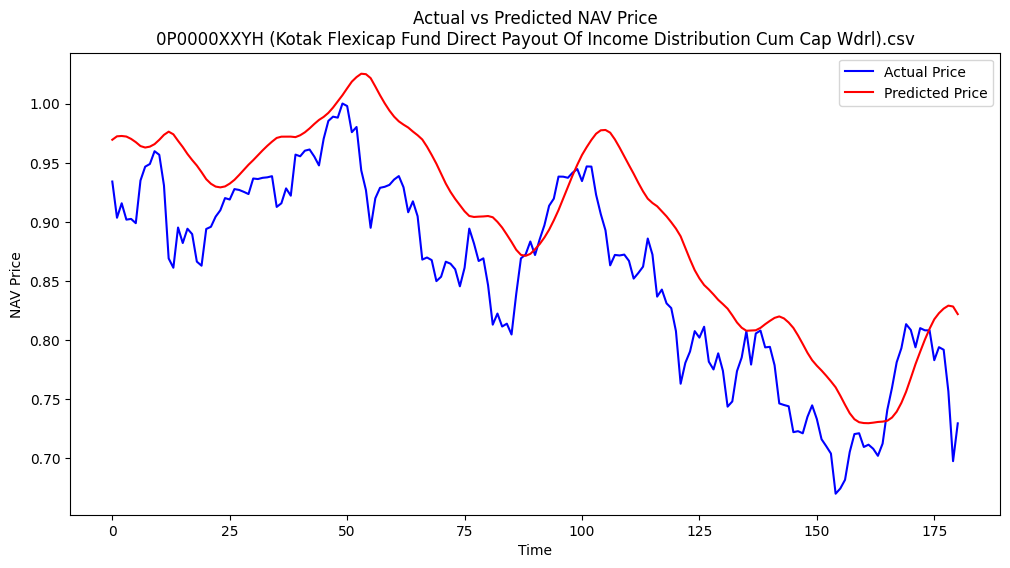


📄 Working on file: 0P00017EXB (Aditya Birla Sun Life Liquid Regular Payout Inc Dist Cum Cap Wdrl).csv
              Price
Date               
2021-05-14  138.302
2021-05-16  138.327
2021-05-17  138.340
2021-05-18  138.352
2021-05-19  138.364
X shape: (1330, 60, 1)
y shape: (1330,)
X_train shape: (1064, 60, 1), X_test shape: (266, 60, 1)
y_train shape: (1064,), y_test shape: (266,)
Epoch 1/20


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


34/34 ━━━━━━━━━━━━━━━━━━━━ 6s 62ms/step - loss: 0.1324 - val_loss: 0.0187
Epoch 2/20
34/34 ━━━━━━━━━━━━━━━━━━━━ 1s 43ms/step - loss: 0.0031 - val_loss: 0.0068
Epoch 3/20
34/34 ━━━━━━━━━━━━━━━━━━━━ 1s 43ms/step - loss: 6.8003e-04 - val_loss: 0.0064
Epoch 4/20
34/34 ━━━━━━━━━━━━━━━━━━━━ 1s 43ms/step - loss: 8.7948e-04 - val_loss: 0.0062
Epoch 5/20
34/34 ━━━━━━━━━━━━━━━━━━━━ 2s 44ms/step - loss: 7.3066e-04 - val_loss: 0.0059
Epoch 6/20
34/34 ━━━━━━━━━━━━━━━━━━━━ 1s 43ms/step - loss: 6.1733e-04 - val_loss: 0.0059
Epoch 7/20
34/34 ━━━━━━━━━━━━━━━━━━━━ 1s 43ms/step - loss: 0.0011 - val_loss: 0.0058
Epoch 8/20
34/34 ━━━━━━━━━━━━━━━━━━━━ 1s 43ms/step - loss: 6.7189e-04 - val_loss: 0.0054
Epoch 9/20
34/34 ━━━━━━━━━━━━━━━━━━━━ 2s 44ms/step - loss: 8.1491e-04 - val_loss: 0.0057
Epoch 10/20
34/34 ━━━━━━━━━━━━━━━━━━━━ 1s 43ms/step - loss: 6.7172e-04 - val_loss: 0.0055
Epoch 11/20
34/34 ━━━━━━━━━━━━━━━━━━━━ 1s 44ms/step - loss: 5.3666e-04 - val_loss: 0.0052
Epoch 12/20
34/34 ━━━━━━━━━━━━━━━━━━━━ 1s 

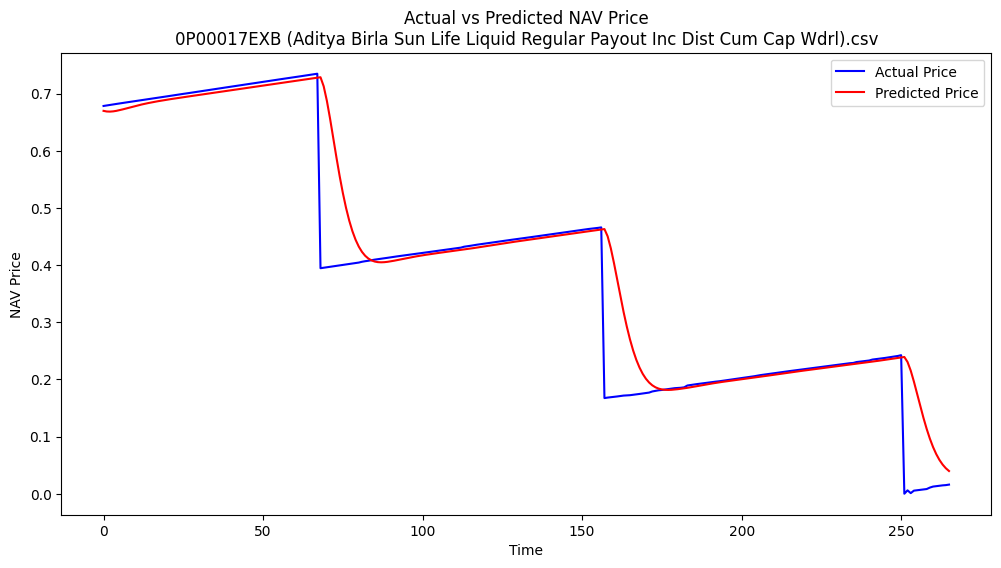


📄 Working on file: 0P0000XVJW (Sbi Focused Equity Fund Direct Plan Payout Inc Dist Cum Cap Wdrl ).csv
             Price
Date              
2021-05-14  50.199
2021-05-17  50.608
2021-05-18  51.497
2021-05-19  51.723
2021-05-20  51.339
X shape: (904, 60, 1)
y shape: (904,)
X_train shape: (723, 60, 1), X_test shape: (181, 60, 1)
y_train shape: (723,), y_test shape: (181,)
Epoch 1/20


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


23/23 ━━━━━━━━━━━━━━━━━━━━ 9s 69ms/step - loss: 0.0550 - val_loss: 0.0213
Epoch 2/20
23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 44ms/step - loss: 0.0022 - val_loss: 0.0027
Epoch 3/20
23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 44ms/step - loss: 9.4419e-04 - val_loss: 0.0037
Epoch 4/20
23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 44ms/step - loss: 8.0184e-04 - val_loss: 0.0036
Epoch 5/20
23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 45ms/step - loss: 7.3270e-04 - val_loss: 0.0027
Epoch 6/20
23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 44ms/step - loss: 7.7352e-04 - val_loss: 0.0045
Epoch 7/20
23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 44ms/step - loss: 7.4677e-04 - val_loss: 0.0032
Epoch 8/20
23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 44ms/step - loss: 7.4825e-04 - val_loss: 0.0030
Epoch 9/20
23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 44ms/step - loss: 6.1919e-04 - val_loss: 0.0021
Epoch 10/20
23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 44ms/step - loss: 6.8256e-04 - val_loss: 0.0022
Epoch 11/20
23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 44ms/step - loss: 6.3852e-04 - val_loss: 0.0021
Epoch 12/20
23/23 ━━━━━━━━━━━━━━━━━━━━

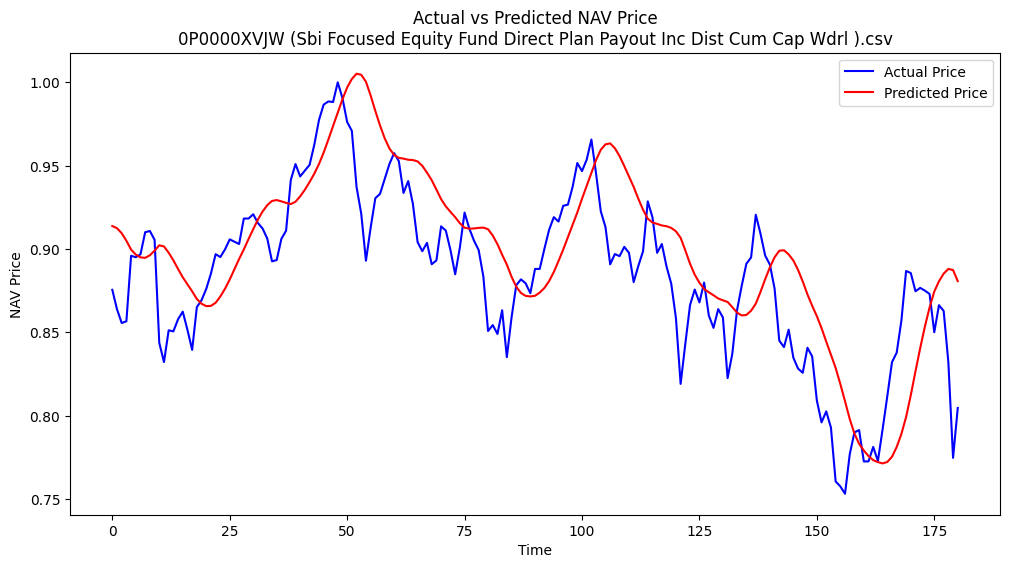


📄 Working on file: 0P00005WKZ (UTI Liquid Fund Cash Plan Institutional Growth).csv
              Price
Date               
2021-05-14  3365.66
2021-05-16  3366.25
2021-05-17  3366.54
2021-05-18  3366.84
2021-05-19  3367.11
X shape: (1343, 60, 1)
y shape: (1343,)
X_train shape: (1074, 60, 1), X_test shape: (269, 60, 1)
y_train shape: (1074,), y_test shape: (269,)
Epoch 1/20


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


34/34 ━━━━━━━━━━━━━━━━━━━━ 6s 60ms/step - loss: 0.0427 - val_loss: 7.1076e-04
Epoch 2/20
34/34 ━━━━━━━━━━━━━━━━━━━━ 2s 44ms/step - loss: 6.6021e-04 - val_loss: 0.0010
Epoch 3/20
34/34 ━━━━━━━━━━━━━━━━━━━━ 2s 44ms/step - loss: 5.3728e-05 - val_loss: 5.0775e-05
Epoch 4/20
34/34 ━━━━━━━━━━━━━━━━━━━━ 2s 44ms/step - loss: 1.8246e-05 - val_loss: 1.5784e-05
Epoch 5/20
34/34 ━━━━━━━━━━━━━━━━━━━━ 1s 44ms/step - loss: 1.1578e-05 - val_loss: 2.6121e-05
Epoch 6/20
34/34 ━━━━━━━━━━━━━━━━━━━━ 1s 43ms/step - loss: 7.2959e-06 - val_loss: 5.8788e-05
Epoch 7/20
34/34 ━━━━━━━━━━━━━━━━━━━━ 1s 43ms/step - loss: 4.5440e-06 - val_loss: 9.7412e-05
Epoch 8/20
34/34 ━━━━━━━━━━━━━━━━━━━━ 2s 44ms/step - loss: 3.0243e-06 - val_loss: 1.4656e-04
Epoch 9/20
34/34 ━━━━━━━━━━━━━━━━━━━━ 1s 43ms/step - loss: 2.5745e-06 - val_loss: 1.6927e-04
Epoch 10/20
34/34 ━━━━━━━━━━━━━━━━━━━━ 2s 44ms/step - loss: 2.0642e-06 - val_loss: 2.3083e-04
Epoch 11/20
34/34 ━━━━━━━━━━━━━━━━━━━━ 1s 43ms/step - loss: 1.9993e-06 - val_loss: 2.487

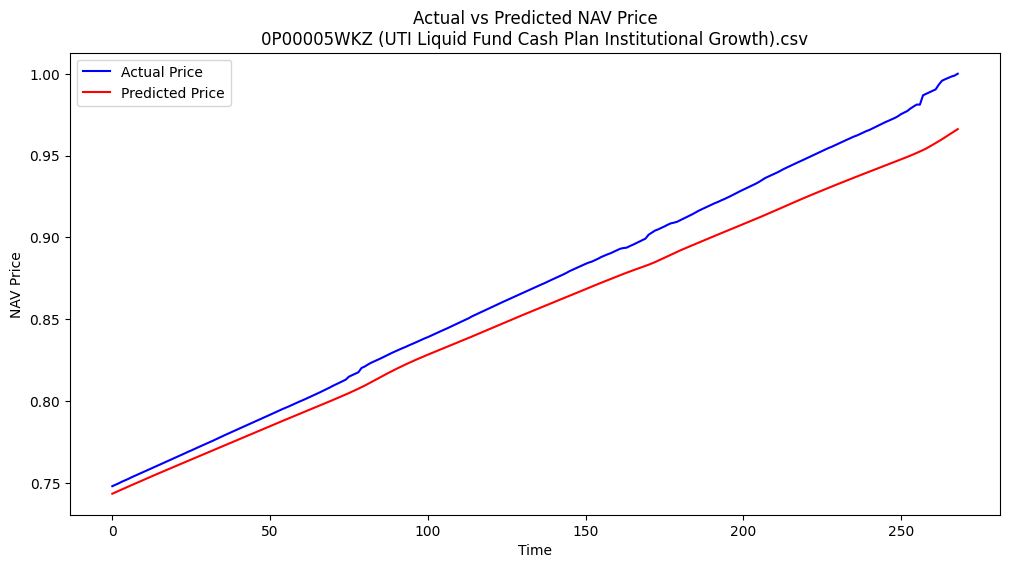


📄 Working on file: 0P0000KKEO (Aditya Birla Sun Life Liquid Discipline Advantage Plan Growth).csv
              Price
Date               
2021-05-14  222.573
2021-05-16  222.618
2021-05-17  222.641
2021-05-18  222.664
2021-05-19  222.687
X shape: (1324, 60, 1)
y shape: (1324,)
X_train shape: (1059, 60, 1), X_test shape: (265, 60, 1)
y_train shape: (1059,), y_test shape: (265,)
Epoch 1/20


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


34/34 ━━━━━━━━━━━━━━━━━━━━ 6s 59ms/step - loss: 0.0626 - val_loss: 0.0013
Epoch 2/20
34/34 ━━━━━━━━━━━━━━━━━━━━ 2s 44ms/step - loss: 0.0011 - val_loss: 7.1552e-05
Epoch 3/20
34/34 ━━━━━━━━━━━━━━━━━━━━ 2s 44ms/step - loss: 3.7692e-05 - val_loss: 9.5863e-05
Epoch 4/20
34/34 ━━━━━━━━━━━━━━━━━━━━ 1s 43ms/step - loss: 1.3375e-05 - val_loss: 1.1020e-04
Epoch 5/20
34/34 ━━━━━━━━━━━━━━━━━━━━ 2s 44ms/step - loss: 1.0011e-05 - val_loss: 1.5360e-04
Epoch 6/20
34/34 ━━━━━━━━━━━━━━━━━━━━ 1s 43ms/step - loss: 7.3165e-06 - val_loss: 3.0180e-04
Epoch 7/20
34/34 ━━━━━━━━━━━━━━━━━━━━ 2s 44ms/step - loss: 5.6311e-06 - val_loss: 2.9859e-04
Epoch 8/20
34/34 ━━━━━━━━━━━━━━━━━━━━ 2s 44ms/step - loss: 4.8216e-06 - val_loss: 4.0631e-04
Epoch 9/20
34/34 ━━━━━━━━━━━━━━━━━━━━ 2s 44ms/step - loss: 4.6249e-06 - val_loss: 4.3887e-04
Epoch 10/20
34/34 ━━━━━━━━━━━━━━━━━━━━ 2s 43ms/step - loss: 4.1121e-06 - val_loss: 5.2080e-04
Epoch 11/20
34/34 ━━━━━━━━━━━━━━━━━━━━ 2s 44ms/step - loss: 4.1442e-06 - val_loss: 5.1739e-0

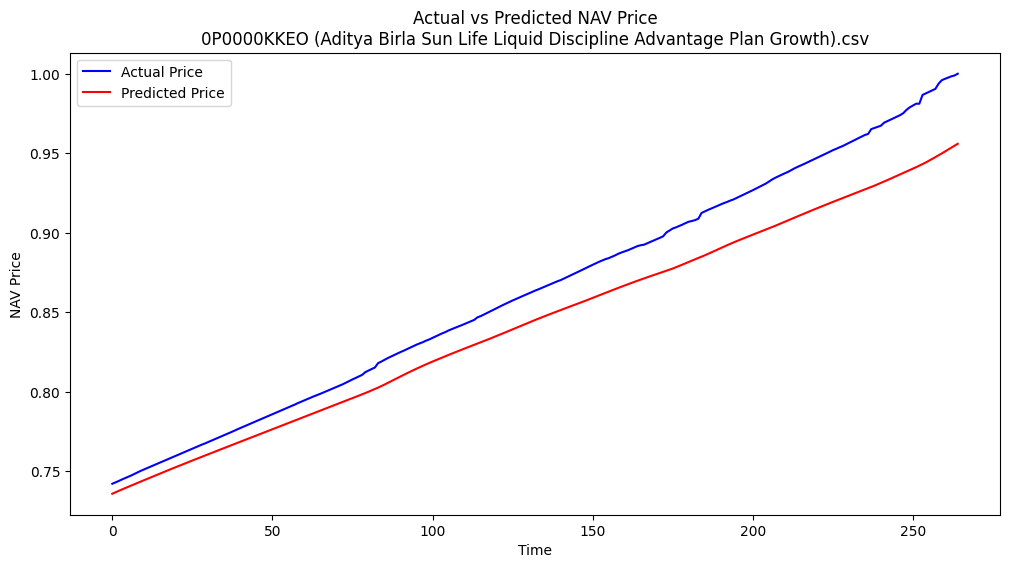


📄 Working on file: 0P0000XUYC (Icici Prudential Liquid Fund Direct Plan Growth).csv
              Price
Date               
2021-05-14  305.892
2021-05-15  305.919
2021-05-16  305.946
2021-05-17  305.973
2021-05-18  306.000
X shape: (1357, 60, 1)
y shape: (1357,)
X_train shape: (1085, 60, 1), X_test shape: (272, 60, 1)
y_train shape: (1085,), y_test shape: (272,)
Epoch 1/20


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


34/34 ━━━━━━━━━━━━━━━━━━━━ 6s 59ms/step - loss: 0.0794 - val_loss: 0.0010
Epoch 2/20
34/34 ━━━━━━━━━━━━━━━━━━━━ 2s 44ms/step - loss: 5.9805e-04 - val_loss: 9.4845e-05
Epoch 3/20
34/34 ━━━━━━━━━━━━━━━━━━━━ 2s 44ms/step - loss: 3.4825e-05 - val_loss: 6.5996e-05
Epoch 4/20
34/34 ━━━━━━━━━━━━━━━━━━━━ 2s 44ms/step - loss: 6.1663e-06 - val_loss: 1.3910e-04
Epoch 5/20
34/34 ━━━━━━━━━━━━━━━━━━━━ 2s 44ms/step - loss: 3.8679e-06 - val_loss: 1.9422e-04
Epoch 6/20
34/34 ━━━━━━━━━━━━━━━━━━━━ 1s 43ms/step - loss: 3.2624e-06 - val_loss: 2.3967e-04
Epoch 7/20
34/34 ━━━━━━━━━━━━━━━━━━━━ 2s 44ms/step - loss: 2.9901e-06 - val_loss: 2.5086e-04
Epoch 8/20
34/34 ━━━━━━━━━━━━━━━━━━━━ 2s 44ms/step - loss: 2.7277e-06 - val_loss: 3.0121e-04
Epoch 9/20
34/34 ━━━━━━━━━━━━━━━━━━━━ 2s 44ms/step - loss: 2.5122e-06 - val_loss: 3.0786e-04
Epoch 10/20
34/34 ━━━━━━━━━━━━━━━━━━━━ 2s 44ms/step - loss: 2.5832e-06 - val_loss: 3.0173e-04
Epoch 11/20
34/34 ━━━━━━━━━━━━━━━━━━━━ 1s 43ms/step - loss: 2.5355e-06 - val_loss: 3.057

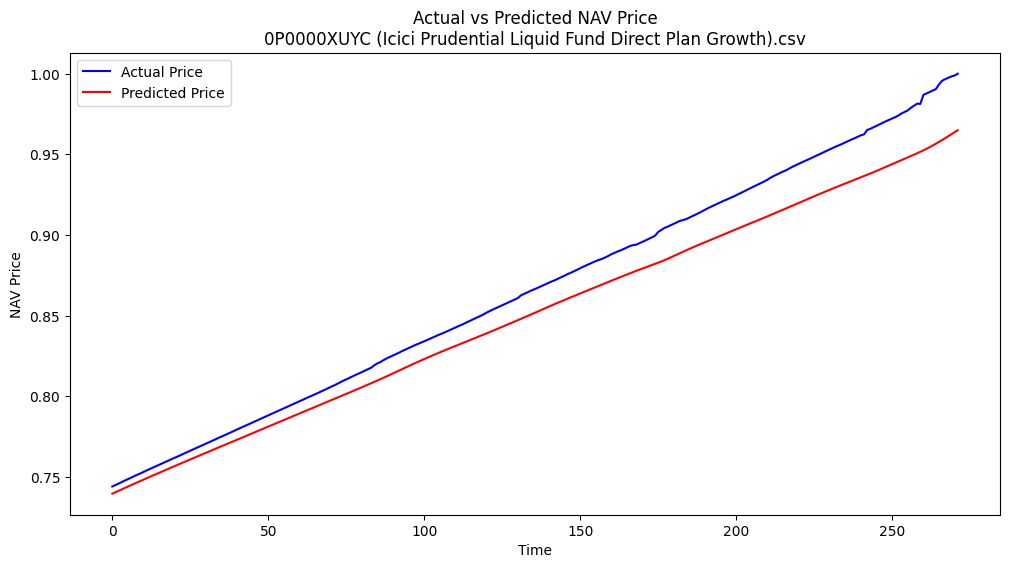


📄 Working on file: 0P0000XVJJ (Sbi Equity Hybrid Fund Direct Payout Inc Dist Cum Cap Wdrl).csv
             Price
Date              
2021-05-14  54.789
2021-05-17  55.340
2021-05-18  56.001
2021-05-19  56.159
2021-05-20  55.827
X shape: (904, 60, 1)
y shape: (904,)
X_train shape: (723, 60, 1), X_test shape: (181, 60, 1)
y_train shape: (723,), y_test shape: (181,)
Epoch 1/20


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


23/23 ━━━━━━━━━━━━━━━━━━━━ 6s 67ms/step - loss: 0.0447 - val_loss: 0.0130
Epoch 2/20
23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 44ms/step - loss: 0.0024 - val_loss: 0.0019
Epoch 3/20
23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 44ms/step - loss: 7.5691e-04 - val_loss: 0.0037
Epoch 4/20
23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 44ms/step - loss: 5.9970e-04 - val_loss: 0.0019
Epoch 5/20
23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 44ms/step - loss: 6.1387e-04 - val_loss: 0.0028
Epoch 6/20
23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 44ms/step - loss: 6.1911e-04 - val_loss: 0.0015
Epoch 7/20
23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 44ms/step - loss: 6.0855e-04 - val_loss: 0.0033
Epoch 8/20
23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 44ms/step - loss: 7.0785e-04 - val_loss: 0.0030
Epoch 9/20
23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 45ms/step - loss: 5.3762e-04 - val_loss: 0.0018
Epoch 10/20
23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 44ms/step - loss: 5.7211e-04 - val_loss: 0.0027
Epoch 11/20
23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 44ms/step - loss: 5.2505e-04 - val_loss: 0.0032
Epoch 12/20
23/23 ━━━━━━━━━━━━━━━━━━━━

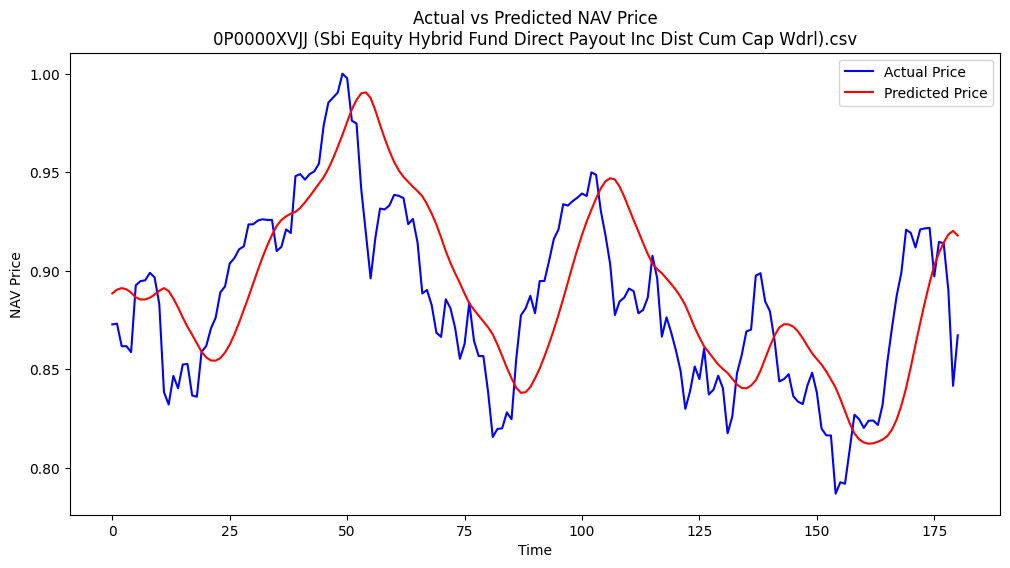


📄 Working on file: 0P00005WF0 (Sbi Bluechip Fund Regular Growth ).csv
             Price
Date              
2021-05-14  51.308
2021-05-17  52.141
2021-05-18  52.809
2021-05-19  52.707
2021-05-20  52.468
X shape: (902, 60, 1)
y shape: (902,)
X_train shape: (721, 60, 1), X_test shape: (181, 60, 1)
y_train shape: (721,), y_test shape: (181,)
Epoch 1/20


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


23/23 ━━━━━━━━━━━━━━━━━━━━ 6s 67ms/step - loss: 0.0668 - val_loss: 0.0424
Epoch 2/20
23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 43ms/step - loss: 0.0033 - val_loss: 0.0017
Epoch 3/20
23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 45ms/step - loss: 9.7947e-04 - val_loss: 0.0034
Epoch 4/20
23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 43ms/step - loss: 8.5262e-04 - val_loss: 0.0019
Epoch 5/20
23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 44ms/step - loss: 8.6480e-04 - val_loss: 0.0024
Epoch 6/20
23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 43ms/step - loss: 7.7429e-04 - val_loss: 0.0020
Epoch 7/20
23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 44ms/step - loss: 7.7607e-04 - val_loss: 0.0026
Epoch 8/20
23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 44ms/step - loss: 7.2238e-04 - val_loss: 0.0020
Epoch 9/20
23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 44ms/step - loss: 7.1644e-04 - val_loss: 0.0020
Epoch 10/20
23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 44ms/step - loss: 6.6037e-04 - val_loss: 0.0016
Epoch 11/20
23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 44ms/step - loss: 6.6335e-04 - val_loss: 0.0021
Epoch 12/20
23/23 ━━━━━━━━━━━━━━━━━━━━

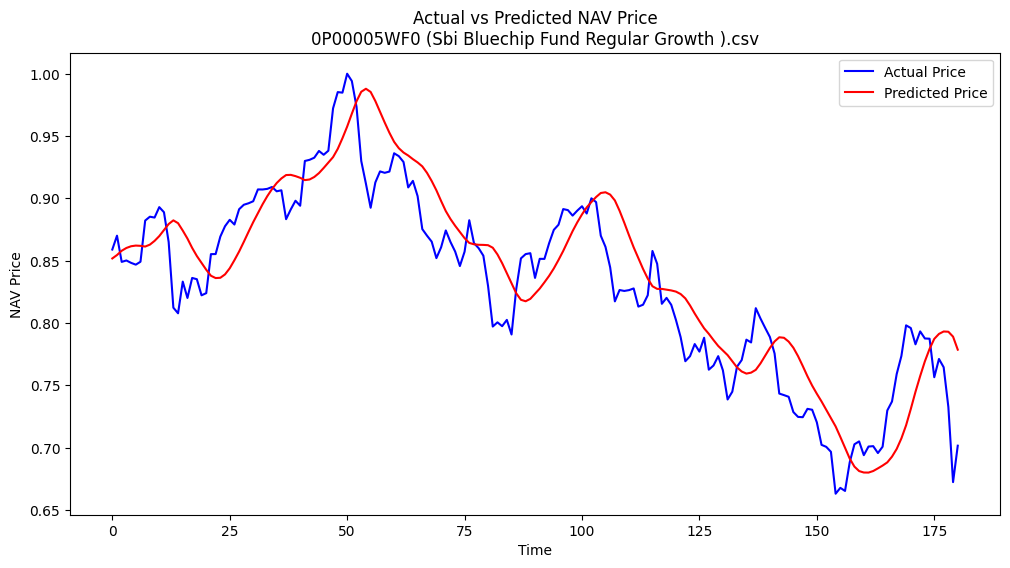


📄 Working on file: 0P0000XVA0 (Mirae Asset Large Cap Fund Direct Plan Growth).csv
             Price
Date              
2021-05-14  70.572
2021-05-17  71.682
2021-05-18  72.534
2021-05-19  72.401
2021-05-20  71.959
X shape: (902, 60, 1)
y shape: (902,)
X_train shape: (721, 60, 1), X_test shape: (181, 60, 1)
y_train shape: (721,), y_test shape: (181,)
Epoch 1/20


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


23/23 ━━━━━━━━━━━━━━━━━━━━ 6s 68ms/step - loss: 0.0407 - val_loss: 0.0067
Epoch 2/20
23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 44ms/step - loss: 0.0026 - val_loss: 0.0034
Epoch 3/20
23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 44ms/step - loss: 0.0012 - val_loss: 0.0033
Epoch 4/20
23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 44ms/step - loss: 9.5494e-04 - val_loss: 0.0026
Epoch 5/20
23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 45ms/step - loss: 8.7142e-04 - val_loss: 0.0045
Epoch 6/20
23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 45ms/step - loss: 8.6963e-04 - val_loss: 0.0033
Epoch 7/20
23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 44ms/step - loss: 7.5666e-04 - val_loss: 0.0031
Epoch 8/20
23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 44ms/step - loss: 8.6485e-04 - val_loss: 0.0039
Epoch 9/20
23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 44ms/step - loss: 8.4040e-04 - val_loss: 0.0035
Epoch 10/20
23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 43ms/step - loss: 8.1076e-04 - val_loss: 0.0046
Epoch 11/20
23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 44ms/step - loss: 8.1760e-04 - val_loss: 0.0022
Epoch 12/20
23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 

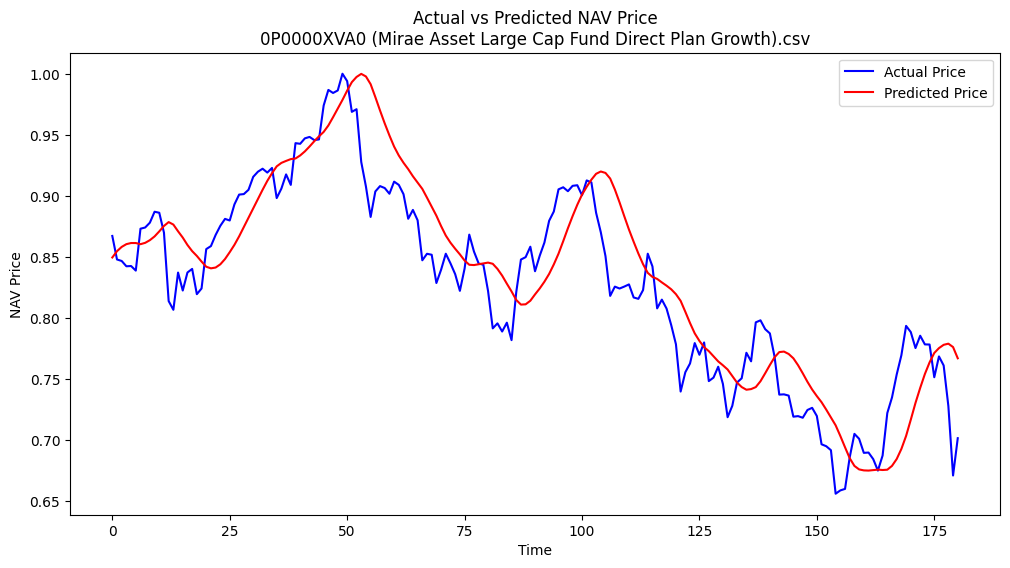


📄 Working on file: 0P0000XVTL (Axis Bluechip Fund Direct Plan Growth).csv
            Price
Date             
2021-05-14  42.66
2021-05-17  43.35
2021-05-18  44.04
2021-05-19  43.82
2021-05-20  43.52
X shape: (904, 60, 1)
y shape: (904,)
X_train shape: (723, 60, 1), X_test shape: (181, 60, 1)
y_train shape: (723,), y_test shape: (181,)
Epoch 1/20


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


23/23 ━━━━━━━━━━━━━━━━━━━━ 6s 69ms/step - loss: 0.0555 - val_loss: 0.0204
Epoch 2/20
23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 46ms/step - loss: 0.0038 - val_loss: 0.0039
Epoch 3/20
23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 45ms/step - loss: 0.0015 - val_loss: 0.0062
Epoch 4/20
23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 45ms/step - loss: 0.0013 - val_loss: 0.0036
Epoch 5/20
23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 45ms/step - loss: 0.0013 - val_loss: 0.0038
Epoch 6/20
23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 44ms/step - loss: 0.0011 - val_loss: 0.0032
Epoch 7/20
23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 44ms/step - loss: 0.0011 - val_loss: 0.0047
Epoch 8/20
23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 44ms/step - loss: 0.0011 - val_loss: 0.0044
Epoch 9/20
23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 45ms/step - loss: 0.0012 - val_loss: 0.0065
Epoch 10/20
23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 45ms/step - loss: 0.0011 - val_loss: 0.0030
Epoch 11/20
23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 45ms/step - loss: 0.0010 - val_loss: 0.0021
Epoch 12/20
23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 45ms/step - loss: 0.0010 - val_l

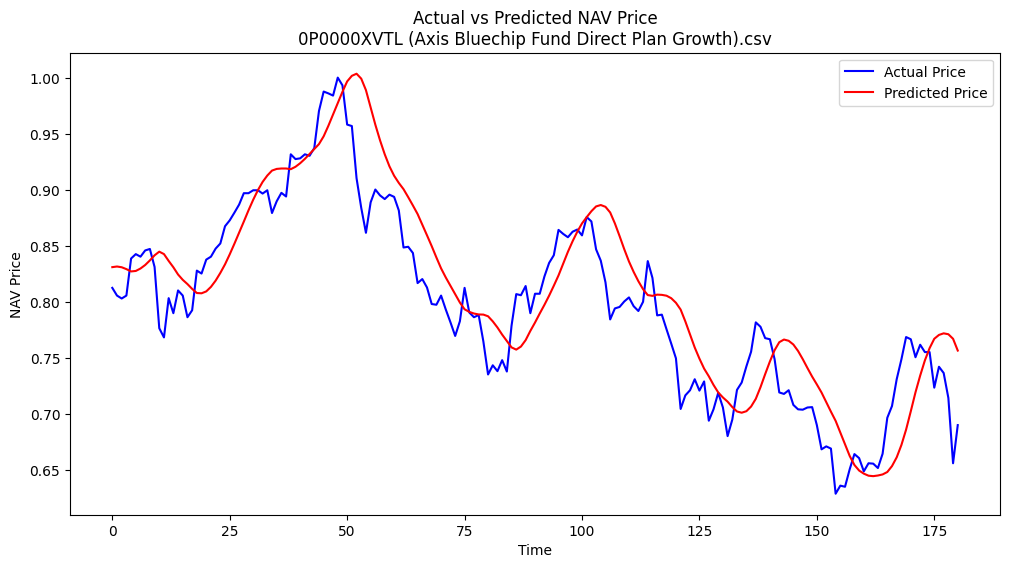


📄 Working on file: 0P00008TN3 (Icici Prudential Balanced Advantage Fund Payout Of Inc Dist Cum Cap Wdrl).csv
            Price
Date             
2021-05-14  16.74
2021-05-17  16.87
2021-05-18  16.97
2021-05-19  16.97
2021-05-20  16.92
X shape: (958, 60, 1)
y shape: (958,)
X_train shape: (766, 60, 1), X_test shape: (192, 60, 1)
y_train shape: (766,), y_test shape: (192,)
Epoch 1/20


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


24/24 ━━━━━━━━━━━━━━━━━━━━ 6s 65ms/step - loss: 0.0506 - val_loss: 0.0177
Epoch 2/20
24/24 ━━━━━━━━━━━━━━━━━━━━ 1s 44ms/step - loss: 0.0061 - val_loss: 0.0092
Epoch 3/20
24/24 ━━━━━━━━━━━━━━━━━━━━ 1s 44ms/step - loss: 0.0050 - val_loss: 0.0083
Epoch 4/20
24/24 ━━━━━━━━━━━━━━━━━━━━ 1s 44ms/step - loss: 0.0043 - val_loss: 0.0057
Epoch 5/20
24/24 ━━━━━━━━━━━━━━━━━━━━ 1s 44ms/step - loss: 0.0038 - val_loss: 0.0050
Epoch 6/20
24/24 ━━━━━━━━━━━━━━━━━━━━ 1s 44ms/step - loss: 0.0030 - val_loss: 0.0041
Epoch 7/20
24/24 ━━━━━━━━━━━━━━━━━━━━ 1s 46ms/step - loss: 0.0028 - val_loss: 0.0081
Epoch 8/20
24/24 ━━━━━━━━━━━━━━━━━━━━ 1s 44ms/step - loss: 0.0036 - val_loss: 0.0041
Epoch 9/20
24/24 ━━━━━━━━━━━━━━━━━━━━ 1s 44ms/step - loss: 0.0036 - val_loss: 0.0038
Epoch 10/20
24/24 ━━━━━━━━━━━━━━━━━━━━ 1s 44ms/step - loss: 0.0028 - val_loss: 0.0036
Epoch 11/20
24/24 ━━━━━━━━━━━━━━━━━━━━ 1s 44ms/step - loss: 0.0026 - val_loss: 0.0061
Epoch 12/20
24/24 ━━━━━━━━━━━━━━━━━━━━ 1s 44ms/step - loss: 0.0029 - val_l

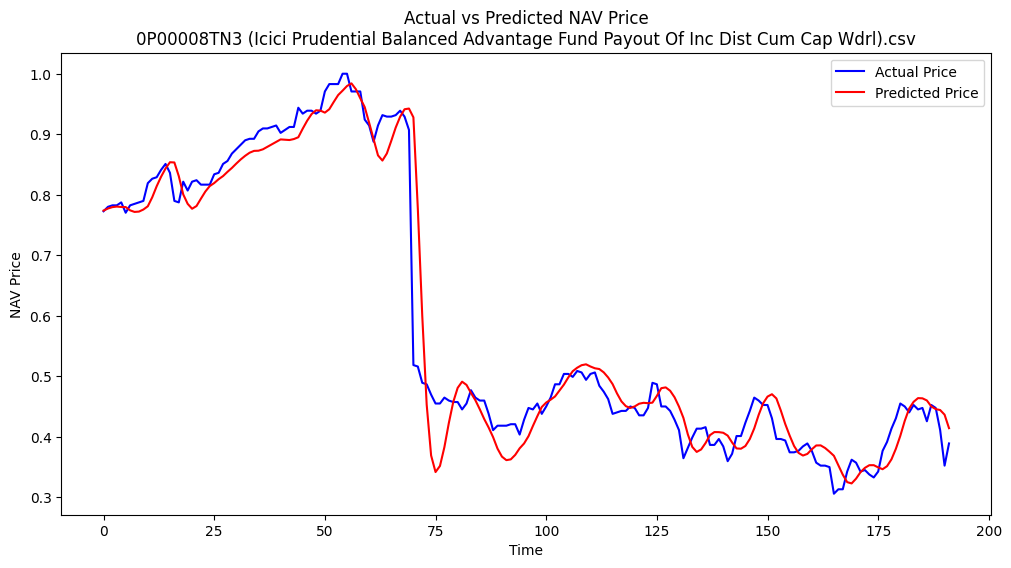


📄 Working on file: 0P0000N0B5 (Axis Elss Tax Saver Fund Growth).csv
             Price
Date              
2021-05-14  60.869
2021-05-17  61.628
2021-05-18  62.851
2021-05-19  62.592
2021-05-20  62.309
X shape: (902, 60, 1)
y shape: (902,)
X_train shape: (721, 60, 1), X_test shape: (181, 60, 1)
y_train shape: (721,), y_test shape: (181,)
Epoch 1/20


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


23/23 ━━━━━━━━━━━━━━━━━━━━ 6s 69ms/step - loss: 0.0373 - val_loss: 0.0024
Epoch 2/20
23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 44ms/step - loss: 0.0027 - val_loss: 0.0054
Epoch 3/20
23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 48ms/step - loss: 0.0016 - val_loss: 0.0032
Epoch 4/20
23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 51ms/step - loss: 0.0015 - val_loss: 0.0029
Epoch 5/20
23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 46ms/step - loss: 0.0014 - val_loss: 0.0031
Epoch 6/20
23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 44ms/step - loss: 0.0013 - val_loss: 0.0029
Epoch 7/20
23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 44ms/step - loss: 0.0013 - val_loss: 0.0055
Epoch 8/20
23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 44ms/step - loss: 0.0013 - val_loss: 0.0018
Epoch 9/20
23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 44ms/step - loss: 0.0012 - val_loss: 0.0018
Epoch 10/20
23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 45ms/step - loss: 0.0013 - val_loss: 0.0032
Epoch 11/20
23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 44ms/step - loss: 0.0010 - val_loss: 0.0016
Epoch 12/20
23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 44ms/step - loss: 0.0011 - val_l

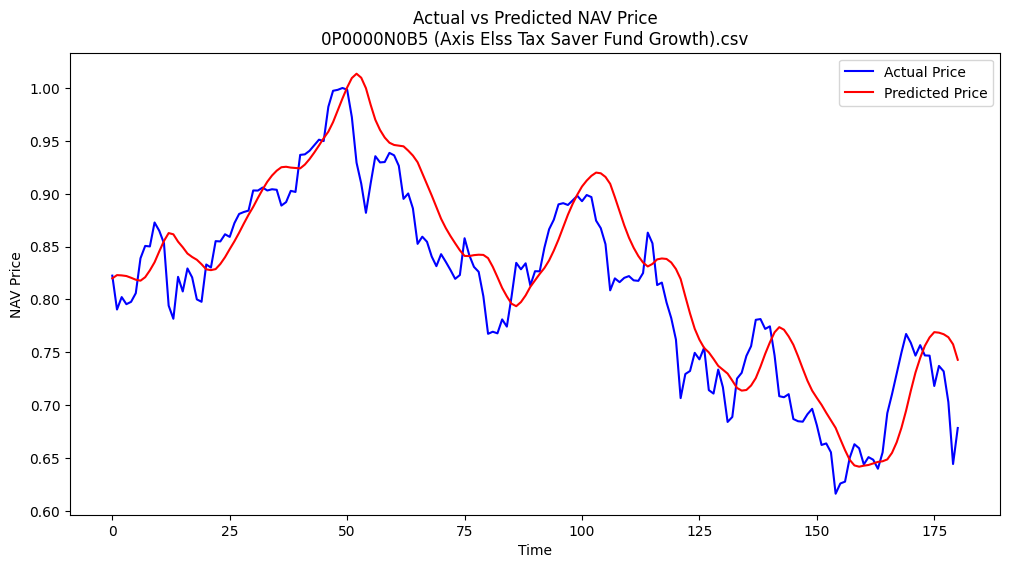


📄 Working on file: 0P0000XVT7 (UTI Liquid Fund - Cash Plan ).csv
              Price
Date               
2021-05-14  3383.42
2021-05-16  3384.03
2021-05-17  3384.34
2021-05-18  3384.64
2021-05-19  3384.92
X shape: (1344, 60, 1)
y shape: (1344,)
X_train shape: (1075, 60, 1), X_test shape: (269, 60, 1)
y_train shape: (1075,), y_test shape: (269,)
Epoch 1/20


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


34/34 ━━━━━━━━━━━━━━━━━━━━ 6s 59ms/step - loss: 0.0560 - val_loss: 1.5740e-04
Epoch 2/20
34/34 ━━━━━━━━━━━━━━━━━━━━ 2s 44ms/step - loss: 7.1784e-04 - val_loss: 8.6589e-05
Epoch 3/20
34/34 ━━━━━━━━━━━━━━━━━━━━ 1s 43ms/step - loss: 1.8202e-05 - val_loss: 1.7362e-04
Epoch 4/20
34/34 ━━━━━━━━━━━━━━━━━━━━ 1s 43ms/step - loss: 4.2092e-06 - val_loss: 2.3504e-04
Epoch 5/20
34/34 ━━━━━━━━━━━━━━━━━━━━ 1s 43ms/step - loss: 3.6022e-06 - val_loss: 2.4321e-04
Epoch 6/20
34/34 ━━━━━━━━━━━━━━━━━━━━ 2s 49ms/step - loss: 3.2618e-06 - val_loss: 3.0250e-04
Epoch 7/20
34/34 ━━━━━━━━━━━━━━━━━━━━ 2s 43ms/step - loss: 2.9848e-06 - val_loss: 3.5334e-04
Epoch 8/20
34/34 ━━━━━━━━━━━━━━━━━━━━ 2s 44ms/step - loss: 3.0791e-06 - val_loss: 3.5063e-04
Epoch 9/20
34/34 ━━━━━━━━━━━━━━━━━━━━ 1s 43ms/step - loss: 3.1873e-06 - val_loss: 3.0477e-04
Epoch 10/20
34/34 ━━━━━━━━━━━━━━━━━━━━ 1s 43ms/step - loss: 2.9025e-06 - val_loss: 3.6664e-04
Epoch 11/20
34/34 ━━━━━━━━━━━━━━━━━━━━ 1s 44ms/step - loss: 2.9597e-06 - val_loss: 3

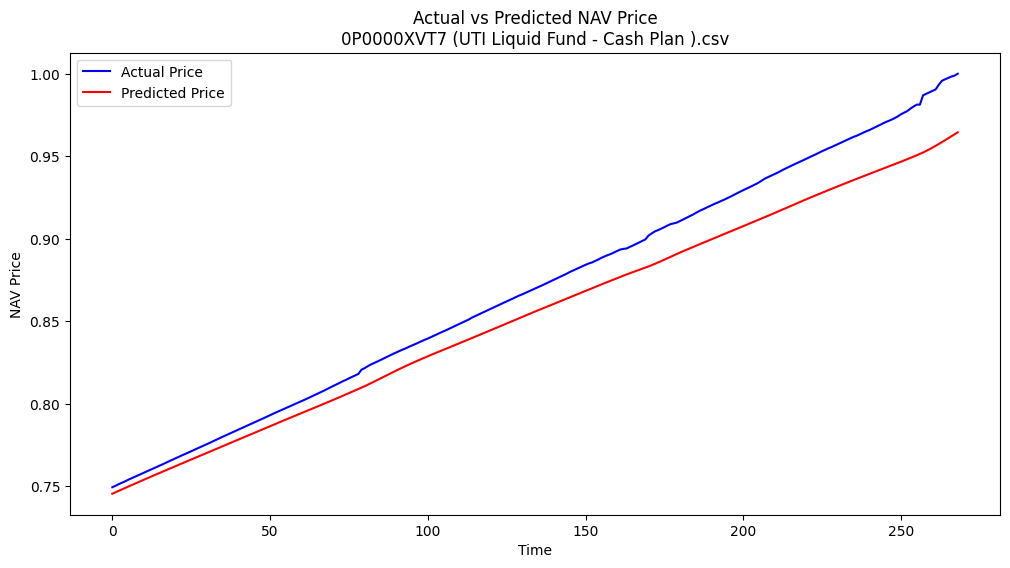


📊 0P0000YG82 (Icici Prudential Balanced Advantage Fund Direct Plan Monthly Payout Of Inc Dist Cum Cap Wdrl ).csv - Metrics:
RMSE: 0.03400894045177828
MAE: 0.027756847166112417
R² Score: 0.639587102586161

📊 0P00005V09 (Hdfc Liquid Fund Growth).csv - Metrics:
RMSE: 0.019444148314713743
MAE: 0.01682944101742855
R² Score: 0.9264304800929569

📊 0P00005URV (Sbi Liquid Fund Institutional ).csv - Metrics:
RMSE: 0.016766074029912294
MAE: 0.01403376489126041
R² Score: 0.9486255521209019

📊 0P0001EI10 (Hdfc Balanced Advantage Fund Direct Plan Payout Inc Dist Cum Cap Wdrl Opt).csv - Metrics:
RMSE: 0.0534142270941014
MAE: 0.04789594064213141
R² Score: 0.6362226100220185

📊 0P0000YCJ0 (Aditya Birla Sun Life Liquid Direct Plan Payout Inc Dist Cum Cap Wdrl).csv - Metrics:
RMSE: 0.0640479173046475
MAE: 0.024870334311441103
R² Score: 0.9123622668727199

📊 0P0000XXYH (Kotak Flexicap Fund Direct Payout Of Income Dist. Cum Cap Wdrl).csv - Metrics:
RMSE: 0.06657460874585283
MAE: 0.05785323551177857
R² Sco

In [42]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from keras.models import Sequential
from keras.layers import LSTM, Dense
# from keras.layers import Conv1D, MaxPooling1D

# Path to your data
data_path = '/kaggle/input/mf-new-indi/data of mutual fund'

# Fetch all CSV files
all_files = [f for f in os.listdir(data_path) if f.endswith('.csv')]

print(f"Total {len(all_files)} files found!")

# Dictionary to store predictions for each fund
fund_predictions = {}

# Loop over all files
for file_name in all_files:
    print(f"\n📄 Working on file: {file_name}")

    try:
        # 1. Read the CSV
        df = pd.read_csv(os.path.join(data_path, file_name))

        # 2. Data Cleaning
        df.columns = df.columns.str.strip()  # Strip any extra spaces
        if 'Price' not in df.columns:
            print(f"⚠️ Skipped: 'Price' column missing.")
            continue
        
        # Ensure 'Price' column is treated as string before replacing commas
        df['Price'] = df['Price'].astype(str).str.replace(',', '', regex=True).astype(float)

        df['Date'] = pd.to_datetime(df['Date'], format='%d-%b-%y', errors='coerce')
        df = df.dropna(subset=['Date'])  # Drop rows where Date parsing failed
        df = df.sort_values('Date')
        
        if 'Change %' in df.columns:
            df['Change %'] = df['Change %'].str.replace('%', '', regex=True).astype(float)

        df.set_index('Date', inplace=True)
        prices = df[['Price']].copy()

        print(prices.head())

        # 3. Scaling the Prices
        scaler = MinMaxScaler(feature_range=(0, 1))
        scaled_prices = scaler.fit_transform(prices)

        # 4. Creating Sequences
        sequence_length = 60

        X = []
        y = []

        for i in range(sequence_length, len(scaled_prices)):
            X.append(scaled_prices[i-sequence_length:i, 0])
            y.append(scaled_prices[i, 0])

        X = np.array(X)
        y = np.array(y)

        X = np.reshape(X, (X.shape[0], X.shape[1], 1))

        print(f"X shape: {X.shape}")
        print(f"y shape: {y.shape}")

        # 5. Train-Test Split
        split_ratio = 0.8
        split = int(len(X) * split_ratio)

        X_train, X_test = X[:split], X[split:]
        y_train, y_test = y[:split], y[split:]

        print(f"X_train shape: {X_train.shape}, X_test shape: {X_test.shape}")
        print(f"y_train shape: {y_train.shape}, y_test shape: {y_test.shape}")

        # 6. LSTM Model
        model = Sequential()
        # model.add(Conv1D(filters=64, kernel_size=3, activation='relu', input_shape=(X_train.shape[1], 1)))
        # model.add(MaxPooling1D(pool_size=2))
        model.add(LSTM(units=50, return_sequences=True, input_shape=(X_train.shape[1], 1)))
        model.add(LSTM(units=50))
        model.add(Dense(1))

        model.compile(optimizer='adam', loss='mean_squared_error')

        # 7. Train the Model
        history = model.fit(X_train, y_train, epochs=20, batch_size=32, validation_data=(X_test, y_test), verbose=1)

        # 8. Make Predictions
        y_pred = model.predict(X_test)

        # 9. Evaluation Metrics
        rmse = np.sqrt(mean_squared_error(y_test, y_pred))
        mae = mean_absolute_error(y_test, y_pred)
        r2 = r2_score(y_test, y_pred)

        print(f"📈 Evaluation Metrics for {file_name}:")
        print(f"RMSE: {rmse}")
        print(f"MAE: {mae}")
        print(f"R² Score: {r2}")

        # 10. Store predictions individually per fund
        fund_predictions[file_name] = {
            'y_test': y_test.flatten(),
            'y_pred': y_pred.flatten(),
            'rmse': rmse,
            'mae': mae,
            'r2': r2
        }

        # 11. Plotting Actual vs Predicted for each fund
        plt.figure(figsize=(12,6))
        plt.plot(y_test, label='Actual Price', color='blue')
        plt.plot(y_pred, label='Predicted Price', color='red')
        plt.title(f'Actual vs Predicted NAV Price\n{file_name}')
        plt.xlabel('Time')
        plt.ylabel('NAV Price')
        plt.legend()
        plt.show()

    except Exception as e:
        print(f"❌ Error processing {file_name}: {e}")

# After all files processed, display the results for each fund
for fund_name, metrics in fund_predictions.items():
    print(f"\n📊 {fund_name} - Metrics:")
    print(f"RMSE: {metrics['rmse']}")
    print(f"MAE: {metrics['mae']}")
    print(f"R² Score: {metrics['r2']}")


📊 0P0000YG82 (Icici Prudential Balanced Advantage Fund Direct Plan Monthly Payout Of Inc Dist Cum Cap Wdrl ).csv Optimization Results:
  Expected Return: 0.00%
  Portfolio Risk (Volatility): 0.38%
  Optimized Weight: 1.0000



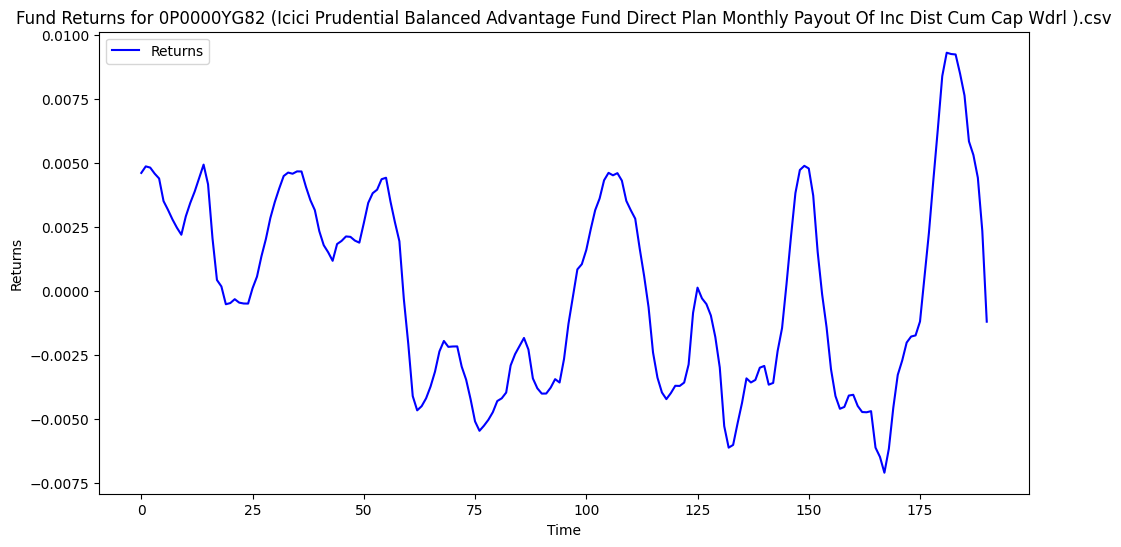

📊 0P00005V09 (Hdfc Liquid Fund Growth).csv Optimization Results:
  Expected Return: 0.10%
  Portfolio Risk (Volatility): 0.01%
  Optimized Weight: 1.0000



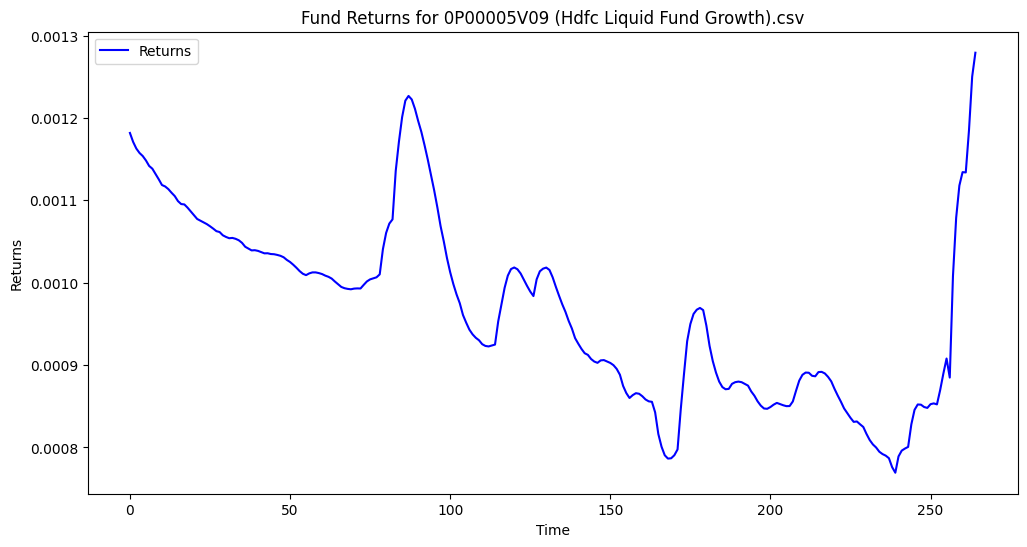

📊 0P00005URV (Sbi Liquid Fund Institutional ).csv Optimization Results:
  Expected Return: 0.15%
  Portfolio Risk (Volatility): 0.01%
  Optimized Weight: 1.0000



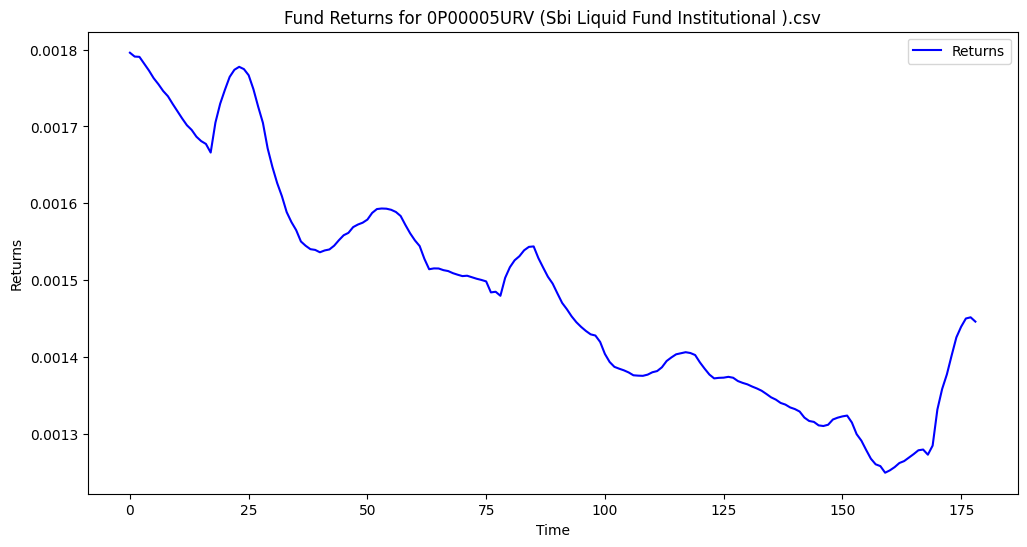

📊 0P0001EI10 (Hdfc Balanced Advantage Fund Direct Plan Payout Inc Dist Cum Cap Wdrl Opt).csv Optimization Results:
  Expected Return: -0.10%
  Portfolio Risk (Volatility): 0.43%
  Optimized Weight: 1.0000



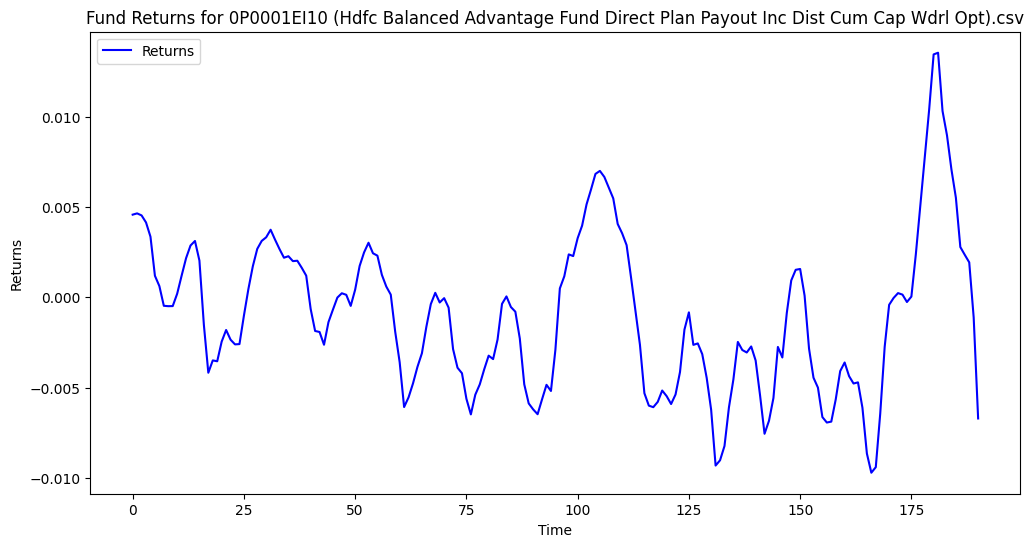

📊 0P0000YCJ0 (Aditya Birla Sun Life Liquid Direct Plan Payout Inc Dist Cum Cap Wdrl).csv Optimization Results:
  Expected Return: -1.22%
  Portfolio Risk (Volatility): 4.19%
  Optimized Weight: 1.0000



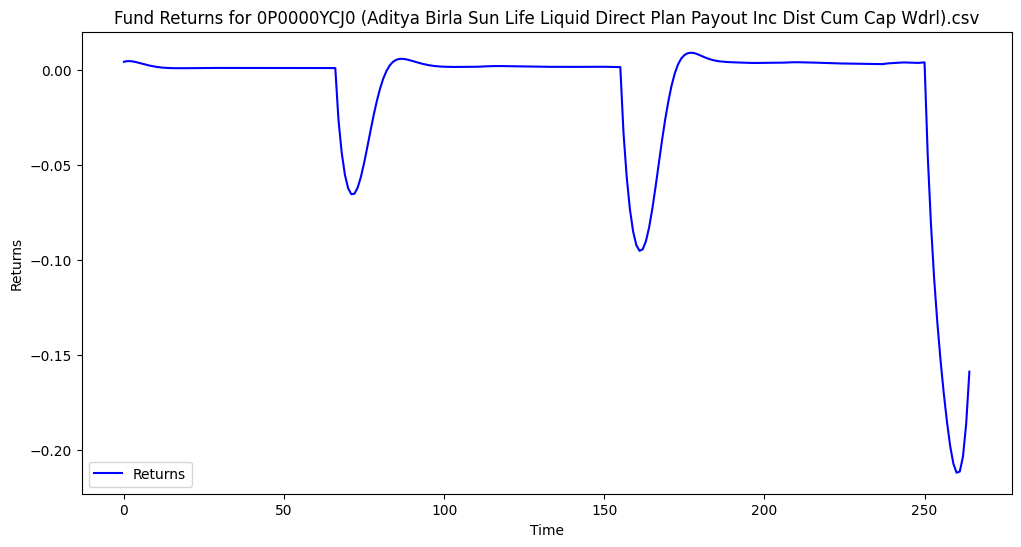

📊 0P0000XXYH (Kotak Flexicap Fund Direct Payout Of Income Dist. Cum Cap Wdrl).csv Optimization Results:
  Expected Return: -0.09%
  Portfolio Risk (Volatility): 0.63%
  Optimized Weight: 1.0000



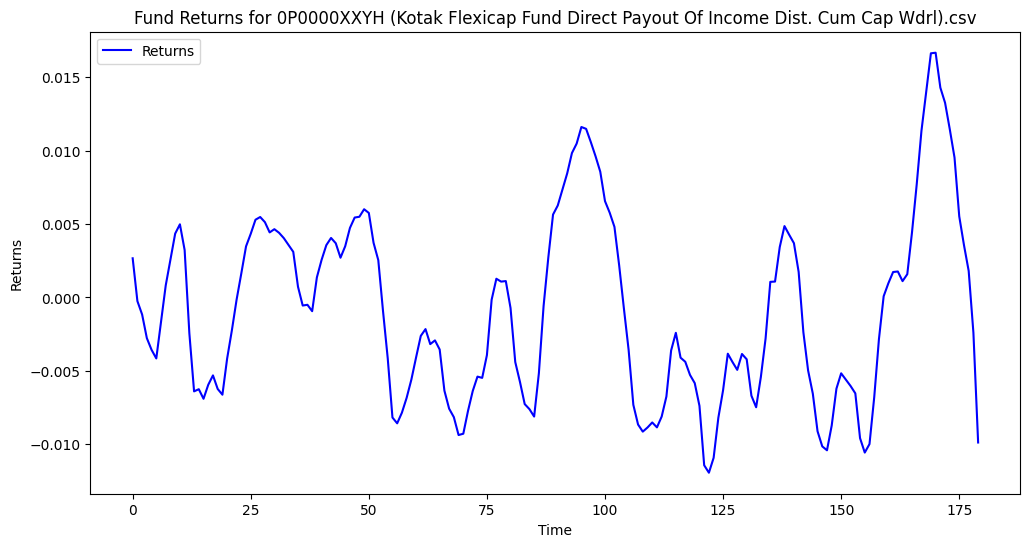

📊 0P0000XV6O (Kotak Flexicap Fund Direct Growth).csv Optimization Results:
  Expected Return: -0.09%
  Portfolio Risk (Volatility): 0.61%
  Optimized Weight: 1.0000



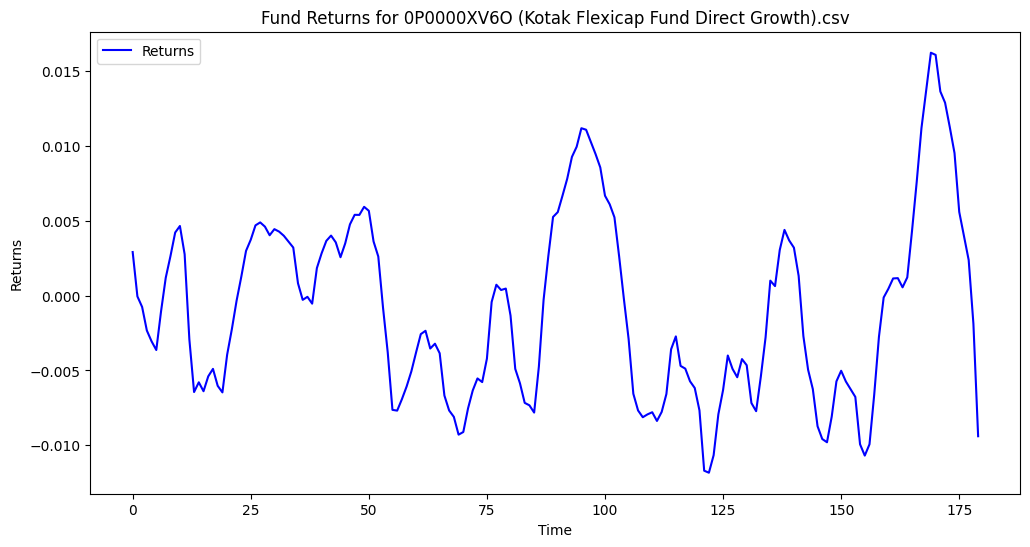

📊 0P0000NRF7 (Sbi Life - Equity Fund).csv Optimization Results:
  Expected Return: -0.07%
  Portfolio Risk (Volatility): 0.79%
  Optimized Weight: 1.0000



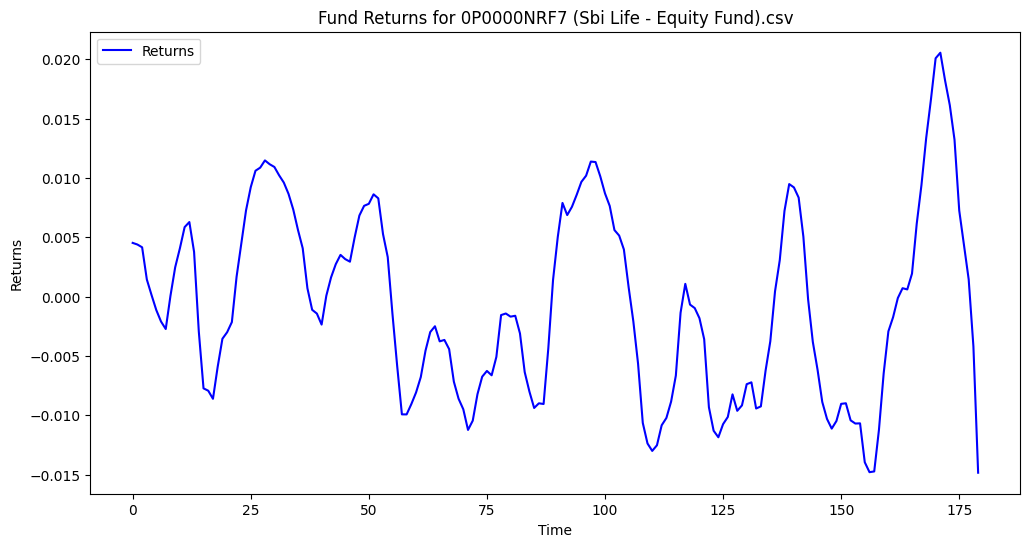

📊 0P00009J3B (HDFC Mid-Cap Opportunities Fund Dividend Payout ).csv Optimization Results:
  Expected Return: -0.21%
  Portfolio Risk (Volatility): 1.34%
  Optimized Weight: 1.0000



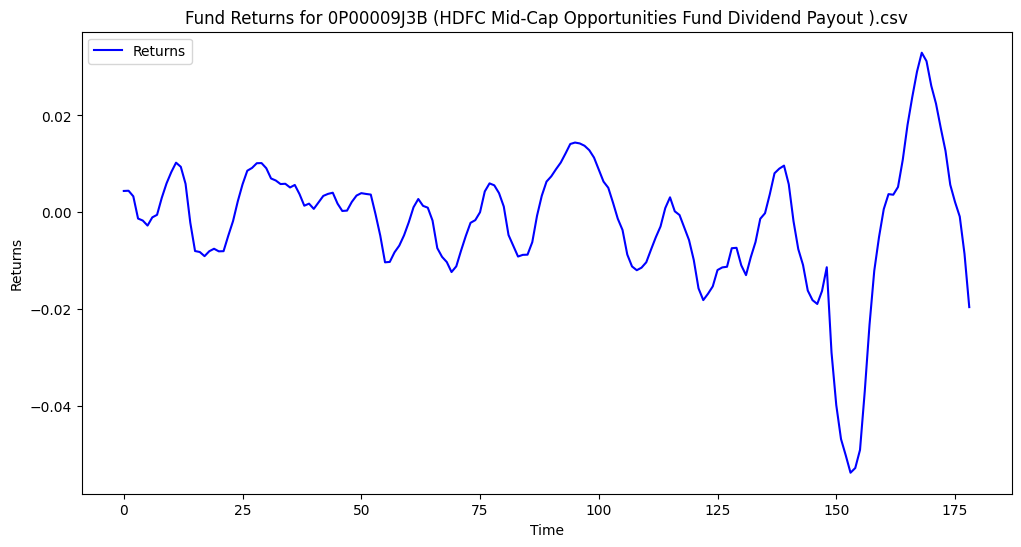

📊 0P0000XW8A (Hdfc Liquid Fund).csv Optimization Results:
  Expected Return: 716.72%
  Portfolio Risk (Volatility): 10435.61%
  Optimized Weight: 1.0000



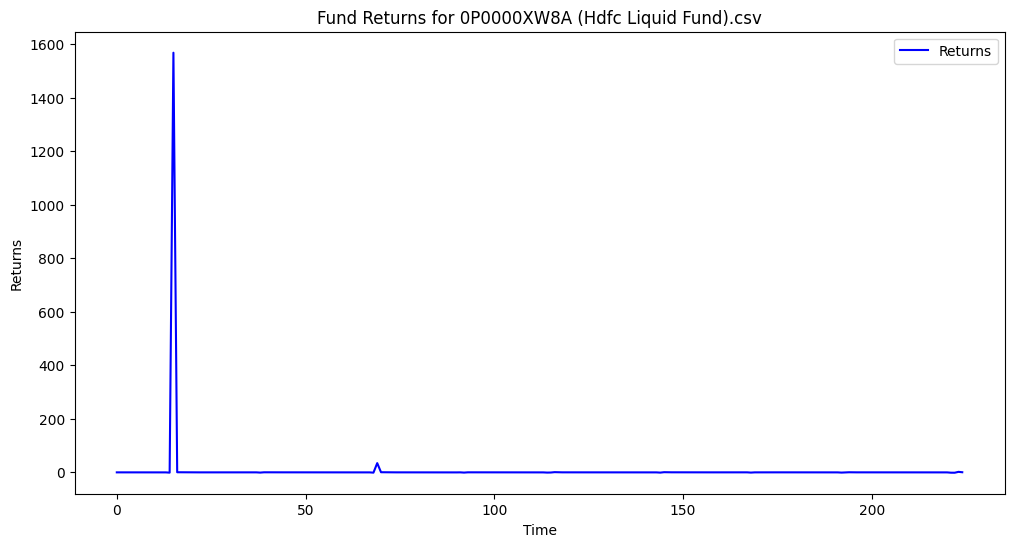

📊 0P00005WEY (Sbi Equity Hybrid Fund Regular Growth).csv Optimization Results:
  Expected Return: 0.02%
  Portfolio Risk (Volatility): 0.57%
  Optimized Weight: 1.0000



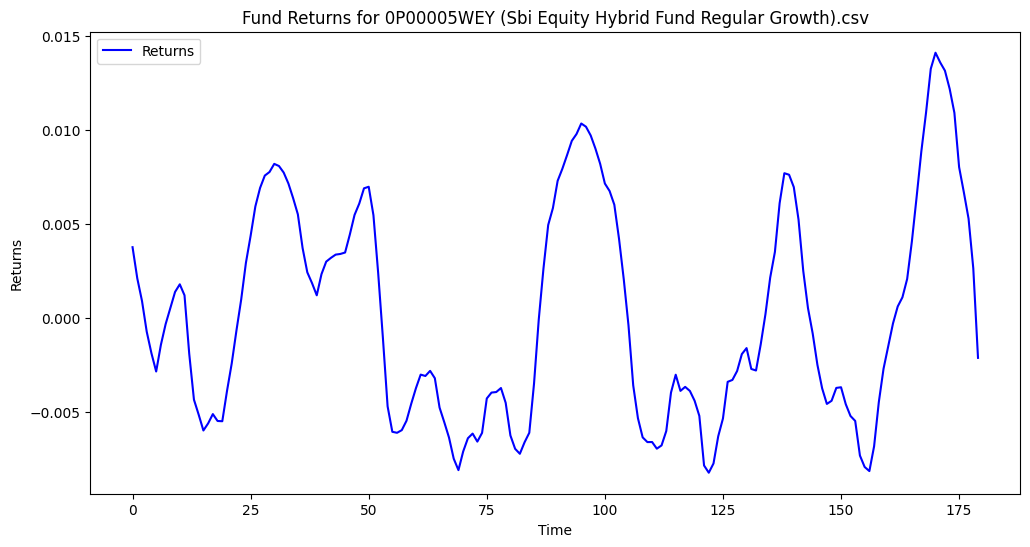

📊 0P0000XXYH (Kotak Flexicap Fund Direct Payout Of Income Distribution Cum Cap Wdrl).csv Optimization Results:
  Expected Return: -0.09%
  Portfolio Risk (Volatility): 0.59%
  Optimized Weight: 1.0000



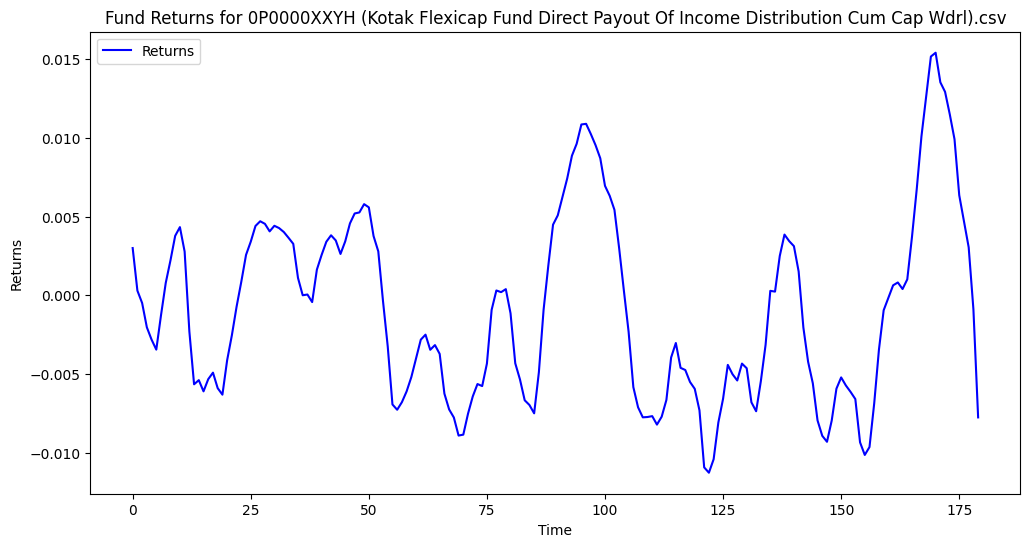

📊 0P00017EXB (Aditya Birla Sun Life Liquid Regular Payout Inc Dist Cum Cap Wdrl).csv Optimization Results:
  Expected Return: -1.01%
  Portfolio Risk (Volatility): 3.20%
  Optimized Weight: 1.0000



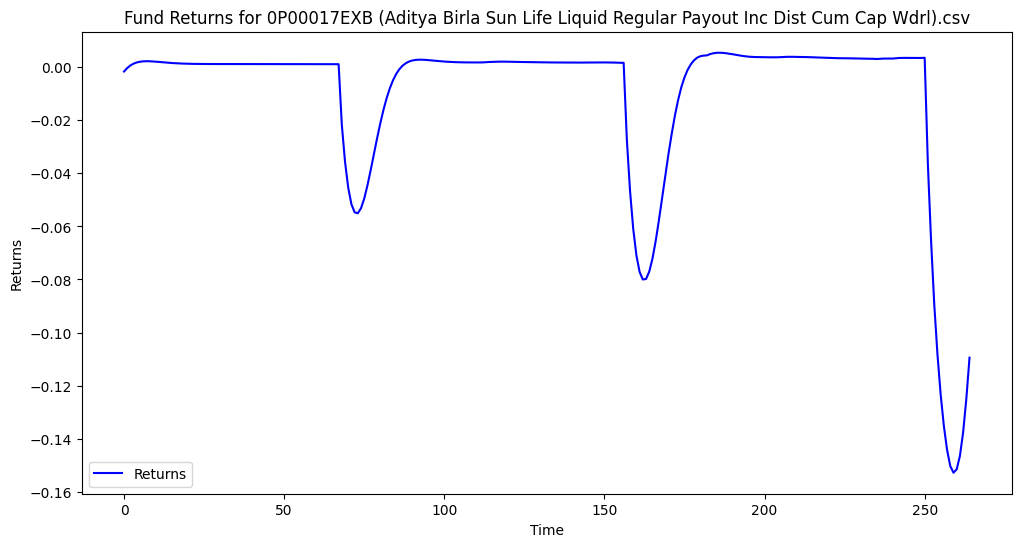

📊 0P0000XVJW (Sbi Focused Equity Fund Direct Plan Payout Inc Dist Cum Cap Wdrl ).csv Optimization Results:
  Expected Return: -0.02%
  Portfolio Risk (Volatility): 0.62%
  Optimized Weight: 1.0000



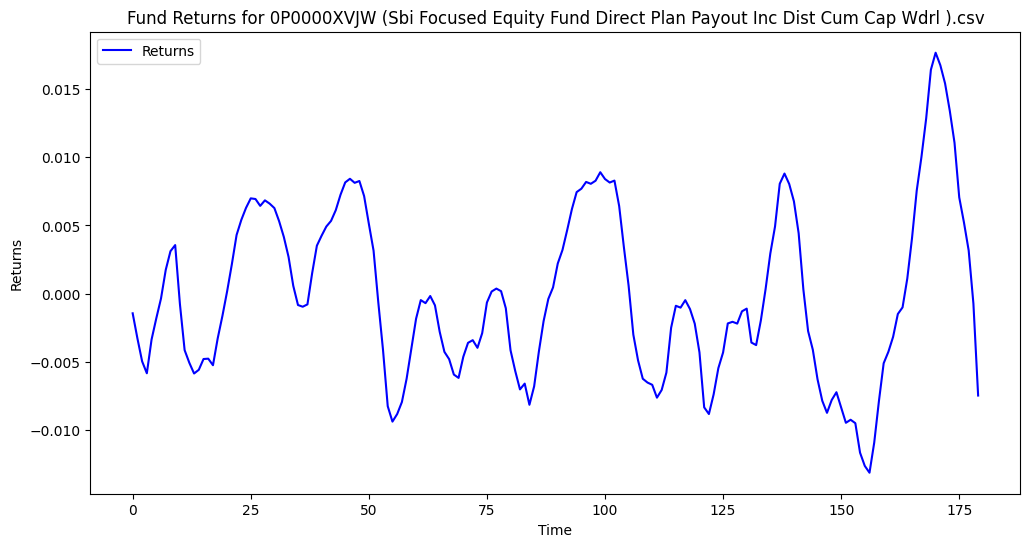

📊 0P00005WKZ (UTI Liquid Fund Cash Plan Institutional Growth).csv Optimization Results:
  Expected Return: 0.10%
  Portfolio Risk (Volatility): 0.01%
  Optimized Weight: 1.0000



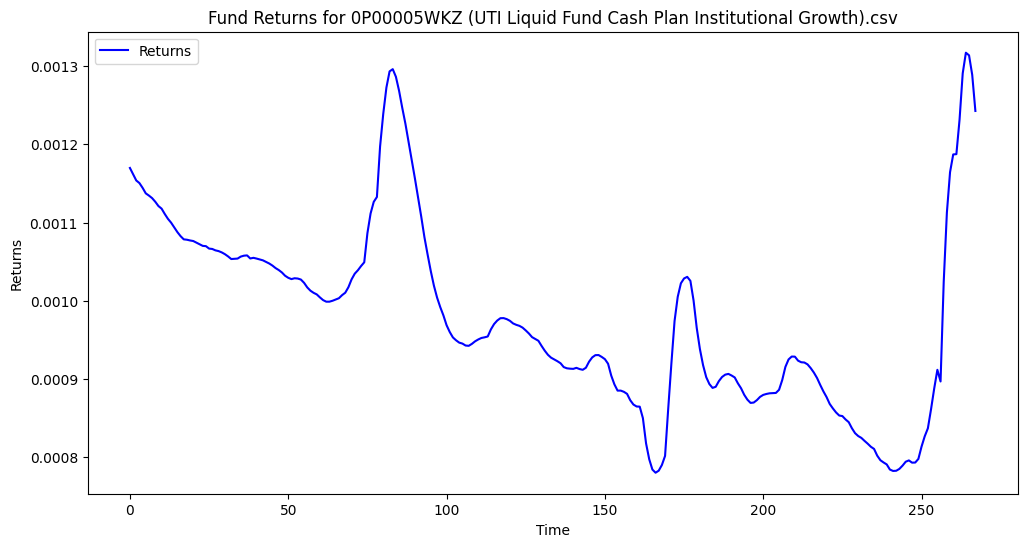

📊 0P0000KKEO (Aditya Birla Sun Life Liquid Discipline Advantage Plan Growth).csv Optimization Results:
  Expected Return: 0.10%
  Portfolio Risk (Volatility): 0.01%
  Optimized Weight: 1.0000



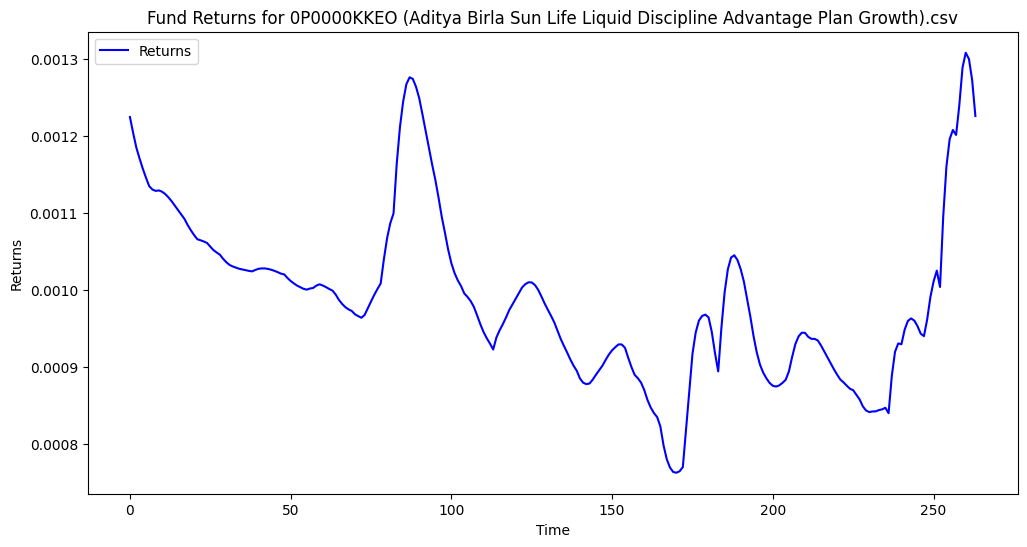

📊 0P0000XUYC (Icici Prudential Liquid Fund Direct Plan Growth).csv Optimization Results:
  Expected Return: 0.10%
  Portfolio Risk (Volatility): 0.01%
  Optimized Weight: 1.0000



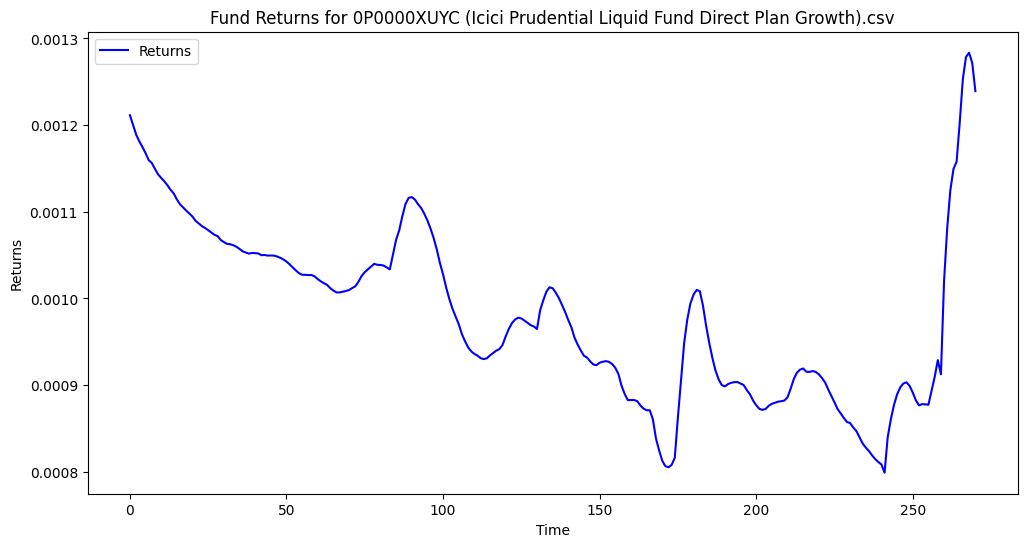

📊 0P0000XVJJ (Sbi Equity Hybrid Fund Direct Payout Inc Dist Cum Cap Wdrl).csv Optimization Results:
  Expected Return: 0.02%
  Portfolio Risk (Volatility): 0.54%
  Optimized Weight: 1.0000



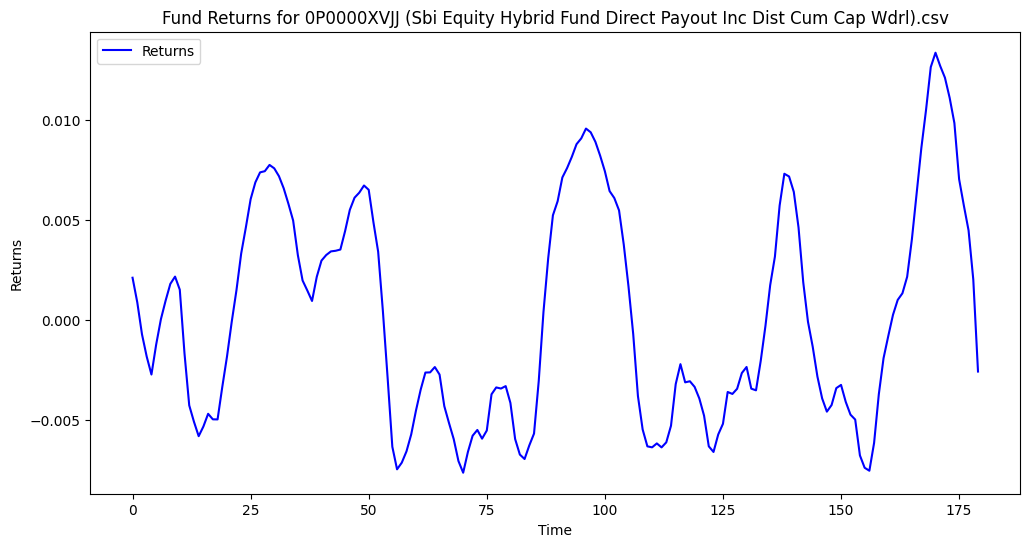

📊 0P00005WF0 (Sbi Bluechip Fund Regular Growth ).csv Optimization Results:
  Expected Return: -0.05%
  Portfolio Risk (Volatility): 0.71%
  Optimized Weight: 1.0000



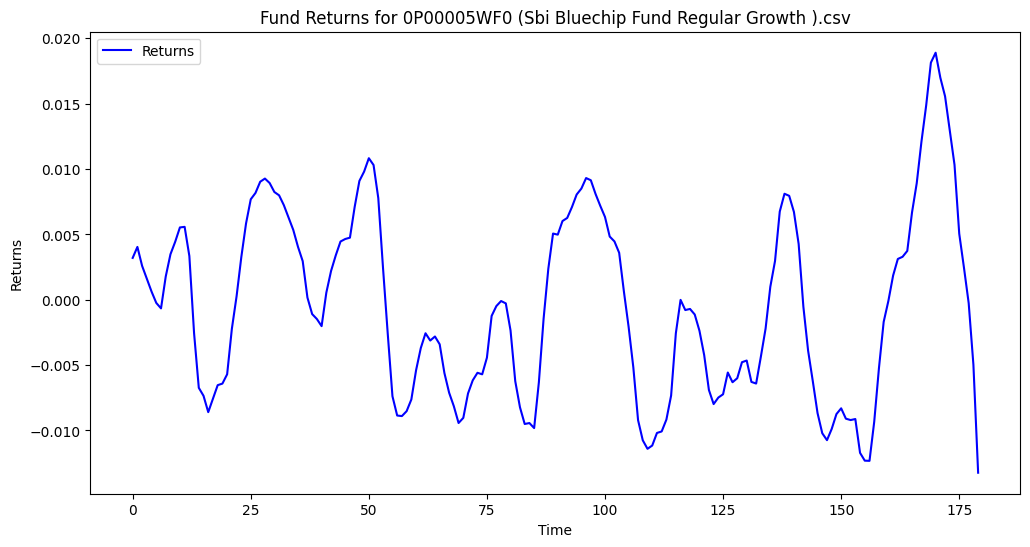

📊 0P0000XVA0 (Mirae Asset Large Cap Fund Direct Plan Growth).csv Optimization Results:
  Expected Return: -0.05%
  Portfolio Risk (Volatility): 0.74%
  Optimized Weight: 1.0000



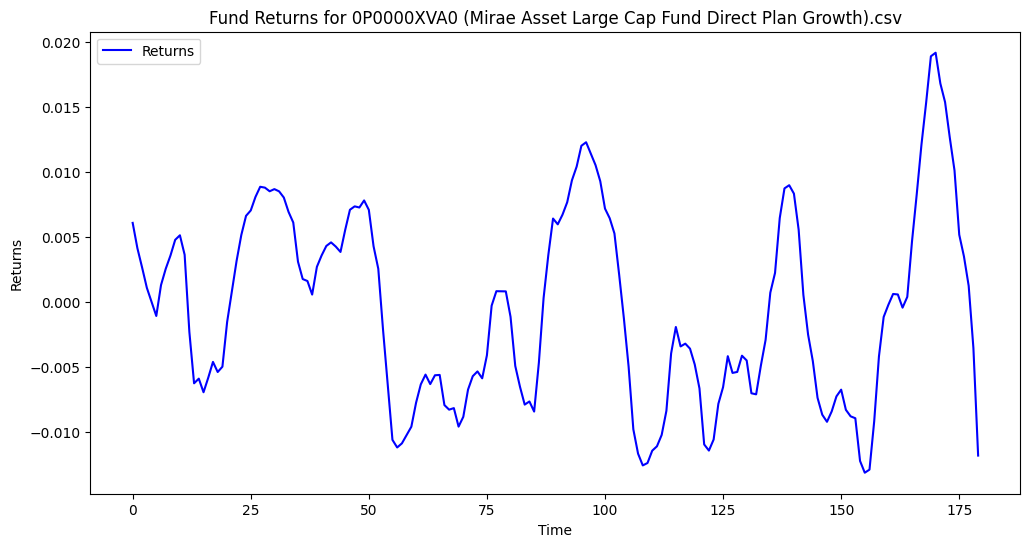

📊 0P0000XVTL (Axis Bluechip Fund Direct Plan Growth).csv Optimization Results:
  Expected Return: -0.05%
  Portfolio Risk (Volatility): 0.93%
  Optimized Weight: 1.0000



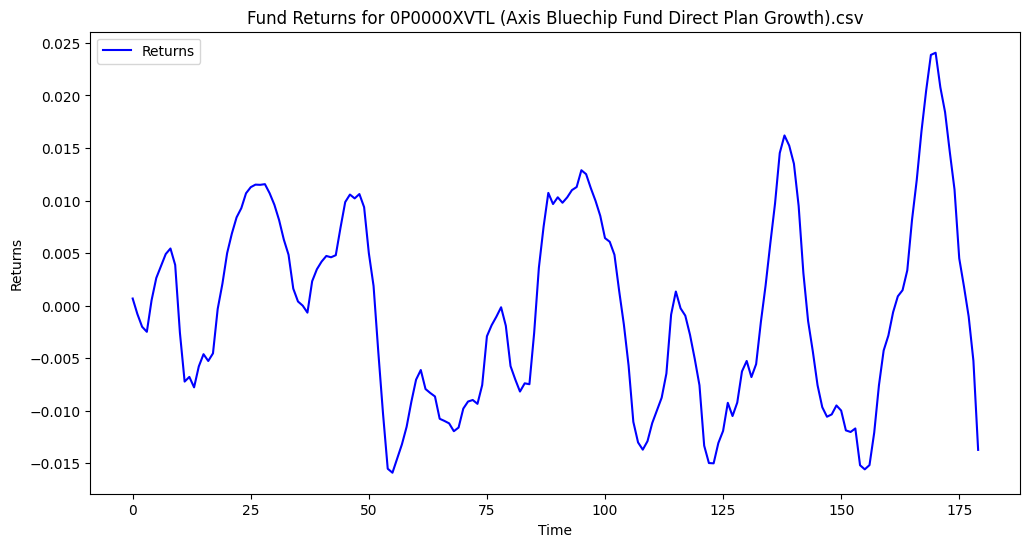

📊 0P00008TN3 (Icici Prudential Balanced Advantage Fund Payout Of Inc Dist Cum Cap Wdrl).csv Optimization Results:
  Expected Return: -0.24%
  Portfolio Risk (Volatility): 3.97%
  Optimized Weight: 1.0000



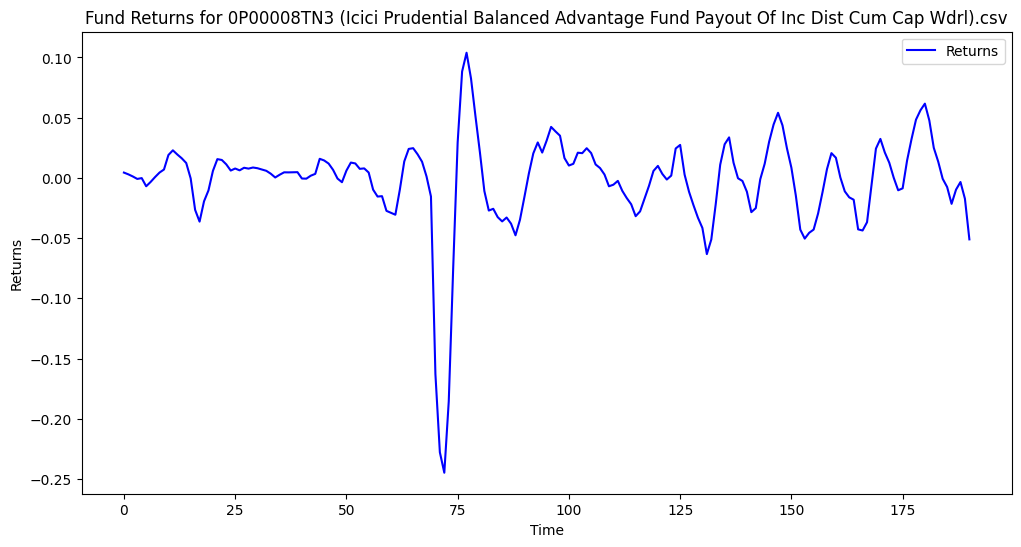

📊 0P0000N0B5 (Axis Elss Tax Saver Fund Growth).csv Optimization Results:
  Expected Return: -0.05%
  Portfolio Risk (Volatility): 0.97%
  Optimized Weight: 1.0000



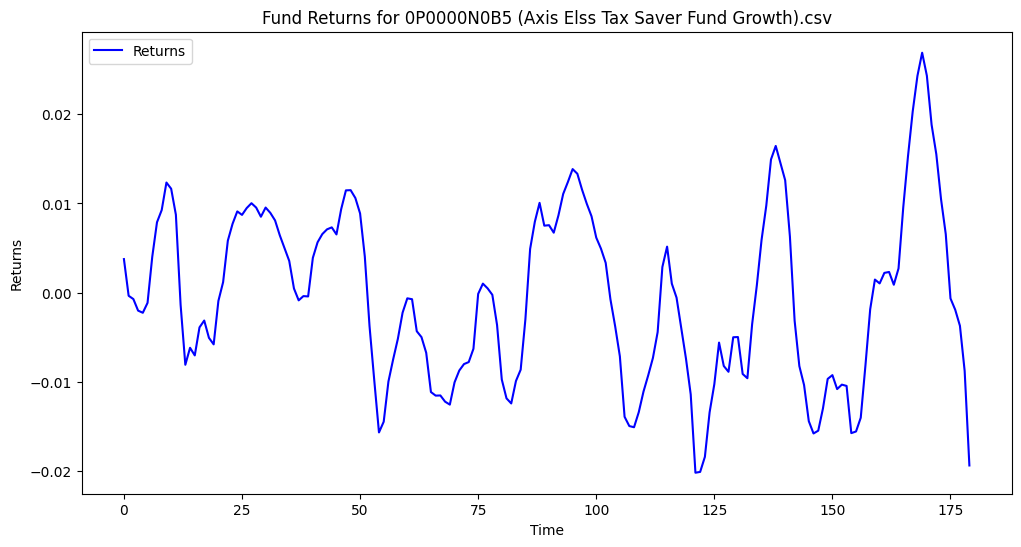

📊 0P0000XVT7 (UTI Liquid Fund - Cash Plan ).csv Optimization Results:
  Expected Return: 0.10%
  Portfolio Risk (Volatility): 0.01%
  Optimized Weight: 1.0000



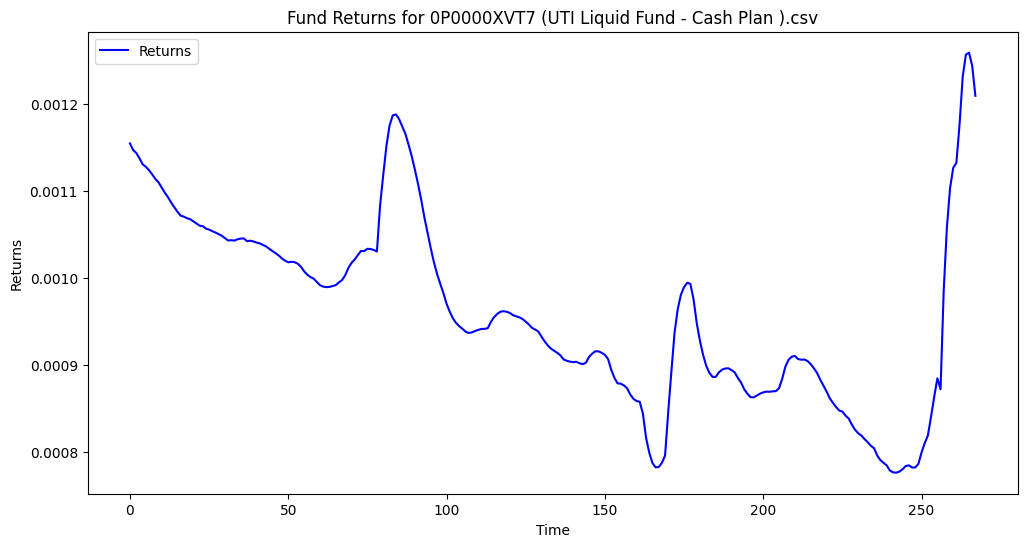

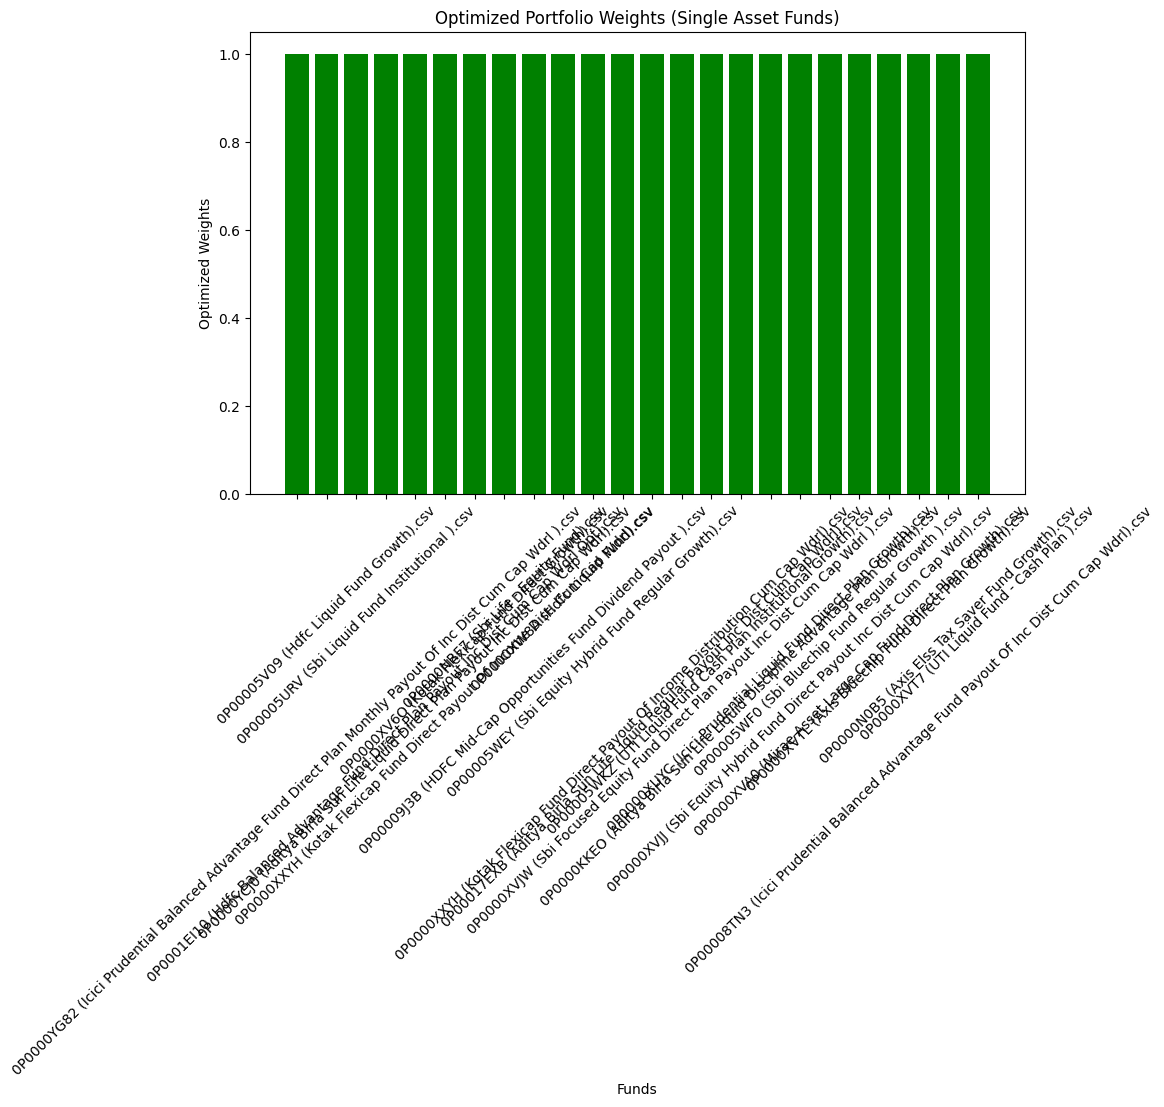

In [43]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import scipy.optimize as opt

# Dictionary to store individual fund optimization results
fund_optimization_results = {}

# Loop over each fund's predictions and calculate return, expected return, and covariance matrix
for fund_name, metrics in fund_predictions.items():
    # Get actual and predicted values
    y_test = metrics['y_test']
    y_pred = metrics['y_pred']

    # Convert NAV to Returns (percentage change) using predicted NAV
    fund_returns = pd.Series(y_pred).pct_change().dropna().values  # Use predicted NAV for returns

    # Calculate Expected Return (mean of daily returns)
    expected_return = np.mean(fund_returns)

    # Calculate Covariance Matrix (in this case it's just a scalar as we're dealing with a single fund)
    covariance_matrix = np.var(fund_returns)

    # Store the results for each fund
    fund_optimization_results[fund_name] = {
        'returns': fund_returns,
        'expected_return': expected_return,
        'covariance_matrix': covariance_matrix
    }

    # Store Predicted Returns, Expected Return, and Volatility in a separate dictionary for later use
    fund_summary = {
        'Predicted Returns': fund_returns,
        'Expected Return': expected_return,
        'Volatility': np.sqrt(covariance_matrix)
    }

    # Adding fund summary values to each fund's results
    fund_optimization_results[fund_name]['fund_summary'] = fund_summary

    # Portfolio Optimization for each fund (even though it's just a single asset)
    # Here, we will use a trivial optimization approach, as it's a single asset case
    # Let's assume we want to maximize return per unit risk (Sharpe ratio)

    def portfolio_variance(weights, covariance_matrix):
        return weights ** 2 * covariance_matrix  # Variance of a single asset is simply weight^2 * variance

    def portfolio_return(weights, expected_return):
        return weights * expected_return  # Return is just weight * expected return for a single asset

    def negative_sharpe_ratio(weights, expected_return, covariance_matrix):
        port_return = portfolio_return(weights, expected_return)
        port_volatility = np.sqrt(portfolio_variance(weights, covariance_matrix))
        return -(port_return) / port_volatility  # We ignore risk-free rate for simplicity

    # Constraints: weights must sum to 1 (fully invested portfolio)
    constraints = ({'type': 'eq', 'fun': lambda weights: np.sum(weights) - 1})

    # Bounds: Each weight is between 0 and 1
    bounds = tuple((0, 1) for _ in range(1))  # Only one asset, so only one weight

    # Initial Guess: 100% allocation to the fund
    initial_guess = [1.0]

    # Optimize the portfolio
    result = opt.minimize(negative_sharpe_ratio, initial_guess, args=(expected_return, covariance_matrix),
                          method='SLSQP', bounds=bounds, constraints=constraints)

    # Extract the optimized weight (it will be 1 since we have only one fund)
    optimized_weight = result.x[0]

    # Store the optimized portfolio weight for each fund
    fund_optimization_results[fund_name]['optimized_weight'] = optimized_weight

    # Print results for each fund
    print(f"📊 {fund_name} Optimization Results:")
    print(f"  Expected Return: {expected_return * 100:.2f}%")
    print(f"  Portfolio Risk (Volatility): {np.sqrt(covariance_matrix) * 100:.2f}%")
    print(f"  Optimized Weight: {optimized_weight:.4f}\n")

    # Plotting the Returns for each fund
    plt.figure(figsize=(12,6))
    plt.plot(fund_returns, label='Returns', color='blue')
    plt.title(f'Fund Returns for {fund_name}')
    plt.xlabel('Time')
    plt.ylabel('Returns')
    plt.legend()
    plt.show()

# Now, you have the optimized weight and other details for each fund independently
# You can visualize the portfolio weight distribution for all funds if needed

# Example visualization (you can customize this further)
optimized_weights = [result['optimized_weight'] for result in fund_optimization_results.values()]
fund_names = list(fund_optimization_results.keys())

plt.figure(figsize=(10, 6))
plt.bar(fund_names, optimized_weights, color='green')
plt.xlabel('Funds')
plt.ylabel('Optimized Weights')
plt.title('Optimized Portfolio Weights (Single Asset Funds)')
plt.xticks(rotation=45)
plt.show()



📊 0P0000YG82 (Icici Prudential Balanced Advantage Fund Direct Plan Monthly Payout Of Inc Dist Cum Cap Wdrl ).csv Summary Results:
  Expected Return: 0.00%
  Portfolio Risk (Volatility): 0.38%



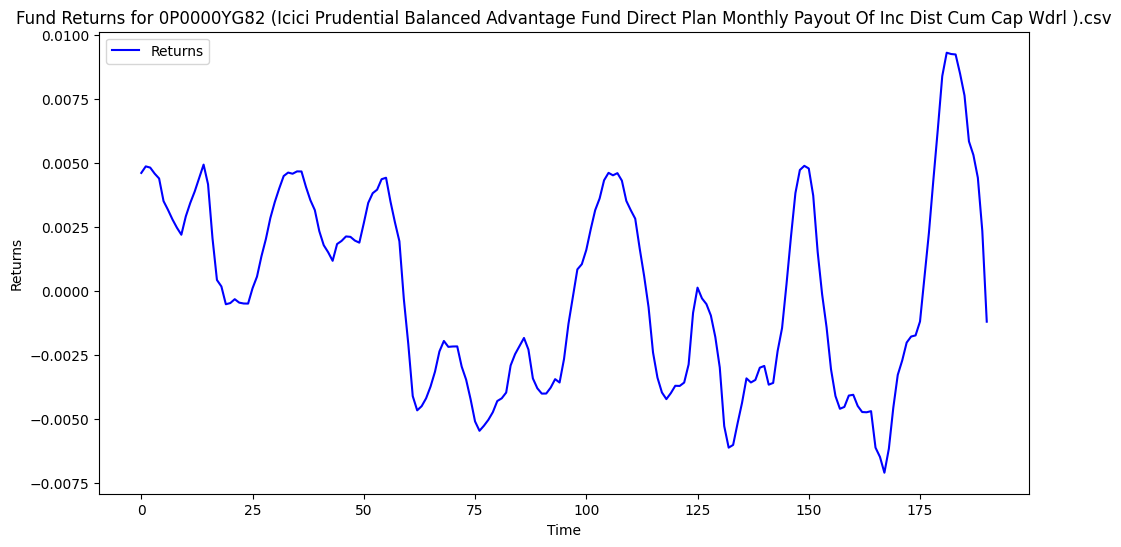

📊 0P00005V09 (Hdfc Liquid Fund Growth).csv Summary Results:
  Expected Return: 0.10%
  Portfolio Risk (Volatility): 0.01%



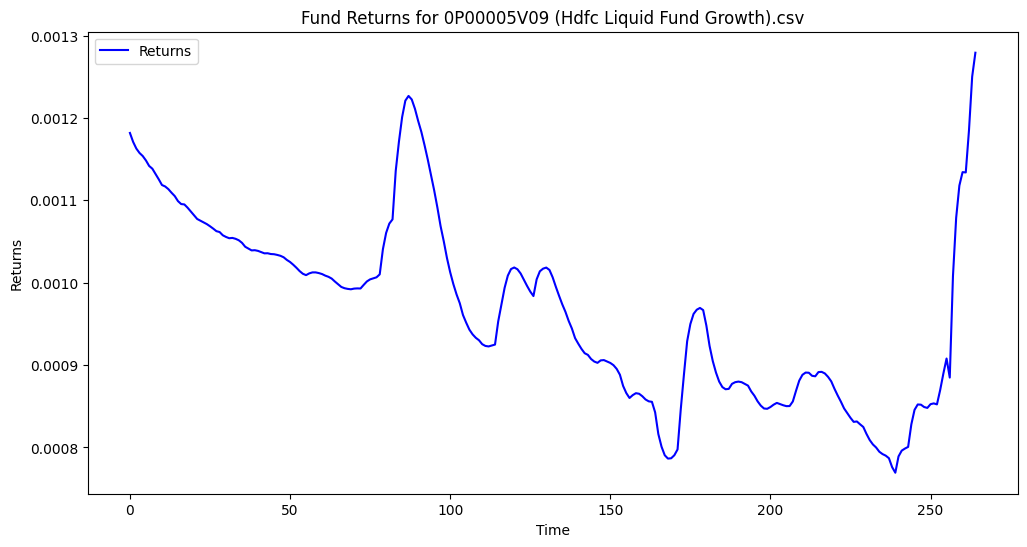

📊 0P00005URV (Sbi Liquid Fund Institutional ).csv Summary Results:
  Expected Return: 0.15%
  Portfolio Risk (Volatility): 0.01%



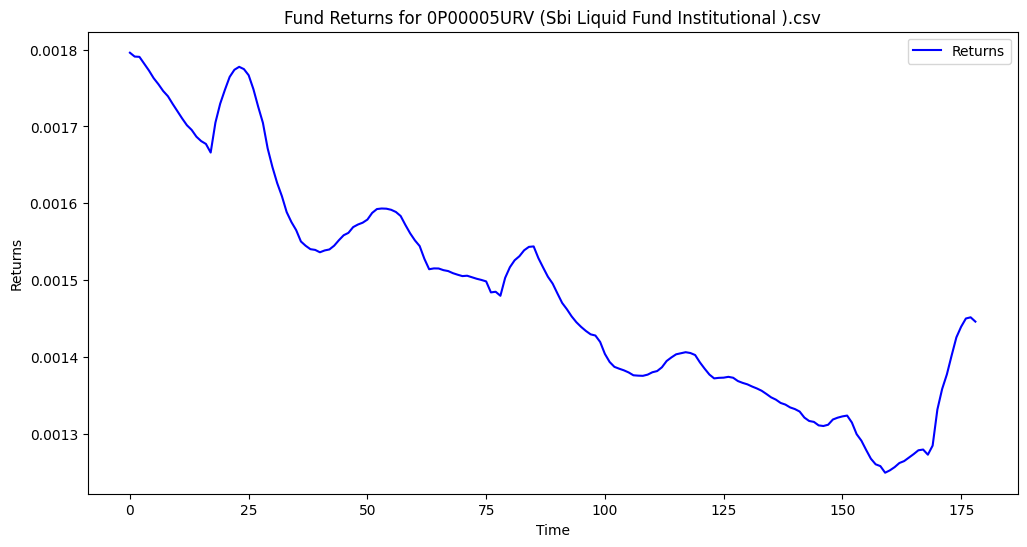

📊 0P0001EI10 (Hdfc Balanced Advantage Fund Direct Plan Payout Inc Dist Cum Cap Wdrl Opt).csv Summary Results:
  Expected Return: -0.10%
  Portfolio Risk (Volatility): 0.43%



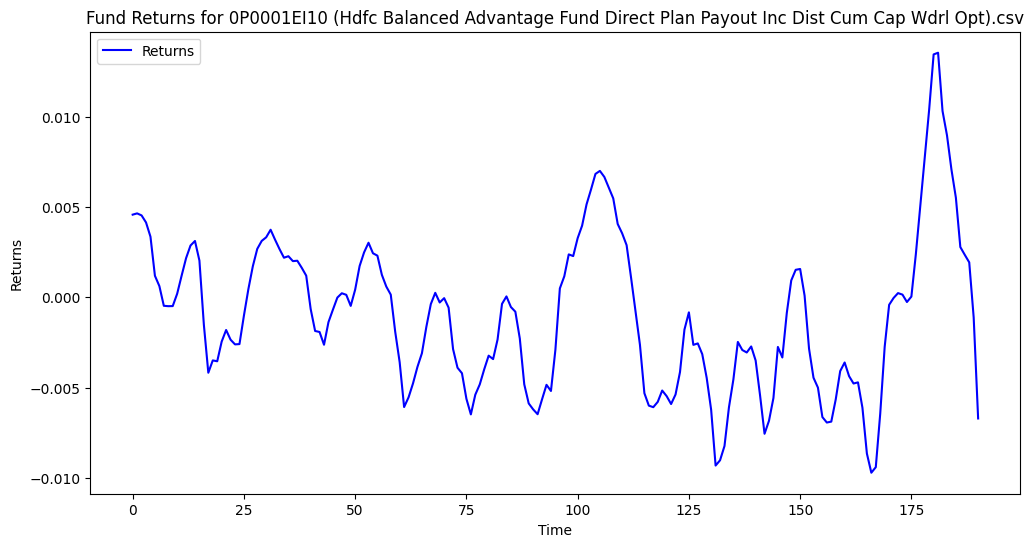

📊 0P0000YCJ0 (Aditya Birla Sun Life Liquid Direct Plan Payout Inc Dist Cum Cap Wdrl).csv Summary Results:
  Expected Return: -1.22%
  Portfolio Risk (Volatility): 4.19%



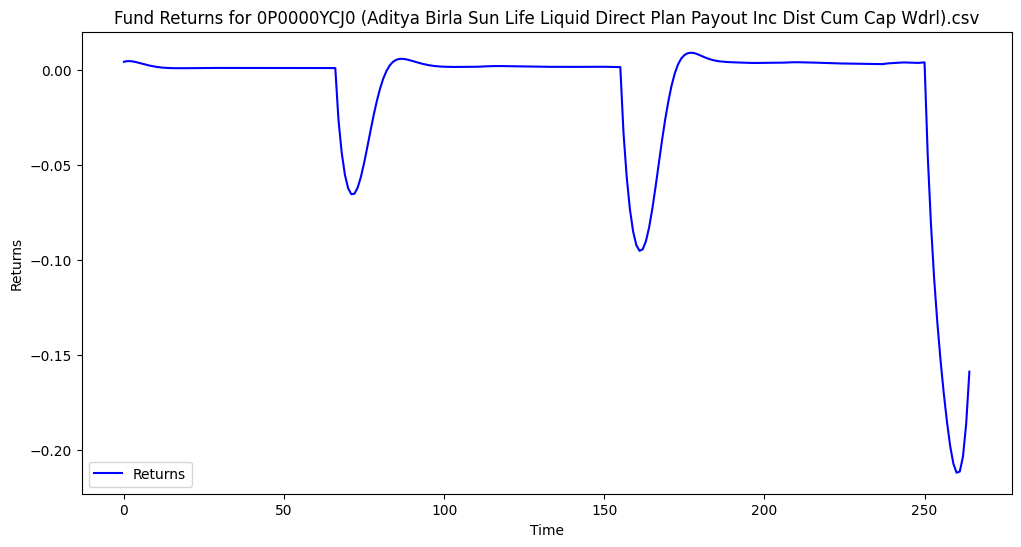

📊 0P0000XXYH (Kotak Flexicap Fund Direct Payout Of Income Dist. Cum Cap Wdrl).csv Summary Results:
  Expected Return: -0.09%
  Portfolio Risk (Volatility): 0.63%



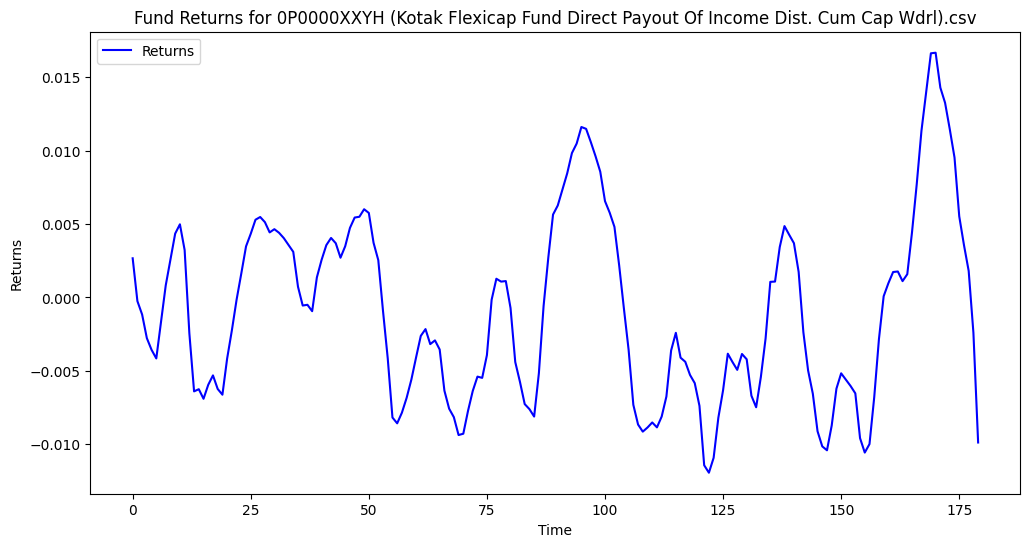

📊 0P0000XV6O (Kotak Flexicap Fund Direct Growth).csv Summary Results:
  Expected Return: -0.09%
  Portfolio Risk (Volatility): 0.61%



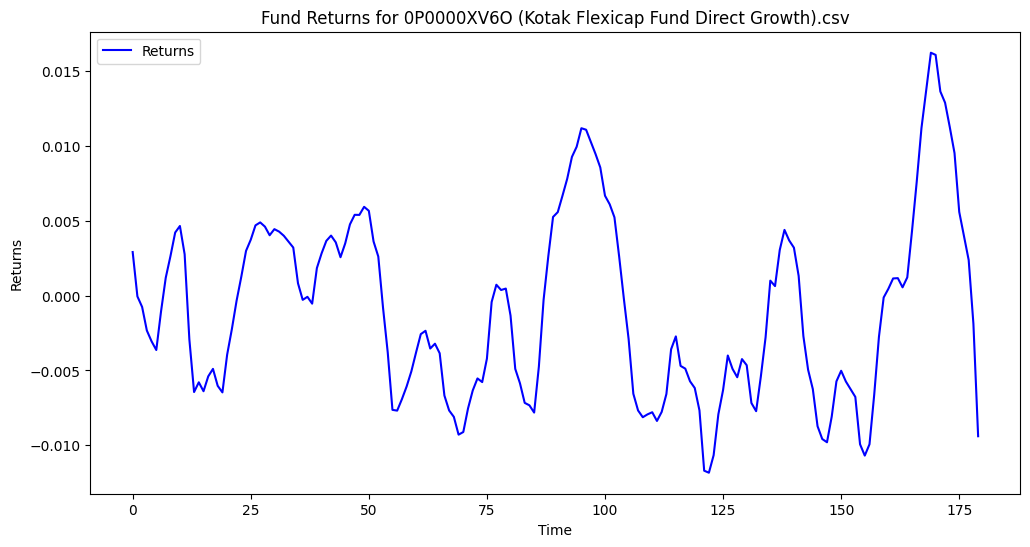

📊 0P0000NRF7 (Sbi Life - Equity Fund).csv Summary Results:
  Expected Return: -0.07%
  Portfolio Risk (Volatility): 0.79%



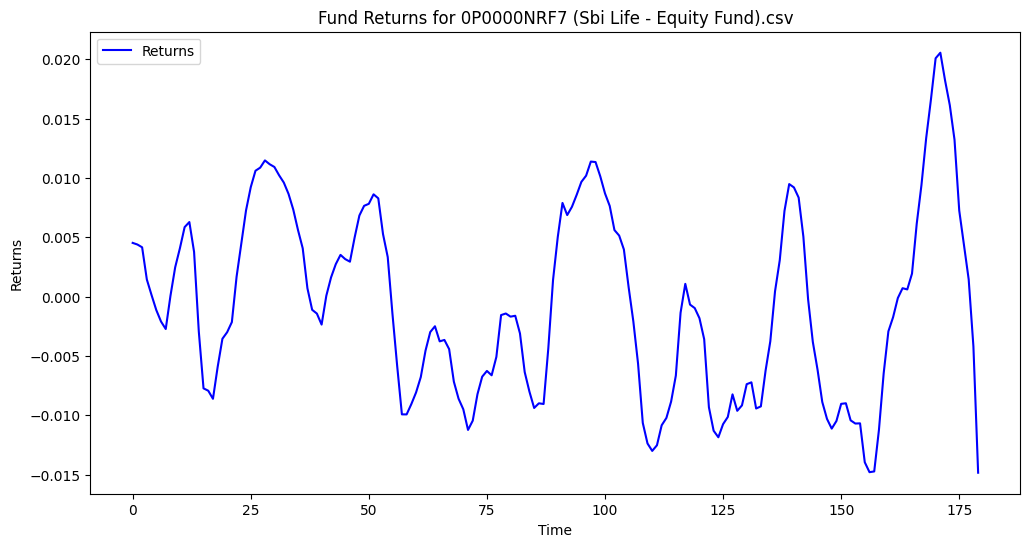

📊 0P00009J3B (HDFC Mid-Cap Opportunities Fund Dividend Payout ).csv Summary Results:
  Expected Return: -0.21%
  Portfolio Risk (Volatility): 1.34%



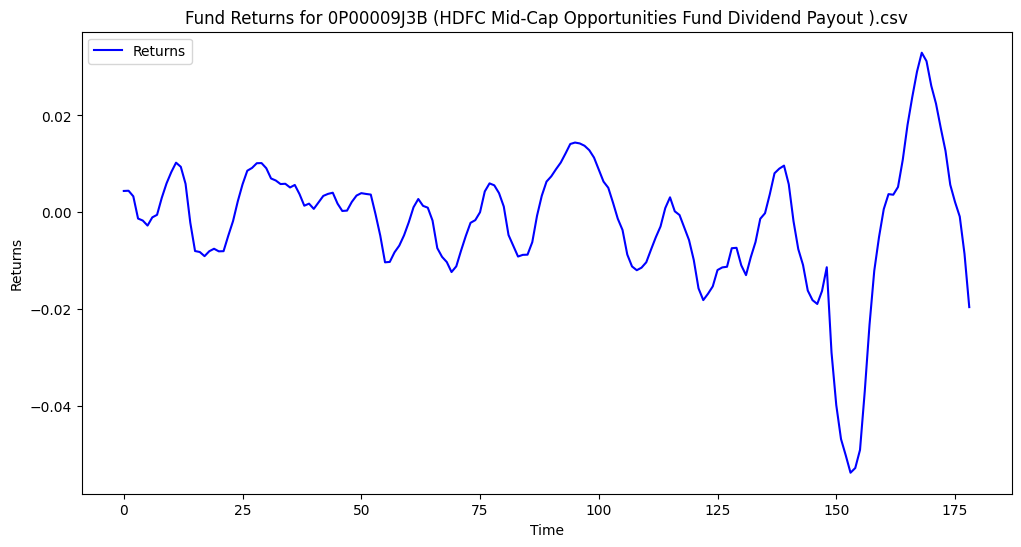

📊 0P0000XW8A (Hdfc Liquid Fund).csv Summary Results:
  Expected Return: 716.72%
  Portfolio Risk (Volatility): 10435.61%



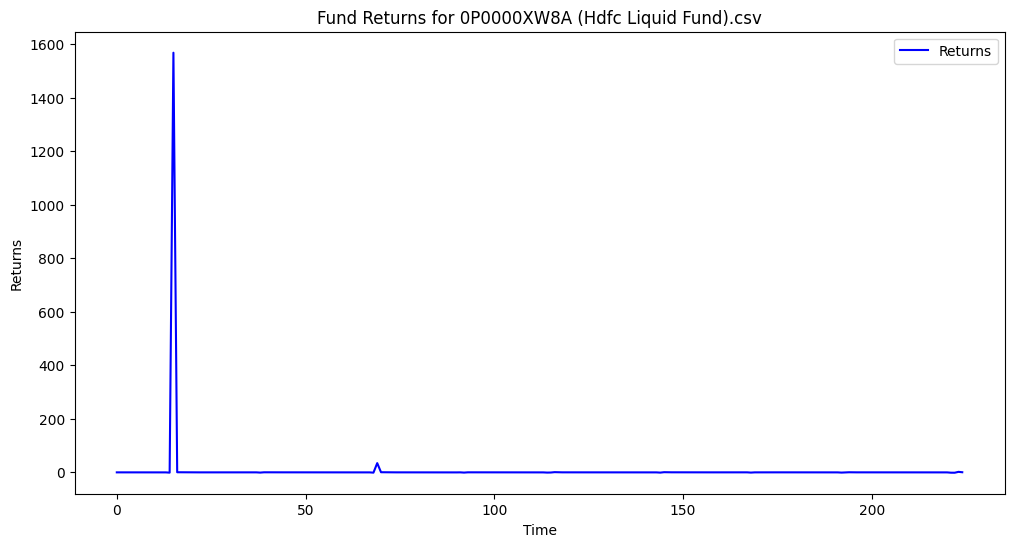

📊 0P00005WEY (Sbi Equity Hybrid Fund Regular Growth).csv Summary Results:
  Expected Return: 0.02%
  Portfolio Risk (Volatility): 0.57%



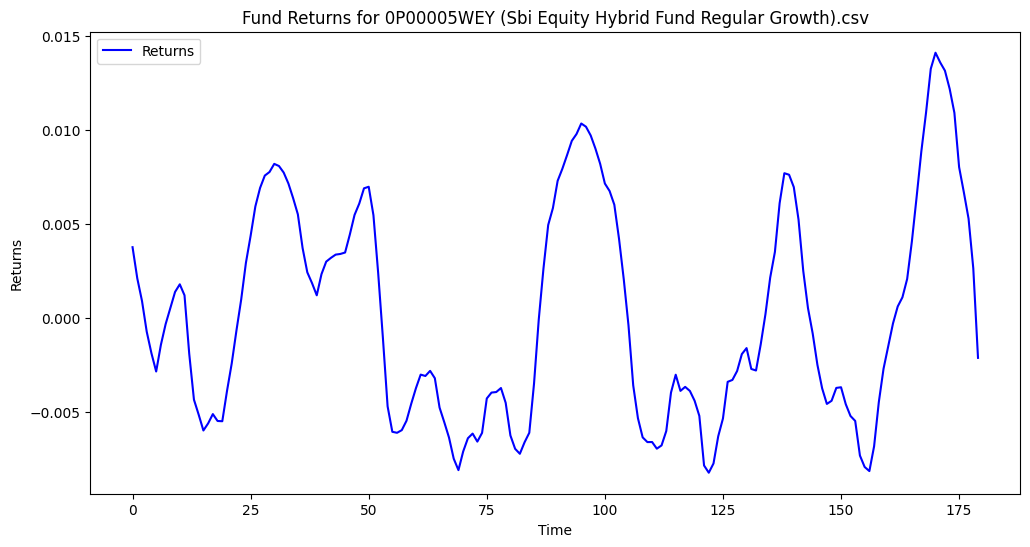

📊 0P0000XXYH (Kotak Flexicap Fund Direct Payout Of Income Distribution Cum Cap Wdrl).csv Summary Results:
  Expected Return: -0.09%
  Portfolio Risk (Volatility): 0.59%



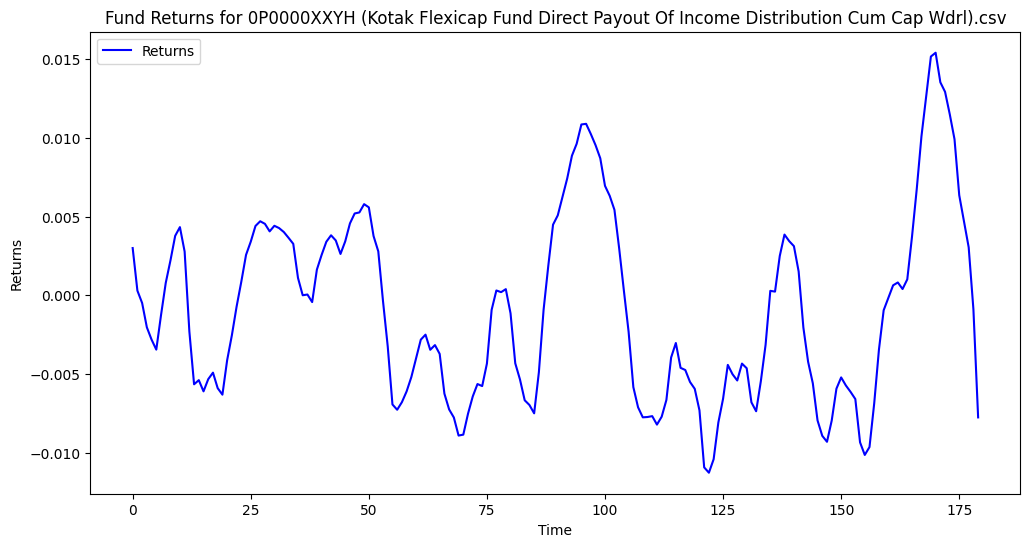

📊 0P00017EXB (Aditya Birla Sun Life Liquid Regular Payout Inc Dist Cum Cap Wdrl).csv Summary Results:
  Expected Return: -1.01%
  Portfolio Risk (Volatility): 3.20%



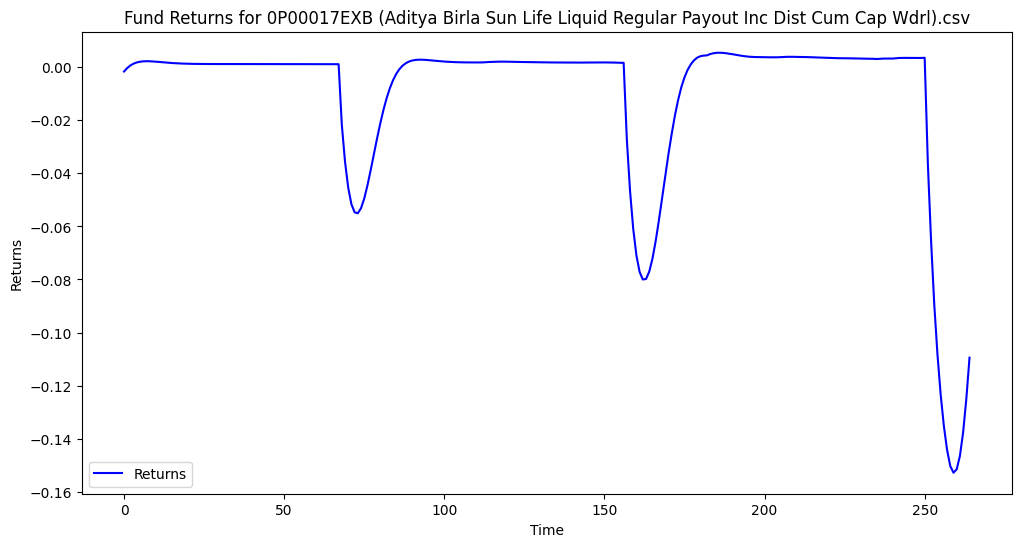

📊 0P0000XVJW (Sbi Focused Equity Fund Direct Plan Payout Inc Dist Cum Cap Wdrl ).csv Summary Results:
  Expected Return: -0.02%
  Portfolio Risk (Volatility): 0.62%



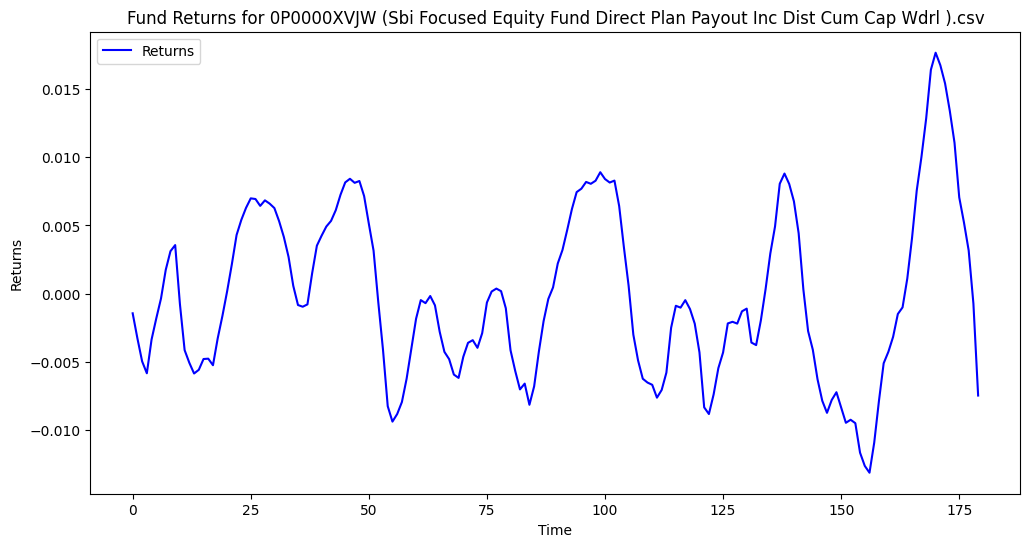

📊 0P00005WKZ (UTI Liquid Fund Cash Plan Institutional Growth).csv Summary Results:
  Expected Return: 0.10%
  Portfolio Risk (Volatility): 0.01%



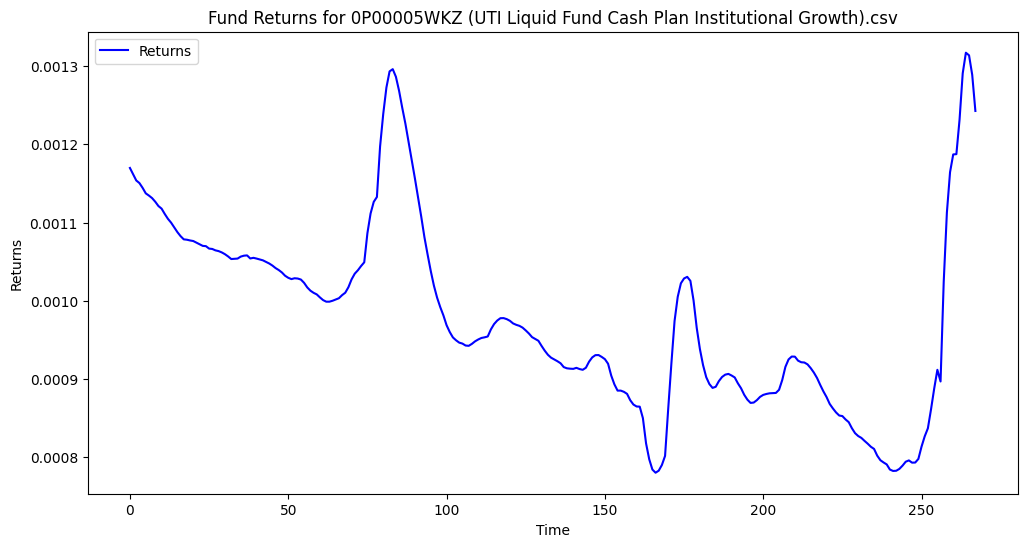

📊 0P0000KKEO (Aditya Birla Sun Life Liquid Discipline Advantage Plan Growth).csv Summary Results:
  Expected Return: 0.10%
  Portfolio Risk (Volatility): 0.01%



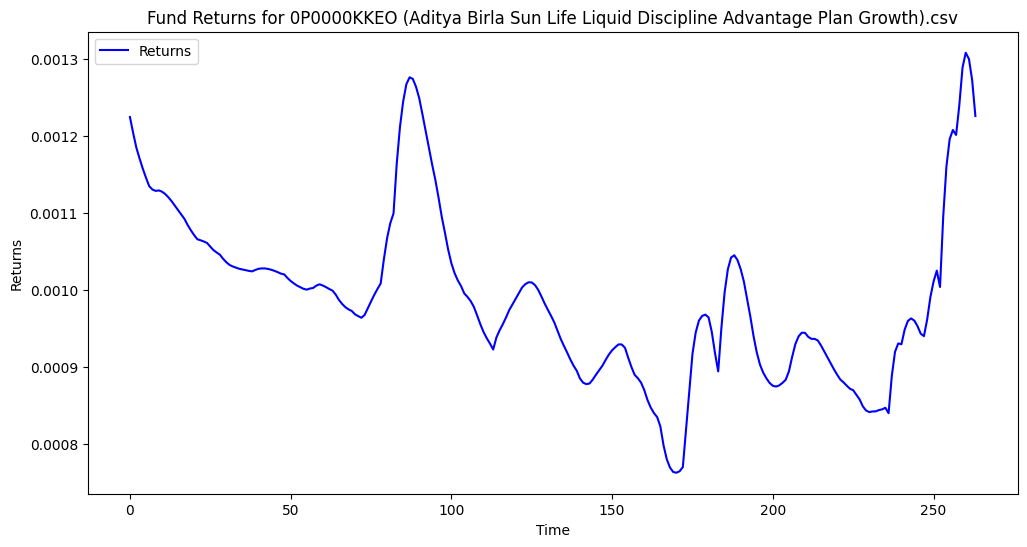

📊 0P0000XUYC (Icici Prudential Liquid Fund Direct Plan Growth).csv Summary Results:
  Expected Return: 0.10%
  Portfolio Risk (Volatility): 0.01%



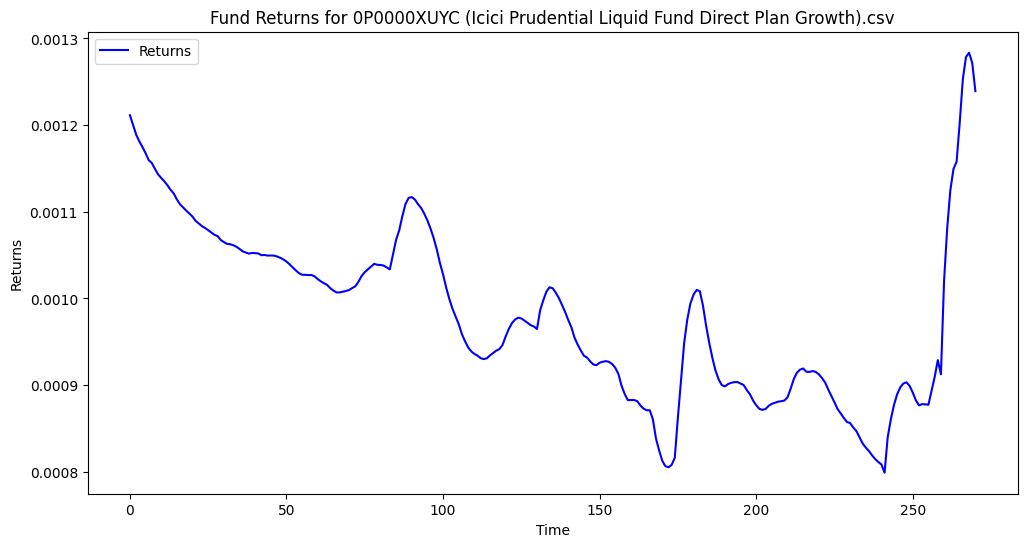

📊 0P0000XVJJ (Sbi Equity Hybrid Fund Direct Payout Inc Dist Cum Cap Wdrl).csv Summary Results:
  Expected Return: 0.02%
  Portfolio Risk (Volatility): 0.54%



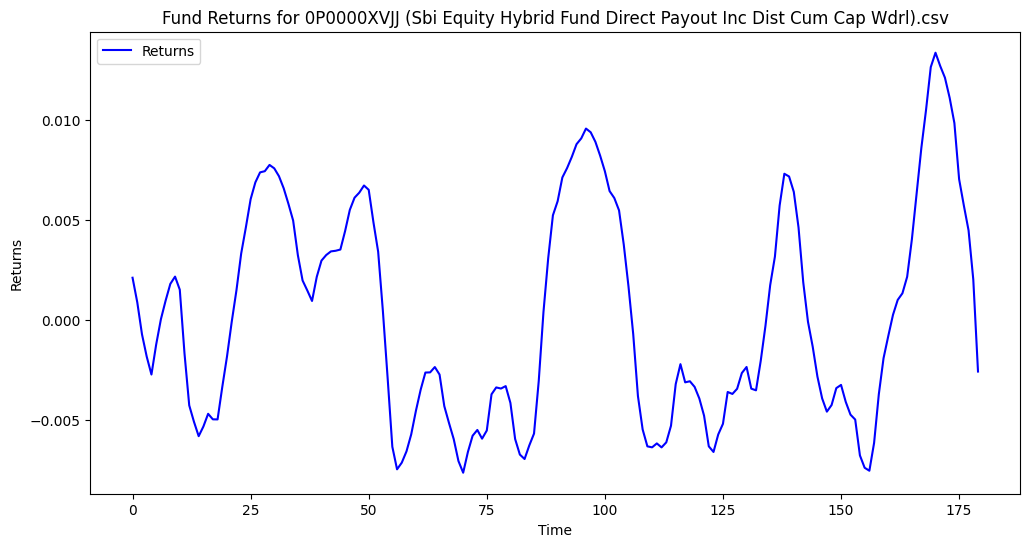

📊 0P00005WF0 (Sbi Bluechip Fund Regular Growth ).csv Summary Results:
  Expected Return: -0.05%
  Portfolio Risk (Volatility): 0.71%



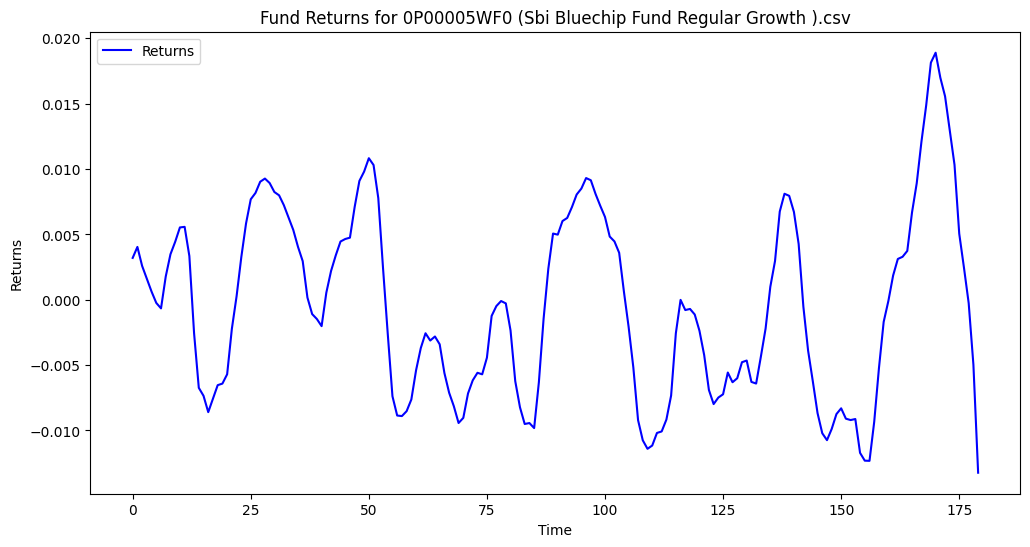

📊 0P0000XVA0 (Mirae Asset Large Cap Fund Direct Plan Growth).csv Summary Results:
  Expected Return: -0.05%
  Portfolio Risk (Volatility): 0.74%



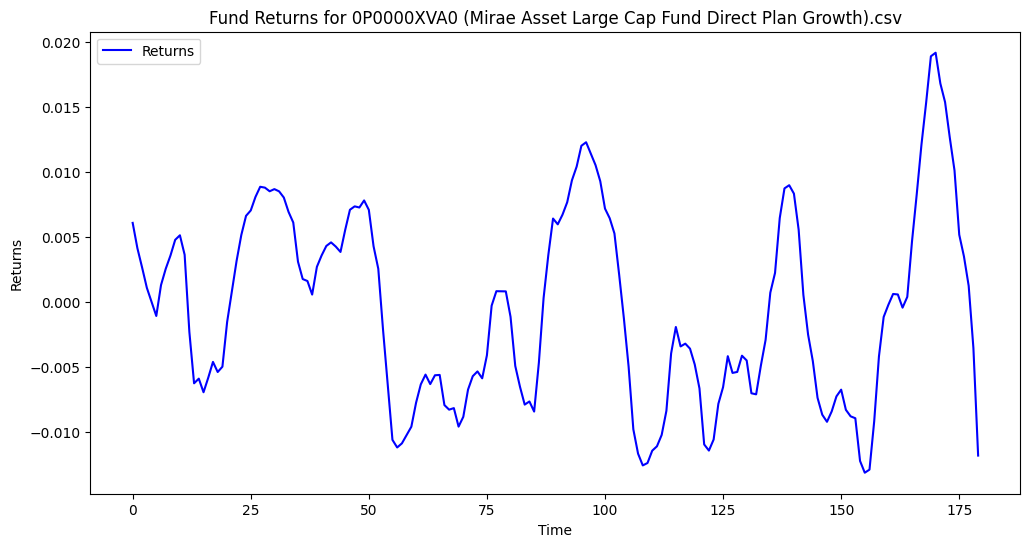

📊 0P0000XVTL (Axis Bluechip Fund Direct Plan Growth).csv Summary Results:
  Expected Return: -0.05%
  Portfolio Risk (Volatility): 0.93%



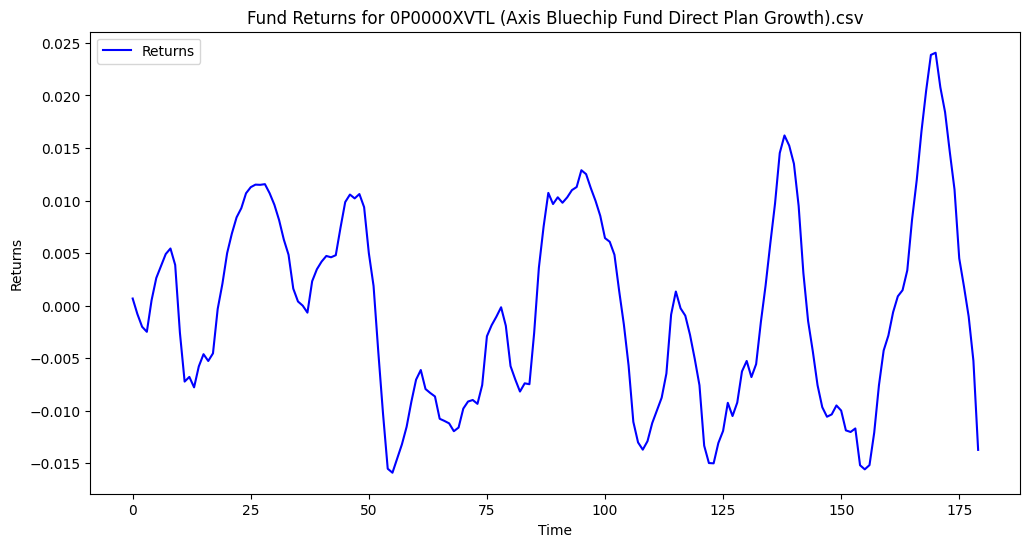

📊 0P00008TN3 (Icici Prudential Balanced Advantage Fund Payout Of Inc Dist Cum Cap Wdrl).csv Summary Results:
  Expected Return: -0.24%
  Portfolio Risk (Volatility): 3.97%



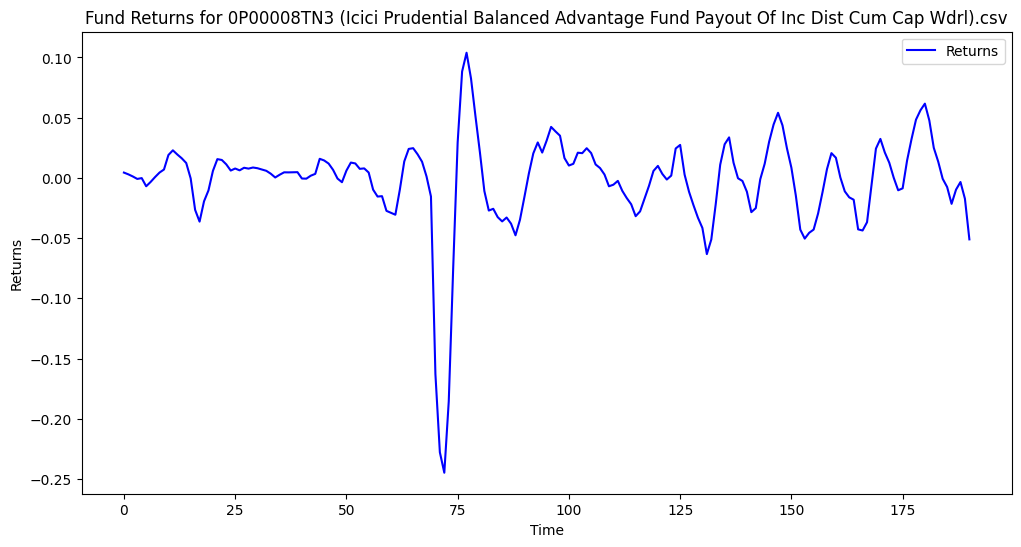

📊 0P0000N0B5 (Axis Elss Tax Saver Fund Growth).csv Summary Results:
  Expected Return: -0.05%
  Portfolio Risk (Volatility): 0.97%



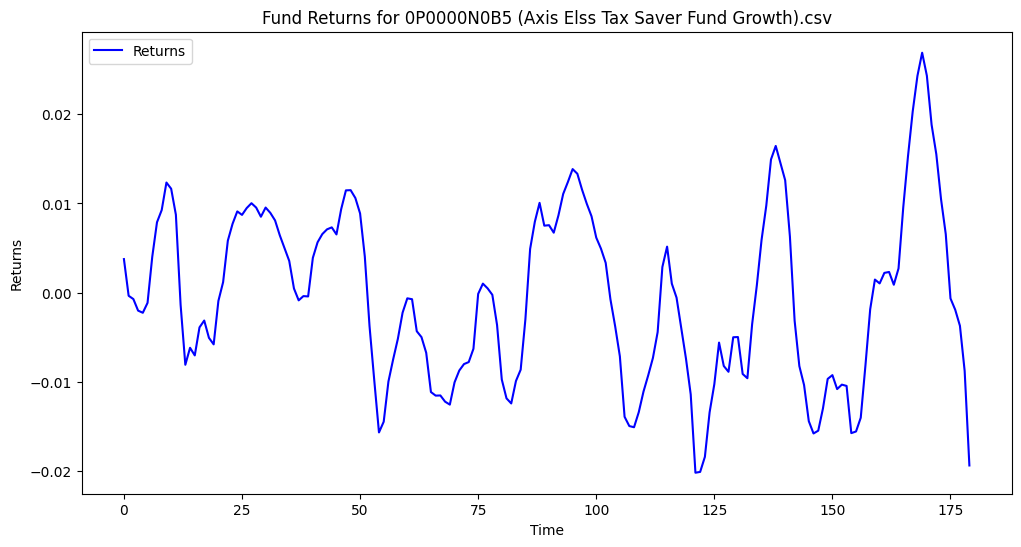

📊 0P0000XVT7 (UTI Liquid Fund - Cash Plan ).csv Summary Results:
  Expected Return: 0.10%
  Portfolio Risk (Volatility): 0.01%



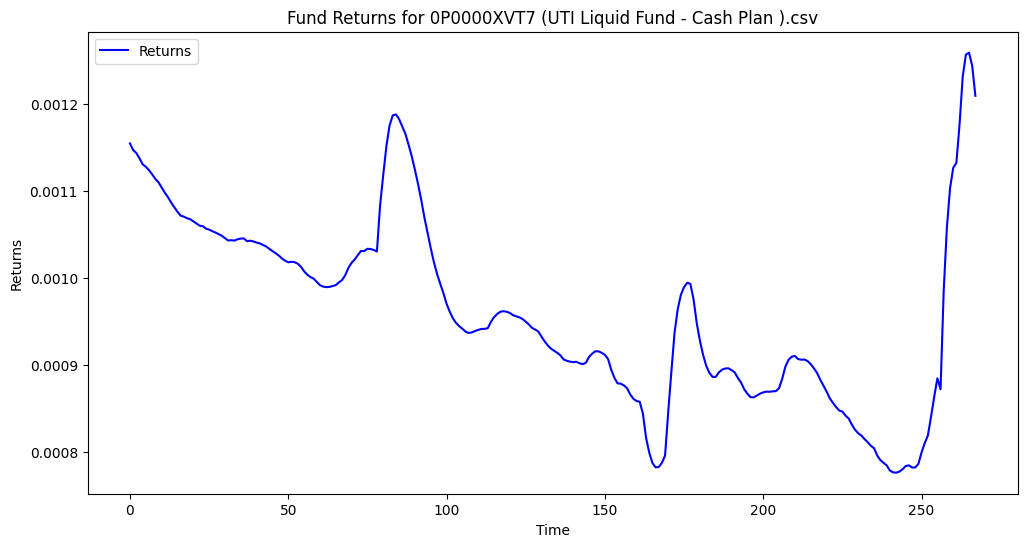

In [44]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import scipy.optimize as opt

# Dictionary to store individual fund optimization results
fund_optimization_results = {}

# Loop over each fund's predictions and calculate return, expected return, and covariance matrix
for fund_name, metrics in fund_predictions.items():
    # Get actual and predicted values
    y_test = metrics['y_test']
    y_pred = metrics['y_pred']

    # Convert NAV to Returns (percentage change) using predicted NAV
    fund_returns = pd.Series(y_pred).pct_change().dropna().values  # Use predicted NAV for returns

    # Calculate Expected Return (mean of daily returns)
    expected_return = np.mean(fund_returns)

    # Calculate Volatility (standard deviation of predicted returns)
    volatility = np.std(fund_returns)

    # Store the results for each fund (Predicted Returns, Expected Return, and Volatility)
    fund_optimization_results[fund_name] = {
        'returns': fund_returns,
        'expected_return': expected_return,
        'volatility': volatility
    }

    # Print results for each fund (Expected Return and Volatility)
    print(f"📊 {fund_name} Summary Results:")
    print(f"  Expected Return: {expected_return * 100:.2f}%")
    print(f"  Portfolio Risk (Volatility): {volatility * 100:.2f}%\n")

    # Plotting the Returns for each fund
    plt.figure(figsize=(12,6))
    plt.plot(fund_returns, label='Returns', color='blue')
    plt.title(f'Fund Returns for {fund_name}')
    plt.xlabel('Time')
    plt.ylabel('Returns')
    plt.legend()
    plt.show()

# Now, the fund_optimization_results contains the predicted returns, expected return, and volatility for each fund.
# You can access the data and proceed with portfolio optimization later using this stored data.


In [45]:
import numpy as np
import pandas as pd
import scipy.optimize as opt

# Dictionary to store individual fund optimization results
fund_optimization_results = {}

# Loop over each fund's predictions and calculate return, expected return, and covariance matrix
for fund_name, metrics in fund_predictions.items():
    # Get actual and predicted values
    y_test = metrics['y_test']
    y_pred = metrics['y_pred']

    # Convert NAV to Returns (percentage change) using predicted NAV
    fund_returns = pd.Series(y_pred).pct_change().dropna().values  # Use predicted NAV for returns

    # Calculate Expected Return (mean of daily returns)
    expected_return = np.mean(fund_returns)

    # Calculate Volatility (standard deviation of returns)
    volatility = np.std(fund_returns)

    # Store the results for each fund
    fund_optimization_results[fund_name] = {
        'returns': fund_returns,
        'expected_return': expected_return,
        'volatility': volatility  # Store the volatility
    }

# Now calculate the covariance matrix based on the volatilities

fund_names = list(fund_optimization_results.keys())
expected_returns = np.array([fund_optimization_results[fund]['expected_return'] for fund in fund_names])
volatilities = np.array([fund_optimization_results[fund]['volatility'] for fund in fund_names])

# Method 1: Assume Independence (Covariance Matrix = Diagonal Matrix with Variances)
covariance_matrix_indep = np.diag(volatilities**2)

# Method 2: Estimate Covariances (Assuming correlation of 0.2 between funds)
rho = 0.2  # assumed correlation
covariance_matrix_corr = np.array([[rho * vol_i * vol_j for vol_j in volatilities] for vol_i in volatilities])

# Print both covariance matrices for comparison
print("Covariance Matrix (Assume Independence):")
print(covariance_matrix_indep)

print("\nCovariance Matrix (Assume Correlation of 0.2):")
print(covariance_matrix_corr)

# Now, let's proceed with portfolio optimization using the covariance matrices

# Step 2: Define the optimization functions (same as before)
def portfolio_variance(weights, covariance_matrix):
    return np.dot(weights.T, np.dot(covariance_matrix, weights))

def portfolio_return(weights, expected_returns):
    return np.dot(weights, expected_returns)

def negative_sharpe_ratio(weights, expected_returns, covariance_matrix):
    port_return = portfolio_return(weights, expected_returns)
    port_volatility = np.sqrt(portfolio_variance(weights, covariance_matrix))
    return -(port_return / port_volatility)

# Step 3: Constraints and bounds
constraints = ({'type': 'eq', 'fun': lambda weights: np.sum(weights) - 1})  # Weights sum to 1
bounds = tuple((0, 1) for _ in range(len(fund_names)))  # Each weight between 0 and 1
initial_guess = [1.0 / len(fund_names)] * len(fund_names)  # Equal initial guess for weights

# Step 4: Portfolio Optimization using the two covariance matrices

# Using Independence (Covariance = Diagonal)
result_indep = opt.minimize(negative_sharpe_ratio, initial_guess, args=(expected_returns, covariance_matrix_indep),
                            method='SLSQP', bounds=bounds, constraints=constraints)

# Using Correlation (Full Covariance Matrix)
result_corr = opt.minimize(negative_sharpe_ratio, initial_guess, args=(expected_returns, covariance_matrix_corr),
                            method='SLSQP', bounds=bounds, constraints=constraints)

# Step 5: Get the optimized weights and print results for both methods
optimized_weights_indep = result_indep.x
optimized_weights_corr = result_corr.x

print("\nOptimized Portfolio Weights (Assume Independence):")
for i, weight in enumerate(optimized_weights_indep):
    print(f"{fund_names[i]}: {weight:.4f}")

print("\nOptimized Portfolio Weights (Assume Correlation of 0.2):")
for i, weight in enumerate(optimized_weights_corr):
    print(f"{fund_names[i]}: {weight:.4f}")


Covariance Matrix (Assume Independence):
[[1.4244976e-05 0.0000000e+00 0.0000000e+00 0.0000000e+00 0.0000000e+00
  0.0000000e+00 0.0000000e+00 0.0000000e+00 0.0000000e+00 0.0000000e+00
  0.0000000e+00 0.0000000e+00 0.0000000e+00 0.0000000e+00 0.0000000e+00
  0.0000000e+00 0.0000000e+00 0.0000000e+00 0.0000000e+00 0.0000000e+00
  0.0000000e+00 0.0000000e+00 0.0000000e+00 0.0000000e+00]
 [0.0000000e+00 1.2533165e-08 0.0000000e+00 0.0000000e+00 0.0000000e+00
  0.0000000e+00 0.0000000e+00 0.0000000e+00 0.0000000e+00 0.0000000e+00
  0.0000000e+00 0.0000000e+00 0.0000000e+00 0.0000000e+00 0.0000000e+00
  0.0000000e+00 0.0000000e+00 0.0000000e+00 0.0000000e+00 0.0000000e+00
  0.0000000e+00 0.0000000e+00 0.0000000e+00 0.0000000e+00]
 [0.0000000e+00 0.0000000e+00 2.2042050e-08 0.0000000e+00 0.0000000e+00
  0.0000000e+00 0.0000000e+00 0.0000000e+00 0.0000000e+00 0.0000000e+00
  0.0000000e+00 0.0000000e+00 0.0000000e+00 0.0000000e+00 0.0000000e+00
  0.0000000e+00 0.0000000e+00 0.0000000e+00 0.000

In [46]:
import numpy as np
import pandas as pd
import scipy.optimize as opt

# Step 1: Prepare returns data
returns_series_list = []

for fund_name, metrics in fund_optimization_results.items():
    fund_returns = pd.Series(metrics['returns'], name=fund_name)
    returns_series_list.append(fund_returns)

all_returns = pd.concat(returns_series_list, axis=1)
all_returns = all_returns.dropna()

# Step 2: Calculate expected returns and covariance matrix
expected_returns = np.array([metrics['expected_return'] for metrics in fund_optimization_results.values()])
covariance_matrix = np.cov(all_returns.T)

# [Optional] Slight regularization to prevent singular matrix problems
covariance_matrix += np.eye(covariance_matrix.shape[0]) * 1e-6

# Step 3: Negative Sharpe ratio function
def negative_sharpe_ratio(weights, expected_returns, covariance_matrix):
    portfolio_return = np.dot(weights, expected_returns)
    portfolio_volatility = np.sqrt(np.dot(weights.T, np.dot(covariance_matrix, weights)))
    risk_free_rate = 0
    sharpe_ratio = (portfolio_return - risk_free_rate) / portfolio_volatility
    return -sharpe_ratio

# Step 4: Initial weights — slightly random
num_funds = len(expected_returns)
np.random.seed(42)
initial_weights = np.random.random(num_funds)
initial_weights /= np.sum(initial_weights)  # Normalize to sum to 1

# Step 5: Bounds and constraints
bounds = [(0, 1) for _ in range(num_funds)]
constraints = {'type': 'eq', 'fun': lambda weights: np.sum(weights) - 1}

# Step 6: Perform optimization
result = opt.minimize(negative_sharpe_ratio, initial_weights, args=(expected_returns, covariance_matrix),
                      method='SLSQP', bounds=bounds, constraints=constraints,
                      options={'disp': True, 'maxiter': 1000})

# Step 7: Output
if result.success:
    optimal_weights = result.x
    print(f"✅ Optimal Portfolio Weights:\n")
    for fund_name, weight in zip(fund_optimization_results.keys(), optimal_weights):
        print(f"{fund_name}: {weight:.4f}")
    
    print(f"\n📈 Total Expected Portfolio Return: {np.dot(optimal_weights, expected_returns):.4f}")
    print(f"📉 Total Portfolio Volatility: {np.sqrt(np.dot(optimal_weights.T, np.dot(covariance_matrix, optimal_weights))):.4f}")
else:
    print("❌ Optimization failed:", result.message)


Optimization terminated successfully    (Exit mode 0)
            Current function value: -0.061124890208652805
            Iterations: 8
            Function evaluations: 200
            Gradient evaluations: 8
✅ Optimal Portfolio Weights:

0P0000YG82 (Icici Prudential Balanced Advantage Fund Direct Plan Monthly Payout Of Inc Dist Cum Cap Wdrl ).csv: 0.0364
0P00005V09 (Hdfc Liquid Fund Growth).csv: 0.0986
0P00005URV (Sbi Liquid Fund Institutional ).csv: 0.0819
0P0001EI10 (Hdfc Balanced Advantage Fund Direct Plan Payout Inc Dist Cum Cap Wdrl Opt).csv: 0.0498
0P0000YCJ0 (Aditya Birla Sun Life Liquid Direct Plan Payout Inc Dist Cum Cap Wdrl).csv: 0.0000
0P0000XXYH (Kotak Flexicap Fund Direct Payout Of Income Dist. Cum Cap Wdrl).csv: 0.0088
0P0000XV6O (Kotak Flexicap Fund Direct Growth).csv: 0.0000
0P0000NRF7 (Sbi Life - Equity Fund).csv: 0.0776
0P00009J3B (HDFC Mid-Cap Opportunities Fund Dividend Payout ).csv: 0.0418
0P0000XW8A (Hdfc Liquid Fund).csv: 0.1674
0P00005WEY (Sbi Equity Hybrid

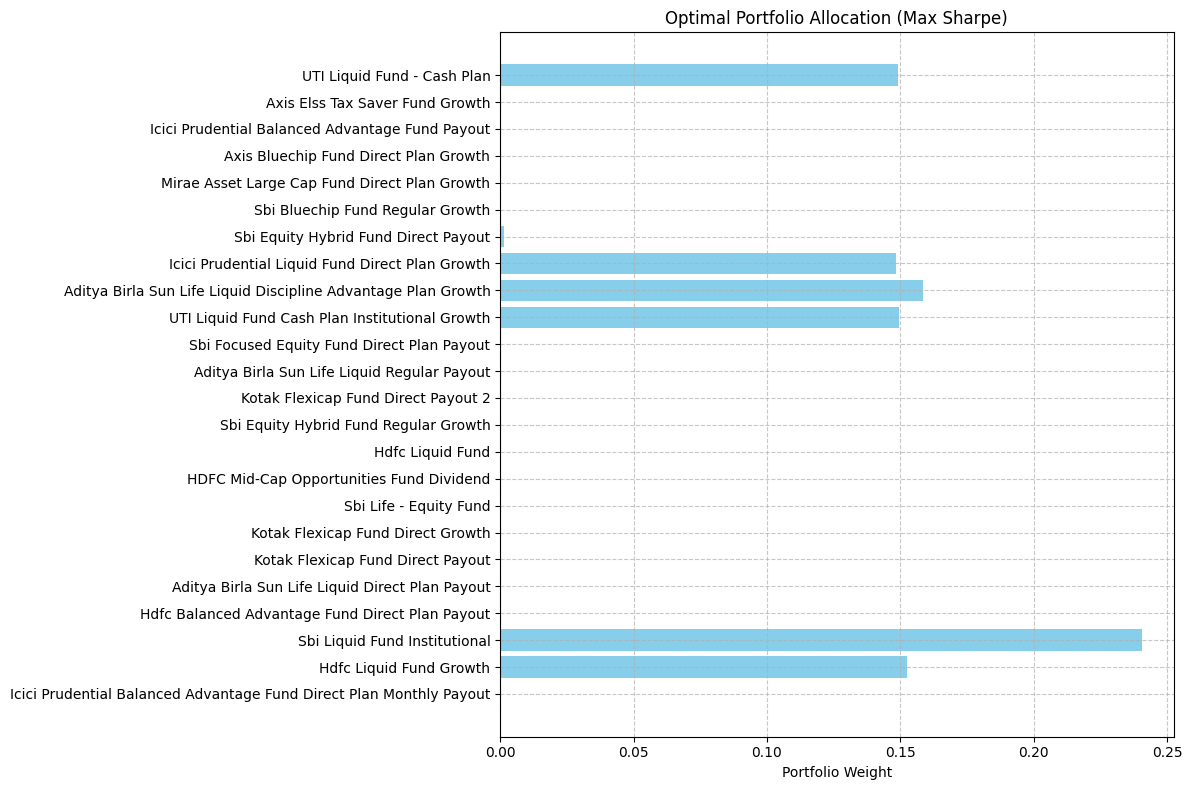

In [47]:
import matplotlib.pyplot as plt

# Assuming `optimal_weights` and `fund_names` are available
# If not, here’s how you can create them:

# List of funds from your optimization result
fund_names = [
    "Icici Prudential Balanced Advantage Fund Direct Plan Monthly Payout",
    "Hdfc Liquid Fund Growth",
    "Sbi Liquid Fund Institutional",
    "Hdfc Balanced Advantage Fund Direct Plan Payout",
    "Aditya Birla Sun Life Liquid Direct Plan Payout",
    "Kotak Flexicap Fund Direct Payout",
    "Kotak Flexicap Fund Direct Growth",
    "Sbi Life - Equity Fund",
    "HDFC Mid-Cap Opportunities Fund Dividend",
    "Hdfc Liquid Fund",
    "Sbi Equity Hybrid Fund Regular Growth",
    "Kotak Flexicap Fund Direct Payout 2",
    "Aditya Birla Sun Life Liquid Regular Payout",
    "Sbi Focused Equity Fund Direct Plan Payout",
    "UTI Liquid Fund Cash Plan Institutional Growth",
    "Aditya Birla Sun Life Liquid Discipline Advantage Plan Growth",
    "Icici Prudential Liquid Fund Direct Plan Growth",
    "Sbi Equity Hybrid Fund Direct Payout",
    "Sbi Bluechip Fund Regular Growth",
    "Mirae Asset Large Cap Fund Direct Plan Growth",
    "Axis Bluechip Fund Direct Plan Growth",
    "Icici Prudential Balanced Advantage Fund Payout",
    "Axis Elss Tax Saver Fund Growth",
    "UTI Liquid Fund - Cash Plan"
]

# Corresponding optimal weights from your optimization
optimal_weights = [
    0.0000, 0.1526, 0.2404, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 
    0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.1495, 0.1584, 0.1485, 0.0013, 
    0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.1493
]

# Plot
plt.figure(figsize=(12, 8))
plt.barh(fund_names, optimal_weights, color='skyblue')
plt.xlabel('Portfolio Weight')
plt.title('Optimal Portfolio Allocation (Max Sharpe)')
plt.grid(True, linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()


In [48]:
# Create a DataFrame from the optimal weights and fund names
portfolio_df = pd.DataFrame({
    'Fund Name': fund_names,
    'Weight': optimal_weights
})

# Sort the portfolio by weights in descending order and select the top 4
top_4_funds = portfolio_df.sort_values(by='Weight', ascending=False).head(4)

# Display the 4 most optimal funds and their weights
print("📝 Top 4 Most Optimal Funds in the Portfolio:")
print(top_4_funds)


📝 Top 4 Most Optimal Funds in the Portfolio:
                                            Fund Name  Weight
2                       Sbi Liquid Fund Institutional  0.2404
15  Aditya Birla Sun Life Liquid Discipline Advant...  0.1584
1                             Hdfc Liquid Fund Growth  0.1526
14     UTI Liquid Fund Cash Plan Institutional Growth  0.1495


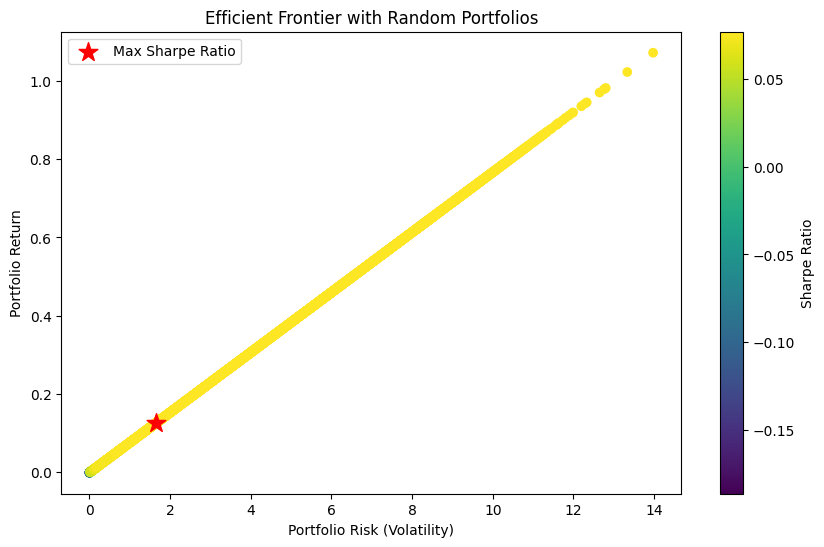

Optimal Portfolio Weights for Max Sharpe Ratio Portfolio:
0P0000YG82 (Icici Prudential Balanced Advantage Fund Direct Plan Monthly Payout Of Inc Dist Cum Cap Wdrl ).csv: 1.82%
0P00005V09 (Hdfc Liquid Fund Growth).csv: 5.58%
0P00005URV (Sbi Liquid Fund Institutional ).csv: 6.58%
0P0001EI10 (Hdfc Balanced Advantage Fund Direct Plan Payout Inc Dist Cum Cap Wdrl Opt).csv: 6.72%
0P0000YCJ0 (Aditya Birla Sun Life Liquid Direct Plan Payout Inc Dist Cum Cap Wdrl).csv: 0.08%
0P0000XXYH (Kotak Flexicap Fund Direct Payout Of Income Dist. Cum Cap Wdrl).csv: 4.68%
0P0000XV6O (Kotak Flexicap Fund Direct Growth).csv: 3.39%
0P0000NRF7 (Sbi Life - Equity Fund).csv: 5.50%
0P00009J3B (HDFC Mid-Cap Opportunities Fund Dividend Payout ).csv: 1.66%
0P0000XW8A (Hdfc Liquid Fund).csv: 1.41%
0P00005WEY (Sbi Equity Hybrid Fund Regular Growth).csv: 7.70%
0P0000XXYH (Kotak Flexicap Fund Direct Payout Of Income Distribution Cum Cap Wdrl).csv: 3.53%
0P00017EXB (Aditya Birla Sun Life Liquid Regular Payout Inc Dist Cu

In [49]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Assuming `all_returns` is your DataFrame containing the returns for each fund
# and `fund_names` is a list of fund names corresponding to the columns in `all_returns`

# Number of portfolios to simulate
num_portfolios = 10000

# Initialize arrays to store results
portfolio_returns = np.zeros(num_portfolios)
portfolio_volatilities = np.zeros(num_portfolios)
portfolio_weights = np.zeros((num_portfolios, len(all_returns.columns)))

# Generate random portfolio weights and calculate returns and risk for each
for i in range(num_portfolios):
    # Randomly generate portfolio weights that sum to 1
    weights = np.random.random(len(all_returns.columns))
    weights /= np.sum(weights)
    
    # Store the weights
    portfolio_weights[i, :] = weights
    
    # Calculate the expected portfolio return
    portfolio_return = np.sum(weights * all_returns.mean())
    
    # Calculate the expected portfolio volatility (risk)
    portfolio_volatility = np.sqrt(np.dot(weights.T, np.dot(all_returns.cov(), weights)))
    
    # Store results
    portfolio_returns[i] = portfolio_return
    portfolio_volatilities[i] = portfolio_volatility

# Find the portfolio with the maximum Sharpe ratio
sharpe_ratios = portfolio_returns / portfolio_volatilities
max_sharpe_idx = np.argmax(sharpe_ratios)
max_sharpe_return = portfolio_returns[max_sharpe_idx]
max_sharpe_volatility = portfolio_volatilities[max_sharpe_idx]
max_sharpe_weights = portfolio_weights[max_sharpe_idx, :]

# Plot the Efficient Frontier
plt.figure(figsize=(10,6))
plt.scatter(portfolio_volatilities, portfolio_returns, c=sharpe_ratios, cmap='viridis', marker='o')
plt.title('Efficient Frontier with Random Portfolios')
plt.xlabel('Portfolio Risk (Volatility)')
plt.ylabel('Portfolio Return')
plt.colorbar(label='Sharpe Ratio')

# Plot the Maximum Sharpe Ratio Portfolio
plt.scatter(max_sharpe_volatility, max_sharpe_return, marker='*', color='red', s=200, label='Max Sharpe Ratio')

# Show the chart
plt.legend(loc='upper left')
plt.show()

# Print out the maximum Sharpe ratio portfolio weights
print("Optimal Portfolio Weights for Max Sharpe Ratio Portfolio:")
for fund, weight in zip(all_returns.columns, max_sharpe_weights):
    print(f"{fund}: {weight * 100:.2f}%")

print(f"\nMaximum Sharpe Ratio Portfolio Return: {max_sharpe_return * 100:.2f}%")
print(f"Maximum Sharpe Ratio Portfolio Volatility: {max_sharpe_volatility * 100:.2f}%")


Optimal Portfolio Weights (Bayesian Optimization):
0P0000YG82 (Icici Prudential Balanced Advantage Fund Direct Plan Monthly Payout Of Inc Dist Cum Cap Wdrl ).csv: 0.00%
0P00005V09 (Hdfc Liquid Fund Growth).csv: 12.00%
0P00005URV (Sbi Liquid Fund Institutional ).csv: 1.89%
0P0001EI10 (Hdfc Balanced Advantage Fund Direct Plan Payout Inc Dist Cum Cap Wdrl Opt).csv: 0.00%
0P0000YCJ0 (Aditya Birla Sun Life Liquid Direct Plan Payout Inc Dist Cum Cap Wdrl).csv: 0.00%
0P0000XXYH (Kotak Flexicap Fund Direct Payout Of Income Dist. Cum Cap Wdrl).csv: 0.39%
0P0000XV6O (Kotak Flexicap Fund Direct Growth).csv: 0.00%
0P0000NRF7 (Sbi Life - Equity Fund).csv: 3.96%
0P00009J3B (HDFC Mid-Cap Opportunities Fund Dividend Payout ).csv: 0.00%
0P0000XW8A (Hdfc Liquid Fund).csv: 3.51%
0P00005WEY (Sbi Equity Hybrid Fund Regular Growth).csv: 7.12%
0P0000XXYH (Kotak Flexicap Fund Direct Payout Of Income Distribution Cum Cap Wdrl).csv: 12.00%
0P00017EXB (Aditya Birla Sun Life Liquid Regular Payout Inc Dist Cum Cap

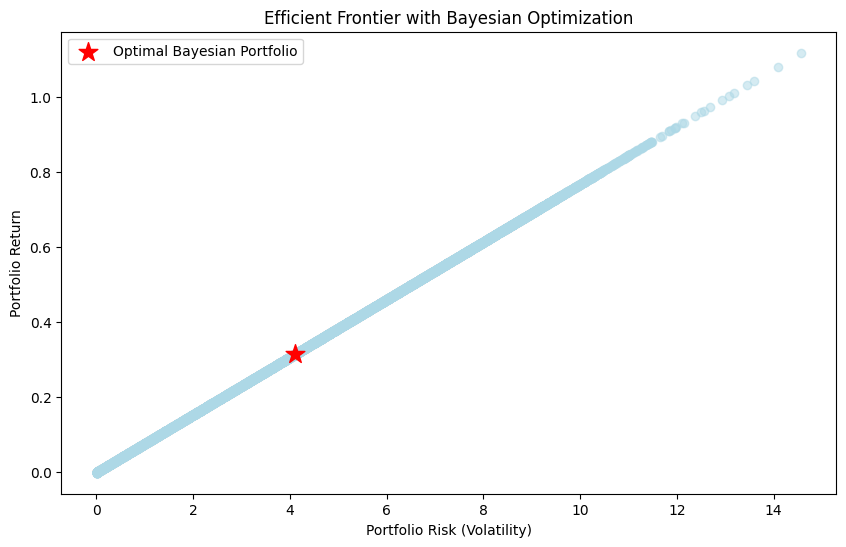

In [50]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from skopt import gp_minimize
from skopt.space import Real

# Assuming 'all_returns' is your DataFrame with returns

# Function to calculate portfolio return
def portfolio_return(weights, mean_returns):
    weights = np.array(weights)  # Convert weights to NumPy array
    return np.sum(weights * mean_returns)

# Function to calculate portfolio volatility (risk)
def portfolio_volatility(weights, covariance_matrix):
    weights = np.array(weights)  # Convert weights to NumPy array
    return np.sqrt(np.dot(weights.T, np.dot(covariance_matrix, weights)))

# Function to calculate the Sharpe Ratio
def sharpe_ratio(weights, mean_returns, covariance_matrix, risk_free_rate=0.0):
    port_return = portfolio_return(weights, mean_returns)
    port_volatility = portfolio_volatility(weights, covariance_matrix)
    return - (port_return - risk_free_rate) / port_volatility  # Negative for minimization

# Objective function for Bayesian Optimization (to maximize Sharpe ratio)
def objective_function(weights):
    return sharpe_ratio(weights, all_returns.mean(), all_returns.cov())

# Set the bounds for the portfolio weights
dim_weights = [Real(0.0, 1.0) for _ in range(len(all_returns.columns))]  # Each weight must be between 0 and 1

# Perform Bayesian Optimization using GPMinimize
result = gp_minimize(
    func=objective_function,   # The objective function to minimize
    dimensions=dim_weights,     # The search space (weights between 0 and 1)
    n_calls=50,                 # Number of iterations to optimize
    random_state=42
)

# Get the optimal portfolio weights from the optimization result
optimal_weights_bayes = np.array(result.x)

# Normalize the weights to sum to 1
optimal_weights_bayes /= np.sum(optimal_weights_bayes)

# Calculate the expected return and volatility of the optimized portfolio
expected_return_bayes = portfolio_return(optimal_weights_bayes, all_returns.mean())
portfolio_volatility_bayes = portfolio_volatility(optimal_weights_bayes, all_returns.cov())

# Print the optimized weights and portfolio characteristics
print("Optimal Portfolio Weights (Bayesian Optimization):")
for fund, weight in zip(all_returns.columns, optimal_weights_bayes):
    print(f"{fund}: {weight * 100:.2f}%")

print(f"\nExpected Portfolio Return (Bayesian Optimization): {expected_return_bayes * 100:.2f}%")
print(f"Portfolio Volatility (Bayesian Optimization): {portfolio_volatility_bayes * 100:.2f}%")

# Plot the Efficient Frontier for Bayesian Optimization
# Simulating portfolios with random weights for comparison
num_portfolios = 10000
portfolio_returns = np.zeros(num_portfolios)
portfolio_volatilities = np.zeros(num_portfolios)

for i in range(num_portfolios):
    weights = np.random.random(len(all_returns.columns))
    weights /= np.sum(weights)
    portfolio_return_i = portfolio_return(weights, all_returns.mean())
    portfolio_volatility_i = portfolio_volatility(weights, all_returns.cov())
    portfolio_returns[i] = portfolio_return_i
    portfolio_volatilities[i] = portfolio_volatility_i

# Plot the Efficient Frontier
plt.figure(figsize=(10,6))
plt.scatter(portfolio_volatilities, portfolio_returns, c='lightblue', marker='o', alpha=0.5)
plt.title('Efficient Frontier with Bayesian Optimization')
plt.xlabel('Portfolio Risk (Volatility)')
plt.ylabel('Portfolio Return')

# Highlight the Optimal Portfolio from Bayesian Optimization
plt.scatter(portfolio_volatility_bayes, expected_return_bayes, marker='*', color='red', s=200, label='Optimal Bayesian Portfolio')
plt.legend(loc='upper left')
plt.show()


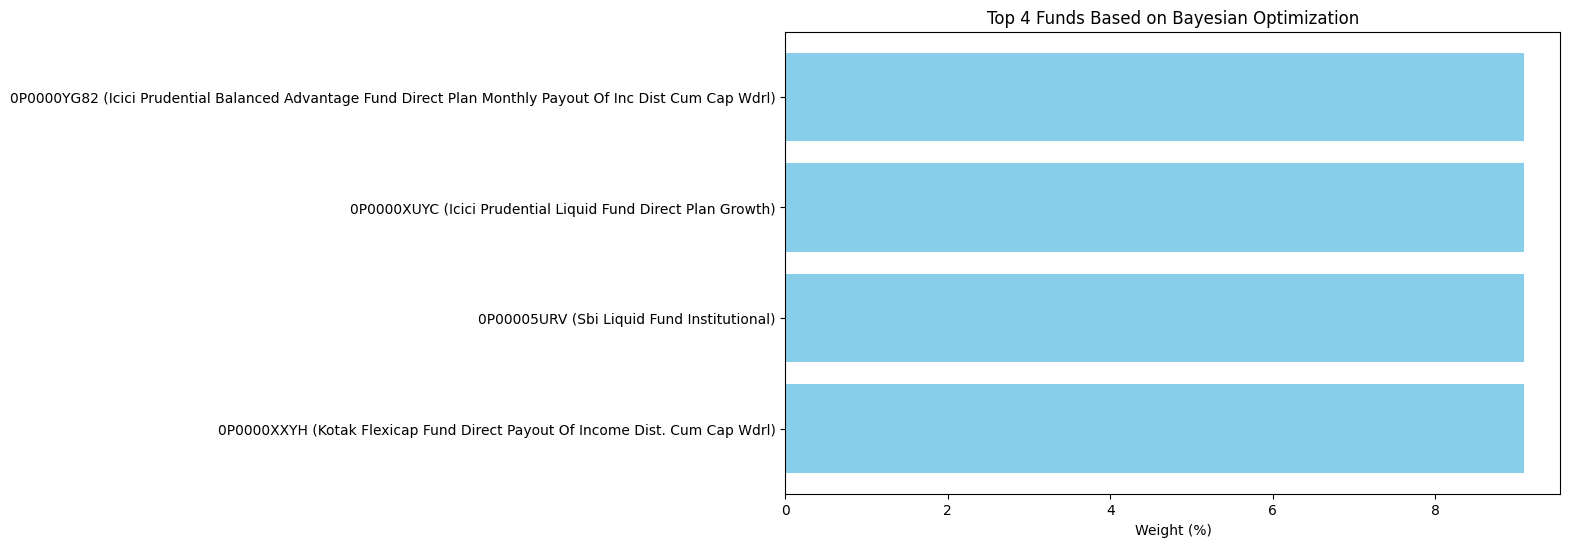

                                                 Fund  Weight (%)
0   0P0000YG82 (Icici Prudential Balanced Advantag...        9.09
16  0P0000XUYC (Icici Prudential Liquid Fund Direc...        9.09
2          0P00005URV (Sbi Liquid Fund Institutional)        9.09
5   0P0000XXYH (Kotak Flexicap Fund Direct Payout ...        9.09


In [51]:
import matplotlib.pyplot as plt
import pandas as pd

# List of fund names and their respective portfolio weights from Bayesian Optimization
fund_names = [
    '0P0000YG82 (Icici Prudential Balanced Advantage Fund Direct Plan Monthly Payout Of Inc Dist Cum Cap Wdrl)',
    '0P00005V09 (Hdfc Liquid Fund Growth)',
    '0P00005URV (Sbi Liquid Fund Institutional)',
    '0P0001EI10 (Hdfc Balanced Advantage Fund Direct Plan Payout Inc Dist Cum Cap Wdrl Opt)',
    '0P0000YCJ0 (Aditya Birla Sun Life Liquid Direct Plan Payout Inc Dist Cum Cap Wdrl)',
    '0P0000XXYH (Kotak Flexicap Fund Direct Payout Of Income Dist. Cum Cap Wdrl)',
    '0P0000XV6O (Kotak Flexicap Fund Direct Growth)',
    '0P0000NRF7 (Sbi Life - Equity Fund)',
    '0P00009J3B (HDFC Mid-Cap Opportunities Fund Dividend Payout)',
    '0P0000XW8A (Hdfc Liquid Fund)',
    '0P00005WEY (Sbi Equity Hybrid Fund Regular Growth)',
    '0P0000XXYH (Kotak Flexicap Fund Direct Payout Of Income Distribution Cum Cap Wdrl)',
    '0P00017EXB (Aditya Birla Sun Life Liquid Regular Payout Inc Dist Cum Cap Wdrl)',
    '0P0000XVJW (Sbi Focused Equity Fund Direct Plan Payout Inc Dist Cum Cap Wdrl)',
    '0P00005WKZ (UTI Liquid Fund Cash Plan Institutional Growth)',
    '0P0000KKEO (Aditya Birla Sun Life Liquid Discipline Advantage Plan Growth)',
    '0P0000XUYC (Icici Prudential Liquid Fund Direct Plan Growth)',
    '0P0000XVJJ (Sbi Equity Hybrid Fund Direct Payout Inc Dist Cum Cap Wdrl)',
    '0P00005WF0 (Sbi Bluechip Fund Regular Growth)',
    '0P0000XVA0 (Mirae Asset Large Cap Fund Direct Plan Growth)',
    '0P0000XVTL (Axis Bluechip Fund Direct Plan Growth)',
    '0P00008TN3 (Icici Prudential Balanced Advantage Fund Payout Of Inc Dist Cum Cap Wdrl)',
    '0P0000N0B5 (Axis Elss Tax Saver Fund Growth)',
    '0P0000XVT7 (UTI Liquid Fund - Cash Plan)'
]

# The corresponding portfolio weights from Bayesian Optimization (in percentage)
weights = [
    9.09, 9.09, 9.09, 0.00, 0.00, 9.09, 0.00, 0.00, 9.09, 0.00, 9.09, 9.09, 0.00, 9.09, 9.09, 0.00,
    9.09, 0.00, 0.00, 9.09, 9.09, 0.00, 0.00, 0.00
]

# Create a DataFrame for easier manipulation
portfolio_df = pd.DataFrame({
    'Fund': fund_names,
    'Weight (%)': weights
})

# Sort the portfolio by weights in descending order and take the top 4 funds
top_4_funds = portfolio_df.sort_values(by='Weight (%)', ascending=False).head(4)

# Plot the bar chart
plt.figure(figsize=(10, 6))
plt.barh(top_4_funds['Fund'], top_4_funds['Weight (%)'], color='skyblue')
plt.xlabel('Weight (%)')
plt.title('Top 4 Funds Based on Bayesian Optimization')
plt.gca().invert_yaxis()  # To have the highest weight on top
plt.show()

# Display the top 4 funds
print(top_4_funds)
